# Goal

* Generating the plots for the Figures 1 and 2 and S1-S3 of the manuscript.

# Init

In [1]:
library(dplyr)
library(phyloseq)
library(readxl)
library(microbiome)
library(tibble) 
library(ggplot2) 
library(lme4)
library(MuMIn)
library(data.table)
library(forcats)
library(LeyLabRMisc)
library(stringr)
library(tidyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2


microbiome R package (microbiome.github.com)
    


 Copyright (C) 2011-2022 Leo Lahti, 
    Sudarshan Shetty et al. <microbiome.github.io>



Attaching package: ‘microbiome’


The following object is masked from ‘package:ggplot2’:

    alpha


The following object is masked from ‘package:base’:

    transform


Loading required package: Matrix


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Warning message:
“replacing previous import ‘data.table::last’ by ‘tidytable::last’ when loading ‘LeyLabRMisc’”
Warning message:
“replacing previous import ‘data.table::first’ by ‘tidytable::first’ when loading ‘LeyLabRMisc’”
Warning message:
“replacing previous import ‘data.table::between’ by ‘t

# Var

In [2]:
data_dir = "../data/for_Exp_1_Suzuki_Figs"

# Load

In [3]:
Trait_list = read.table(file.path(data_dir, "Trait_list.txt"), sep = "\t", header = TRUE)
Master_data_pilot2 = read.table(file.path(data_dir, "Summary_Batch123_2022.06.22_ver6.txt"), header = TRUE)
Master_data1 = read.table(file.path(data_dir, "Master_data_ver7_2023.04.10.txt"), header = TRUE)
AICc = read.table(file.path(data_dir, "AICc_results.txt"), header = TRUE, sep = "\t")
Master_data_pilot2_v3 = read.table(file.path(data_dir, "Summary_Batch123_2022.06.22_ver3.txt"), header = TRUE)
Master_data_pilot = read.table(file.path(data_dir, "Rinput_traits_2022.06.15.tsv"), header = TRUE)

# Functions

In [4]:
# A function to conduct model comparisons on distance traveled using likelihood ratio test and wilcoxon test
model_compare_lmtest_BW_3w_Batch_selection_exp1 = function(input_file, category1, category2, output_dir) {

  #Extract rows by categories (e.g. C_N1, C_N5)   
  filtered_data = input_file %>% filter(Treatment2 == category1 | Treatment2 == category2)

  #Log transform, scale, and center
  filtered_data$PedMeters_ALL_log = scale(log(filtered_data$PedMeters_ALL),center = TRUE, scale = TRUE) 
  filtered_data$BW_3_4w_log = scale(log(filtered_data$BW_3_4w), center = TRUE, scale = TRUE)

  #Model comparisons
  PedMeters_full_model <- lmer(PedMeters_ALL_log ~ Treatment2 + BW_3_4w_log + (1|Batch), data = filtered_data)
  PedMeters_partial_model <- lmer(PedMeters_ALL_log ~ BW_3_4w_log + (1|Batch), data = filtered_data)
  #Batch contains 8 levels

  #Calculate AIC and AICc
  PedMeters_full_model_AIC = AIC(PedMeters_full_model)
  PedMeters_partial_model_AIC = AIC(PedMeters_partial_model)
  PedMeters_full_model_AICc = AICc(PedMeters_full_model)
  PedMeters_partial_model_AICc = AICc(PedMeters_partial_model)

  #Store residuals
  filtered_data$PedMeters_partial_model_resid = resid(PedMeters_partial_model)


  #Likelihood ratio test
  PedMeters_lmtest = lmtest:::lrtest(PedMeters_full_model,PedMeters_partial_model) 

  #wilcox test
  #raw data
  PedMeters_wilcox_raw = wilcox.test(PedMeters_ALL ~ Treatment2, data = filtered_data) 

  #Using residuals
  PedMeters_wilcox_resid = wilcox.test(PedMeters_partial_model_resid ~ Treatment2, data = filtered_data) 

  #output
  sink(paste0(output_dir, category1, "_", category2, "_lmtest_wilcox_output.txt"), append=TRUE)
    print(PedMeters_lmtest)
    print(paste0("PedMeters_full_model_AIC = ",PedMeters_full_model_AIC))
    print(paste0("PedMeters_partial_model_AIC = ",PedMeters_partial_model_AIC))
    print(paste0("PedMeters_full_model_AICc = ",PedMeters_full_model_AICc))
    print(paste0("PedMeters_partial_model_AICc = ",PedMeters_partial_model_AICc))
    print("Wilcoxon rank sum test (raw)")
    print(PedMeters_wilcox_raw)
    print("Wilcoxon rank sum test (Residuals)")
    print(PedMeters_wilcox_resid)
  sink()
}

# Figures

## Fig. 1B

Using Trait as id variables



[1] P<0.01   P<0.001  P<0.05   P<0.05   P<0.1    P<0.001  P<0.001  P<0.001 
 [9] P<0.001  P<0.01   P<0.05   P<0.001  P>0.1    P<0.01   P<0.0001 P<0.0001
[17] P<0.1    P>0.1    P>0.1    P>0.1    P>0.1    P<0.01   P>0.1    P<0.05  
[25] P>0.1    P>0.1    P>0.1    P<0.1    P>0.1    P<0.1    P<0.05   P<0.05  
Levels: P<0.0001 P<0.001 P<0.01 P<0.05 P<0.1 P>0.1

Warning message in geom_text(aes(label = paste(value, "%")), color = "black", face = "bold", :
“Ignoring unknown parameters: `face`”


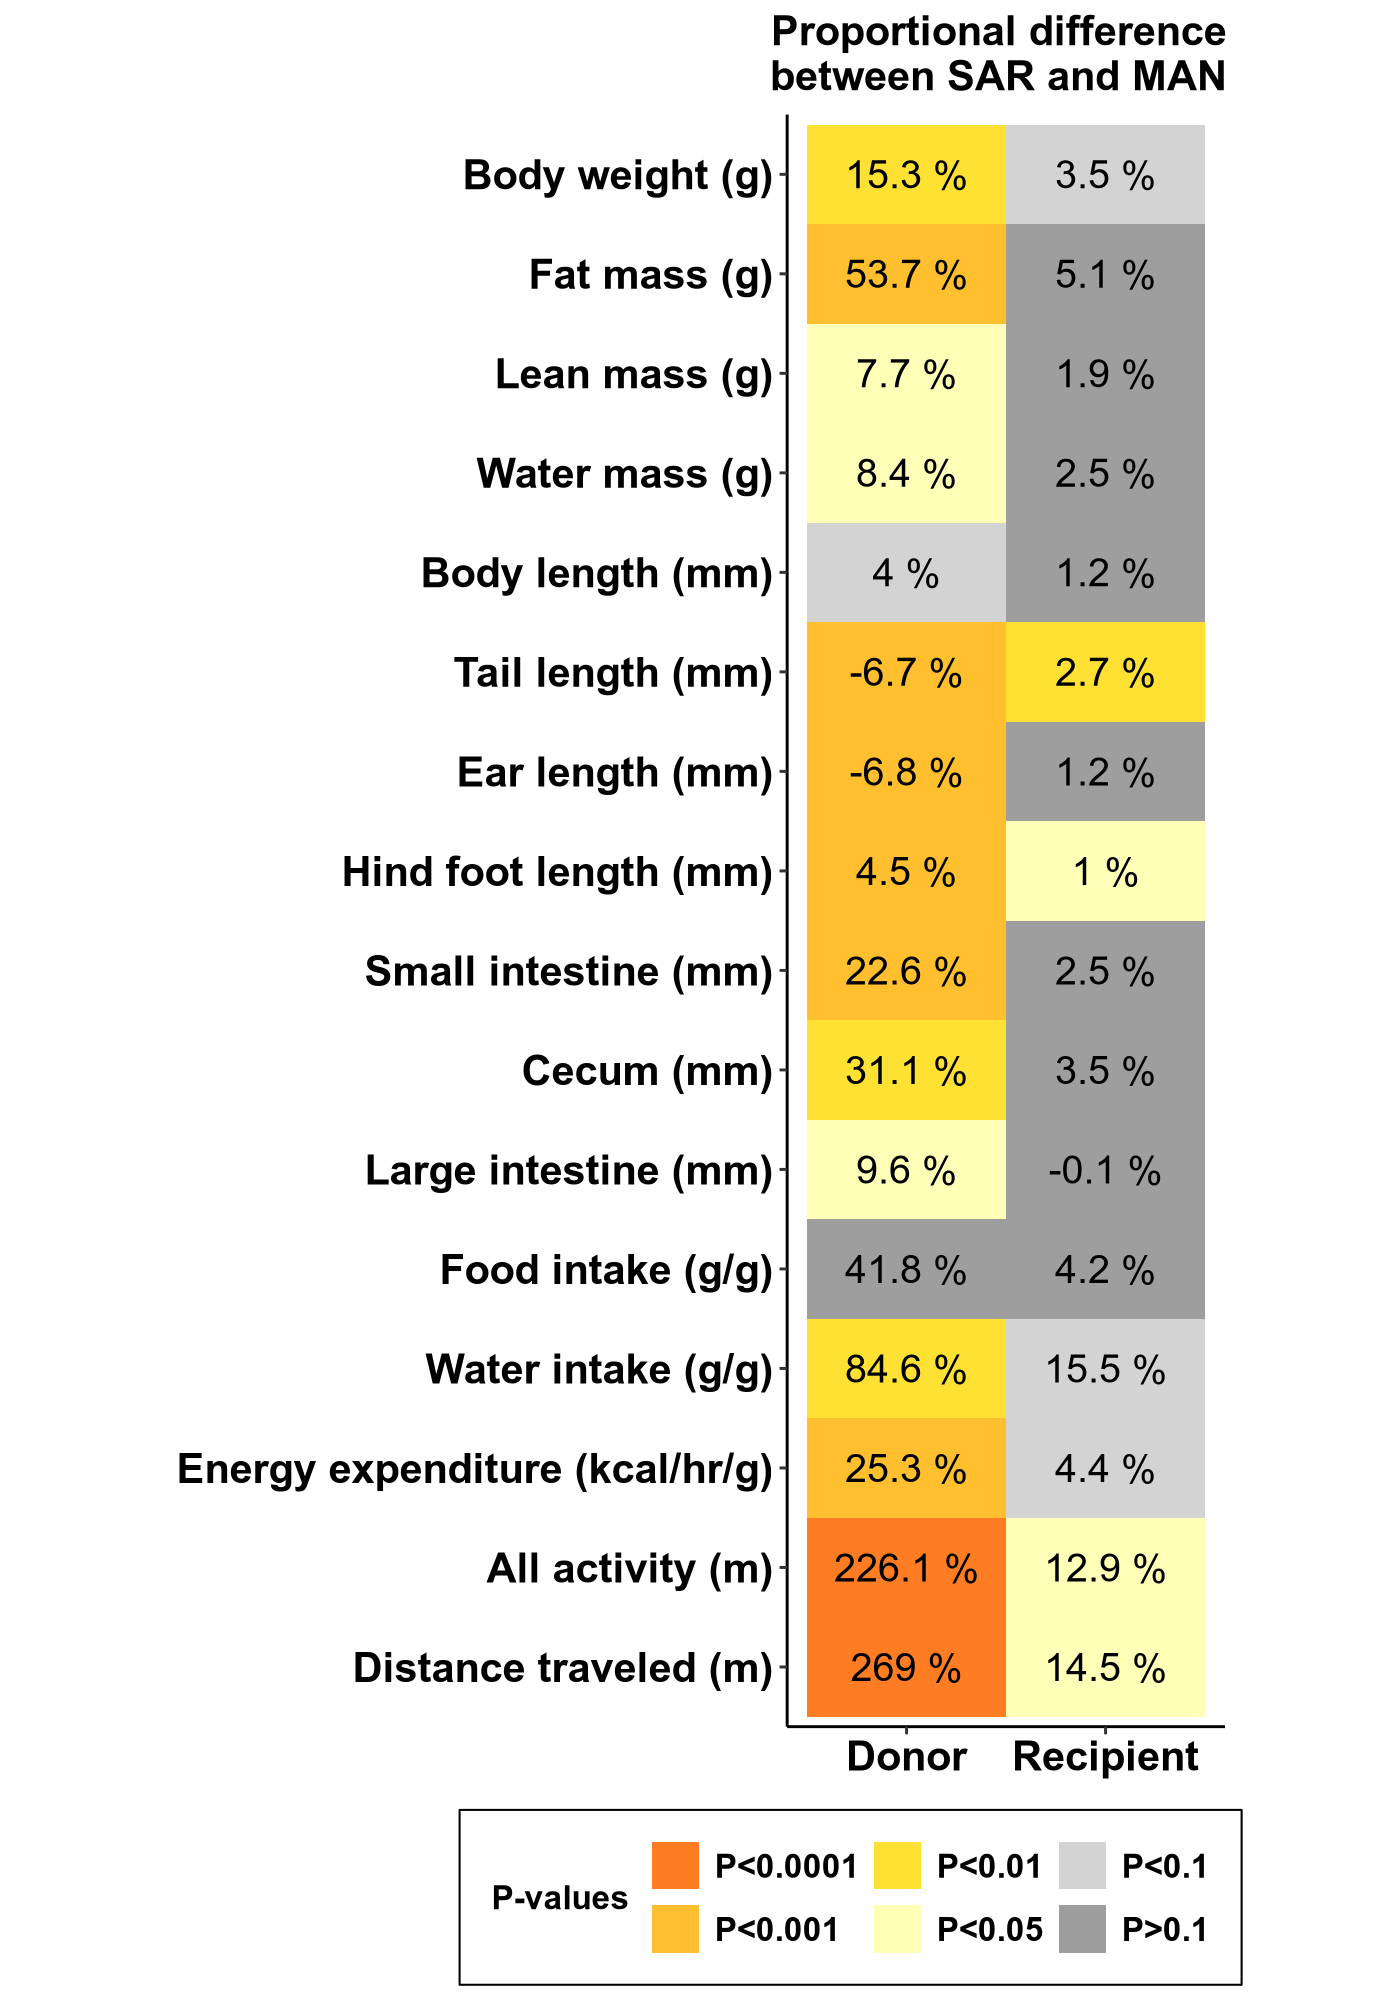

In [5]:
Trait_list_raw<- Trait_list %>% select("Trait","Donor", "Recipient")
Trait_list_raw2 = reshape2::melt(Trait_list_raw) 

#Donor and Recipient p-values groups
Trait_list_p_group <- Trait_list %>% select("Trait","Donor_P_group", "Recipient_P_group")
Trait_list_p_group2 = reshape2::melt(Trait_list_p_group, id = "Trait")

#combine melted table into one
P_group = Trait_list_p_group2$value
Combined_table = Trait_list_raw2
Combined_table$P_group = P_group
as.factor(Combined_table$P_group)


#traits
Combined_table$Trait <- factor(Combined_table$Trait, levels=c(
"Body weight (g)",
"Fat mass (g)",
"Lean mass (g)",
"Water mass (g)",
"Body length (mm)",
"Tail length (mm)",
"Ear length (mm)",
"Hind foot length (mm)",
"Small intestine (mm)",
"Cecum (mm)",
"Large intestine (mm)",
"Food intake (g/g)",
"Water intake (g/g)",
"Energy expenditure (kcal/hr/g)",
"All activity (m)",
"Distance traveled (m)"
))

#p-value levels
Combined_table$P_group = factor(Combined_table$P_group, levels=c("P<0.0001", "P<0.001", "P<0.01", "P<0.05", "P<0.1", "P>0.1"))

p.dims(7, 10)
#plot heatmap
ggplot(Combined_table, aes(x = variable, y = fct_rev(Trait), fill = P_group)) +
  geom_tile() +
  geom_text(aes(label=paste(value, "%")),color = "black", face="bold", size = 5) +
  scale_fill_manual(breaks = levels(Combined_table$P_group),
                    values = c("#FE7C22", "#FFBF2E", "#FFE134", "#FFFFB7", "#D3D3D3","#9E9E9E")) +
  ggtitle("Proportional difference\nbetween SAR and MAN") +
  labs(fill = "P-values") +
  coord_fixed(ratio = 1/2) +
  theme_classic() +
  theme(axis.text = element_text(face="bold", size = 15, colour="black"),
    axis.title.y = element_blank(),
    axis.title.x = element_blank(),
    #axis.title.x = element_text(margin = margin(t = 10, r = 0, b = 0, l = 0), face="bold", size = 15, colour="black"),
    plot.title = element_text(face = "bold", size = 15, colour="black", hjust = 0.9, vjust = 1), 
    legend.position = "bottom",
    legend.justification = "right",
    legend.box.background = element_rect(),
    legend.box.margin = margin(6, 6, 6, 6),
    legend.title = element_text(colour="black", size=12, face="bold"),
    legend.text = element_text(colour="black", size=12, face="bold")
    )

## Fig. 1C

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


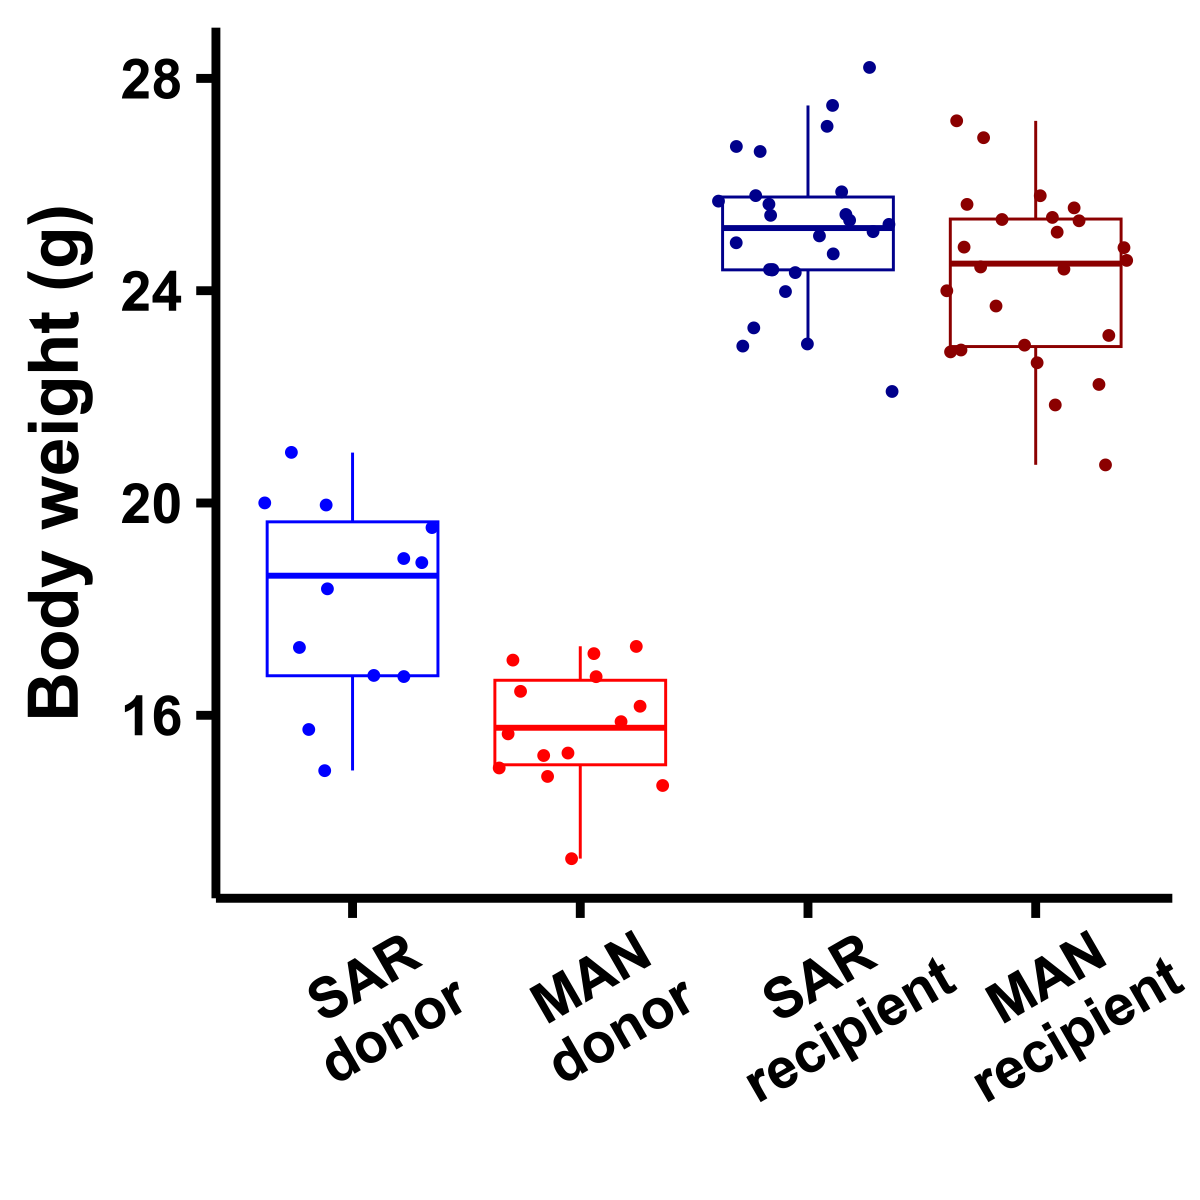

In [6]:
Master_data_pilot3 <- Master_data_pilot2 %>% select(ALL, RQ_48hours, RQ_24hours_1, RQ_5h_Day1, kcal_hr_48hours, kcal_hr_24hours_1, kcal_hr_5h_Day1, food_48hours, food_24hours_1, food_5h_Day1, water_48hours, water_24hours_1, water_5h_Day1,xbreak_48hours, xbreak_24hours_1, xbreak_5h_Day1, ybreak_48hours, ybreak_24hours_1, ybreak_5h_Day1, zbreak_48hours, zbreak_24hours_1, zbreak_5h_Day1, ped_m_48hours, ped_m_24hours_1, ped_m_5h_Day1, all_m_48hours, all_m_24hours_1, all_m_5h_Day1, BW_3w, BW_4w, BW_5w, BW_6w, BW_7w, BW_8w, BW_8w_final, fat_4w, fat_6w, fat_8w, lean_4w, lean_6w, lean_8w, F.water_4w, F.water_6w, F.water_8w, T.water_4w, T.water_6w, T.water_8w, TBL, TL, EL, HFL, BL, Small_Int_mm, Small_Int_g, Cecum_mm, Cecum_g, Large_int_mm, Large_int_g, Fat_pad) 
Master_data_pilot3$ALL <- factor(Master_data_pilot3$ALL , levels=c("NY_donor", "BR_donor", "GFNY", "GFBR"))

p.dims(6, 6)
ggplot(Master_data_pilot3, aes(x = ALL, y = BW_8w, colour = ALL)) + 
  geom_boxplot(outlier.shape = NA) +
  geom_jitter() + 
  theme_classic() + 
  
  scale_color_manual(values=c('blue', 'red', "blue4", "red4")) +
  #labs(col="Treatment") + #Legend label
  #xlab("Treatment") 
  scale_x_discrete(breaks=c("NY_donor", "BR_donor", "GFNY", "GFBR"), labels=c("SAR\ndonor", "MAN\ndonor","SAR\nrecipient","MAN\nrecipient")) + 
  ylab("Body weight (g)") + 
  
  theme(axis.text = element_text(face="bold", size = 20, colour="black"), axis.title = element_text(face="bold", size = 25),
        #margin
        axis.text.y = element_text(margin = margin(t = 0, r = 5, b = 0, l = 0)),
        axis.text.x = element_text(angle = 30,margin = margin(t = 15, r = 0, b = 0, l = 0)),
        axis.title.y = element_text(margin = margin(t = 0, r = 10, b = 0, l = 0)),
        #axis.title.x = element_text(margin = margin(t = 10, r = 0, b = 0, l = 0)),
        axis.title.x = element_blank(),
        axis.line = element_line(colour = 'black', size = 1.5),
        axis.ticks = element_line(color = "black", size= 1.5),
        axis.ticks.length = unit(.25, "cm"),
        plot.margin = margin(t = 10,  # Top margin
                             r = 10,  # Right margin
                             b = 10,  # Bottom margin
                             l = 10), # Left margin
        #label
        legend.box.background = element_rect(),
        legend.box.margin = margin(6, 6, 6, 6),
        legend.position = "none"
        )

## Fig. 1D

Warning message:
“Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


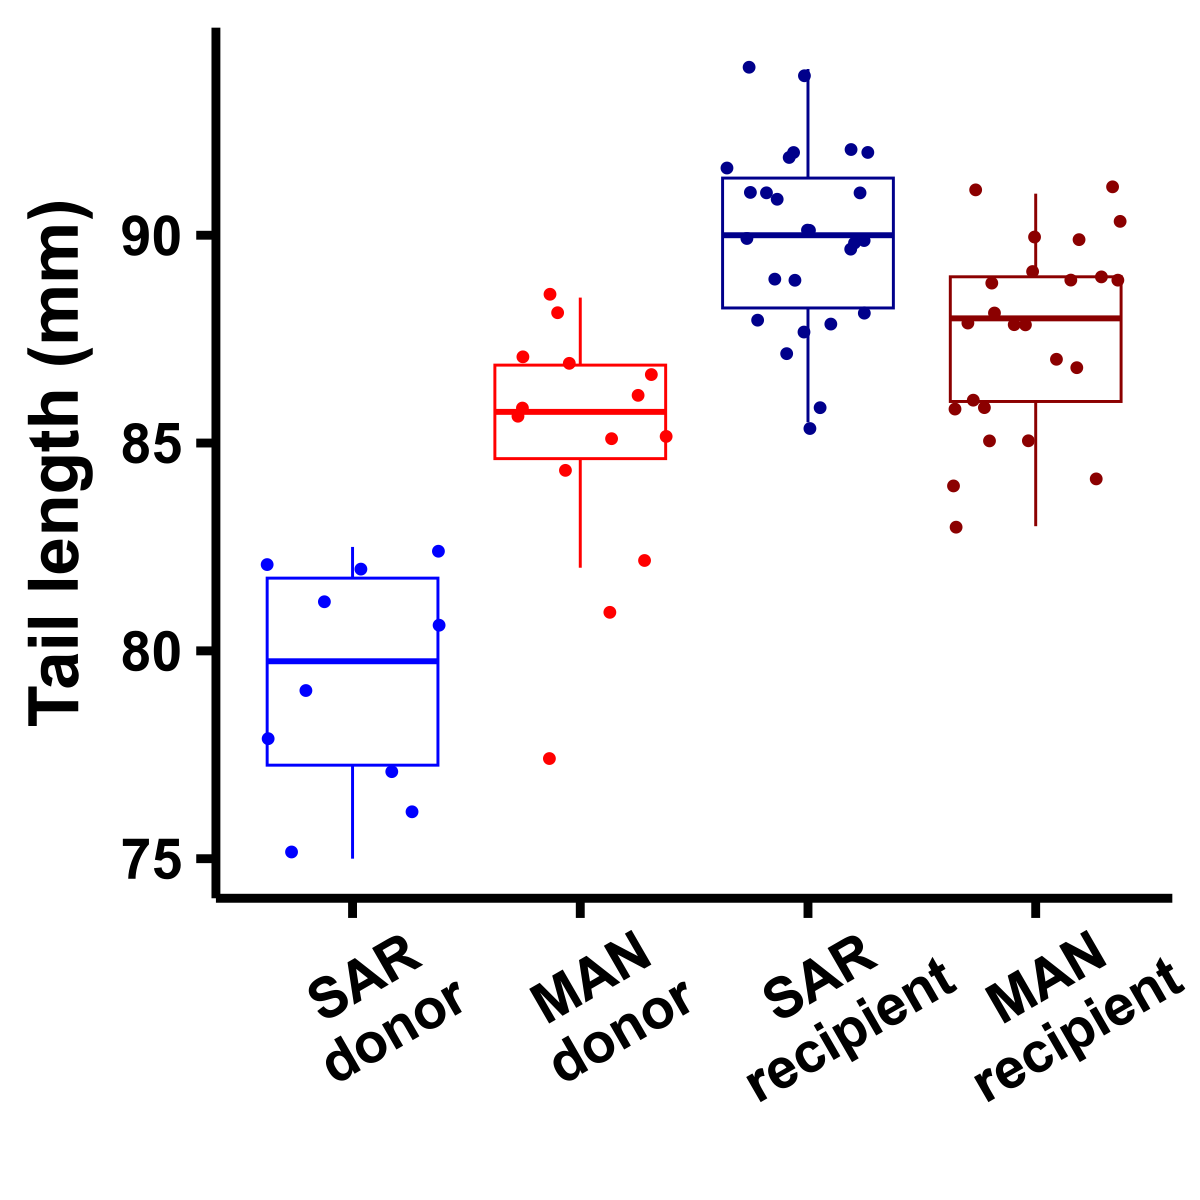

In [7]:
Master_data_pilot3 <- Master_data_pilot2 %>% select(ALL, RQ_48hours, RQ_24hours_1, RQ_5h_Day1, kcal_hr_48hours, kcal_hr_24hours_1, kcal_hr_5h_Day1, food_48hours, food_24hours_1, food_5h_Day1, water_48hours, water_24hours_1, water_5h_Day1,xbreak_48hours, xbreak_24hours_1, xbreak_5h_Day1, ybreak_48hours, ybreak_24hours_1, ybreak_5h_Day1, zbreak_48hours, zbreak_24hours_1, zbreak_5h_Day1, ped_m_48hours, ped_m_24hours_1, ped_m_5h_Day1, all_m_48hours, all_m_24hours_1, all_m_5h_Day1, BW_3w, BW_4w, BW_5w, BW_6w, BW_7w, BW_8w, BW_8w_final, fat_4w, fat_6w, fat_8w, lean_4w, lean_6w, lean_8w, F.water_4w, F.water_6w, F.water_8w, T.water_4w, T.water_6w, T.water_8w, TBL, TL, EL, HFL, BL, Small_Int_mm, Small_Int_g, Cecum_mm, Cecum_g, Large_int_mm, Large_int_g, Fat_pad) 
Master_data_pilot3$ALL <- factor(Master_data_pilot3$ALL , levels=c("NY_donor", "BR_donor", "GFNY", "GFBR"))

p.dims(6, 6)
ggplot(Master_data_pilot3, aes(x = ALL, y = TL, colour = ALL)) + 
  geom_boxplot(outlier.shape = NA) +
  geom_jitter() + 
  theme_classic() + 
  
  scale_color_manual(values=c('blue', 'red', "blue4", "red4")) +
  #labs(col="Treatment") + #Legend label
  #xlab("Treatment") 
  scale_x_discrete(breaks=c("NY_donor", "BR_donor", "GFNY", "GFBR"), labels=c("SAR\ndonor", "MAN\ndonor","SAR\nrecipient","MAN\nrecipient")) + 
  ylab("Tail length (mm)") + 
  
  theme(axis.text = element_text(face="bold", size = 20, colour="black"), axis.title = element_text(face="bold", size = 25),
        #margin
        axis.text.y = element_text(margin = margin(t = 0, r = 5, b = 0, l = 0)),
        axis.text.x = element_text(angle = 30,margin = margin(t = 15, r = 0, b = 0, l = 0)),
        axis.title.y = element_text(margin = margin(t = 0, r = 10, b = 0, l = 0)),
        #axis.title.x = element_text(margin = margin(t = 10, r = 0, b = 0, l = 0)),
        axis.title.x = element_blank(),
        axis.line = element_line(colour = 'black', size = 1.5),
        axis.ticks = element_line(color = "black", size= 1.5),
        axis.ticks.length = unit(.25, "cm"),
        plot.margin = margin(t = 10,  # Top margin
                             r = 10,  # Right margin
                             b = 10,  # Bottom margin
                             l = 10), # Left margin
        #label
        legend.box.background = element_rect(),
        legend.box.margin = margin(6, 6, 6, 6),
        legend.position = "none"
        )

## Fig. 1E

Warning message:
“Removed 6 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 6 rows containing missing values or values outside the scale range
(`geom_point()`).”


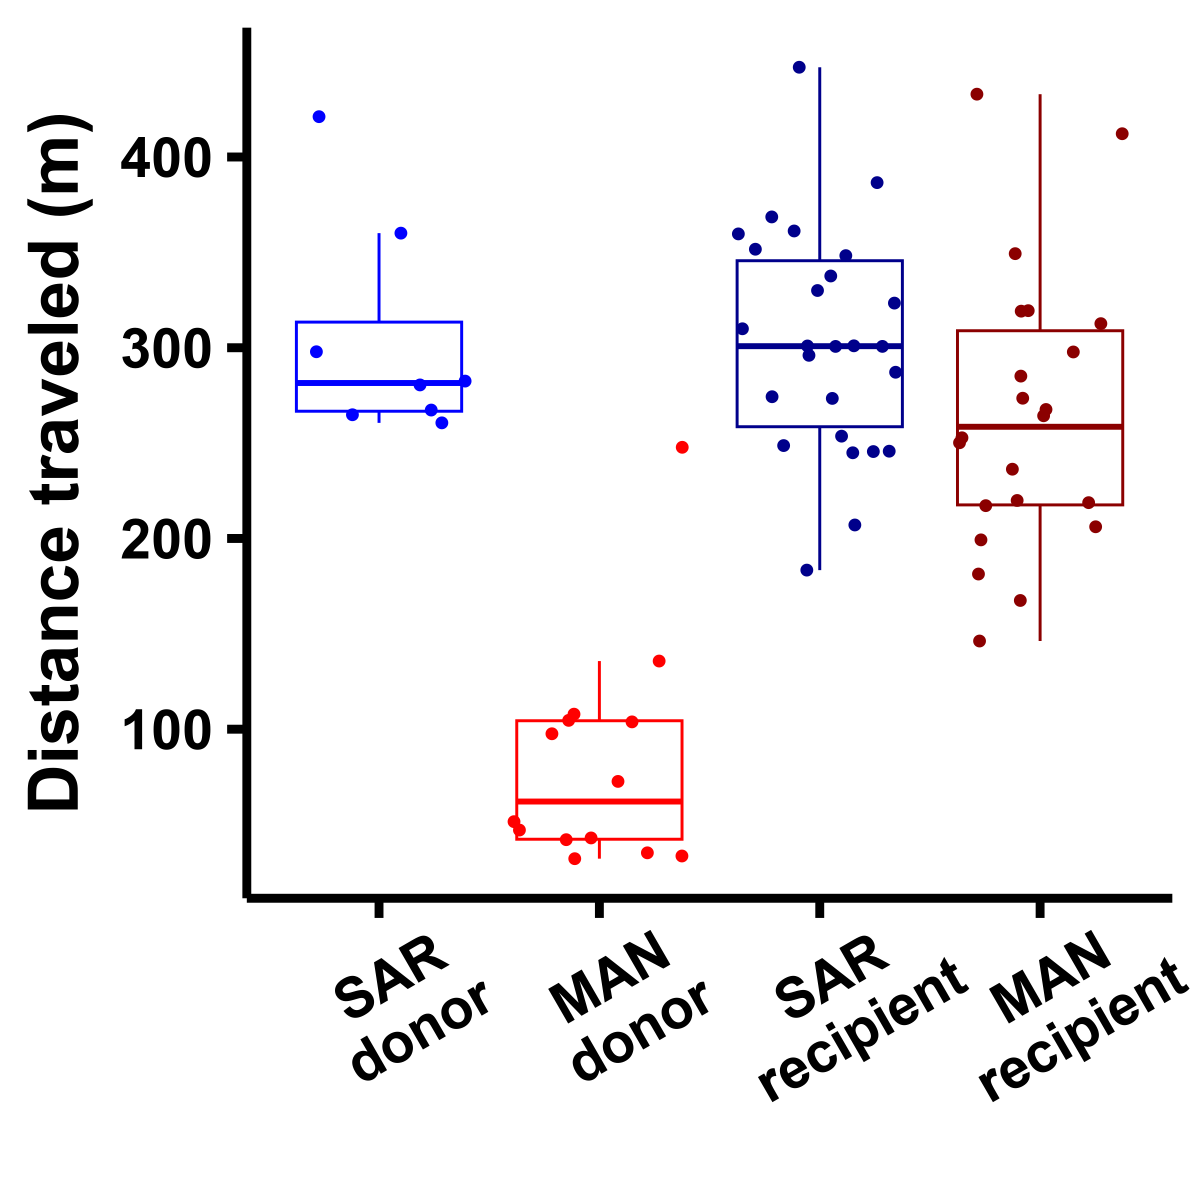

In [8]:
Master_data_pilot3 <- Master_data_pilot2 %>% select(ALL, RQ_48hours, RQ_24hours_1, RQ_5h_Day1, kcal_hr_48hours, kcal_hr_24hours_1, kcal_hr_5h_Day1, food_48hours, food_24hours_1, food_5h_Day1, water_48hours, water_24hours_1, water_5h_Day1,xbreak_48hours, xbreak_24hours_1, xbreak_5h_Day1, ybreak_48hours, ybreak_24hours_1, ybreak_5h_Day1, zbreak_48hours, zbreak_24hours_1, zbreak_5h_Day1, ped_m_48hours, ped_m_24hours_1, ped_m_5h_Day1, all_m_48hours, all_m_24hours_1, all_m_5h_Day1, BW_3w, BW_4w, BW_5w, BW_6w, BW_7w, BW_8w, BW_8w_final, fat_4w, fat_6w, fat_8w, lean_4w, lean_6w, lean_8w, F.water_4w, F.water_6w, F.water_8w, T.water_4w, T.water_6w, T.water_8w, TBL, TL, EL, HFL, BL, Small_Int_mm, Small_Int_g, Cecum_mm, Cecum_g, Large_int_mm, Large_int_g, Fat_pad) 
Master_data_pilot3$ALL <- factor(Master_data_pilot3$ALL , levels=c("NY_donor", "BR_donor", "GFNY", "GFBR"))

p.dims(6, 6)
ggplot(Master_data_pilot3, aes(x = ALL, y = ped_m_24hours_1, colour = ALL)) + 
  geom_boxplot(outlier.shape = NA) +
  geom_jitter() + 
  theme_classic() + 
  
  scale_color_manual(values=c('blue', 'red', "blue4", "red4")) +
  #labs(col="Treatment") + #Legend label
  #xlab("Treatment") 
  scale_x_discrete(breaks=c("NY_donor", "BR_donor", "GFNY", "GFBR"), labels=c("SAR\ndonor", "MAN\ndonor","SAR\nrecipient","MAN\nrecipient")) + 
  ylab("Distance traveled (m)") + 
  
  theme(axis.text = element_text(face="bold", size = 20, colour="black"), axis.title = element_text(face="bold", size = 25),
        #margin
        axis.text.y = element_text(margin = margin(t = 0, r = 5, b = 0, l = 0)),
        axis.text.x = element_text(angle = 30,margin = margin(t = 15, r = 0, b = 0, l = 0)),
        axis.title.y = element_text(margin = margin(t = 0, r = 10, b = 0, l = 0)),
        #axis.title.x = element_text(margin = margin(t = 10, r = 0, b = 0, l = 0)),
        axis.title.x = element_blank(),
        axis.line = element_line(colour = 'black', size = 1.5),
        axis.ticks = element_line(color = "black", size= 1.5),
        axis.ticks.length = unit(.25, "cm"),
        plot.margin = margin(t = 10,  # Top margin
                             r = 10,  # Right margin
                             b = 10,  # Bottom margin
                             l = 10), # Left margin
        #label
        legend.box.background = element_rect(),
        legend.box.margin = margin(6, 6, 6, 6),
        legend.position = "none"
        )

## Fig. 2B (raw)

Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
ℹ Please use a list of either functions or lambdas:

# Simple named list: list(mean = mean, median = median)

# Auto named with `tibble::lst()`: tibble::lst(mean, median)

# Using lambdas list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))”
Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


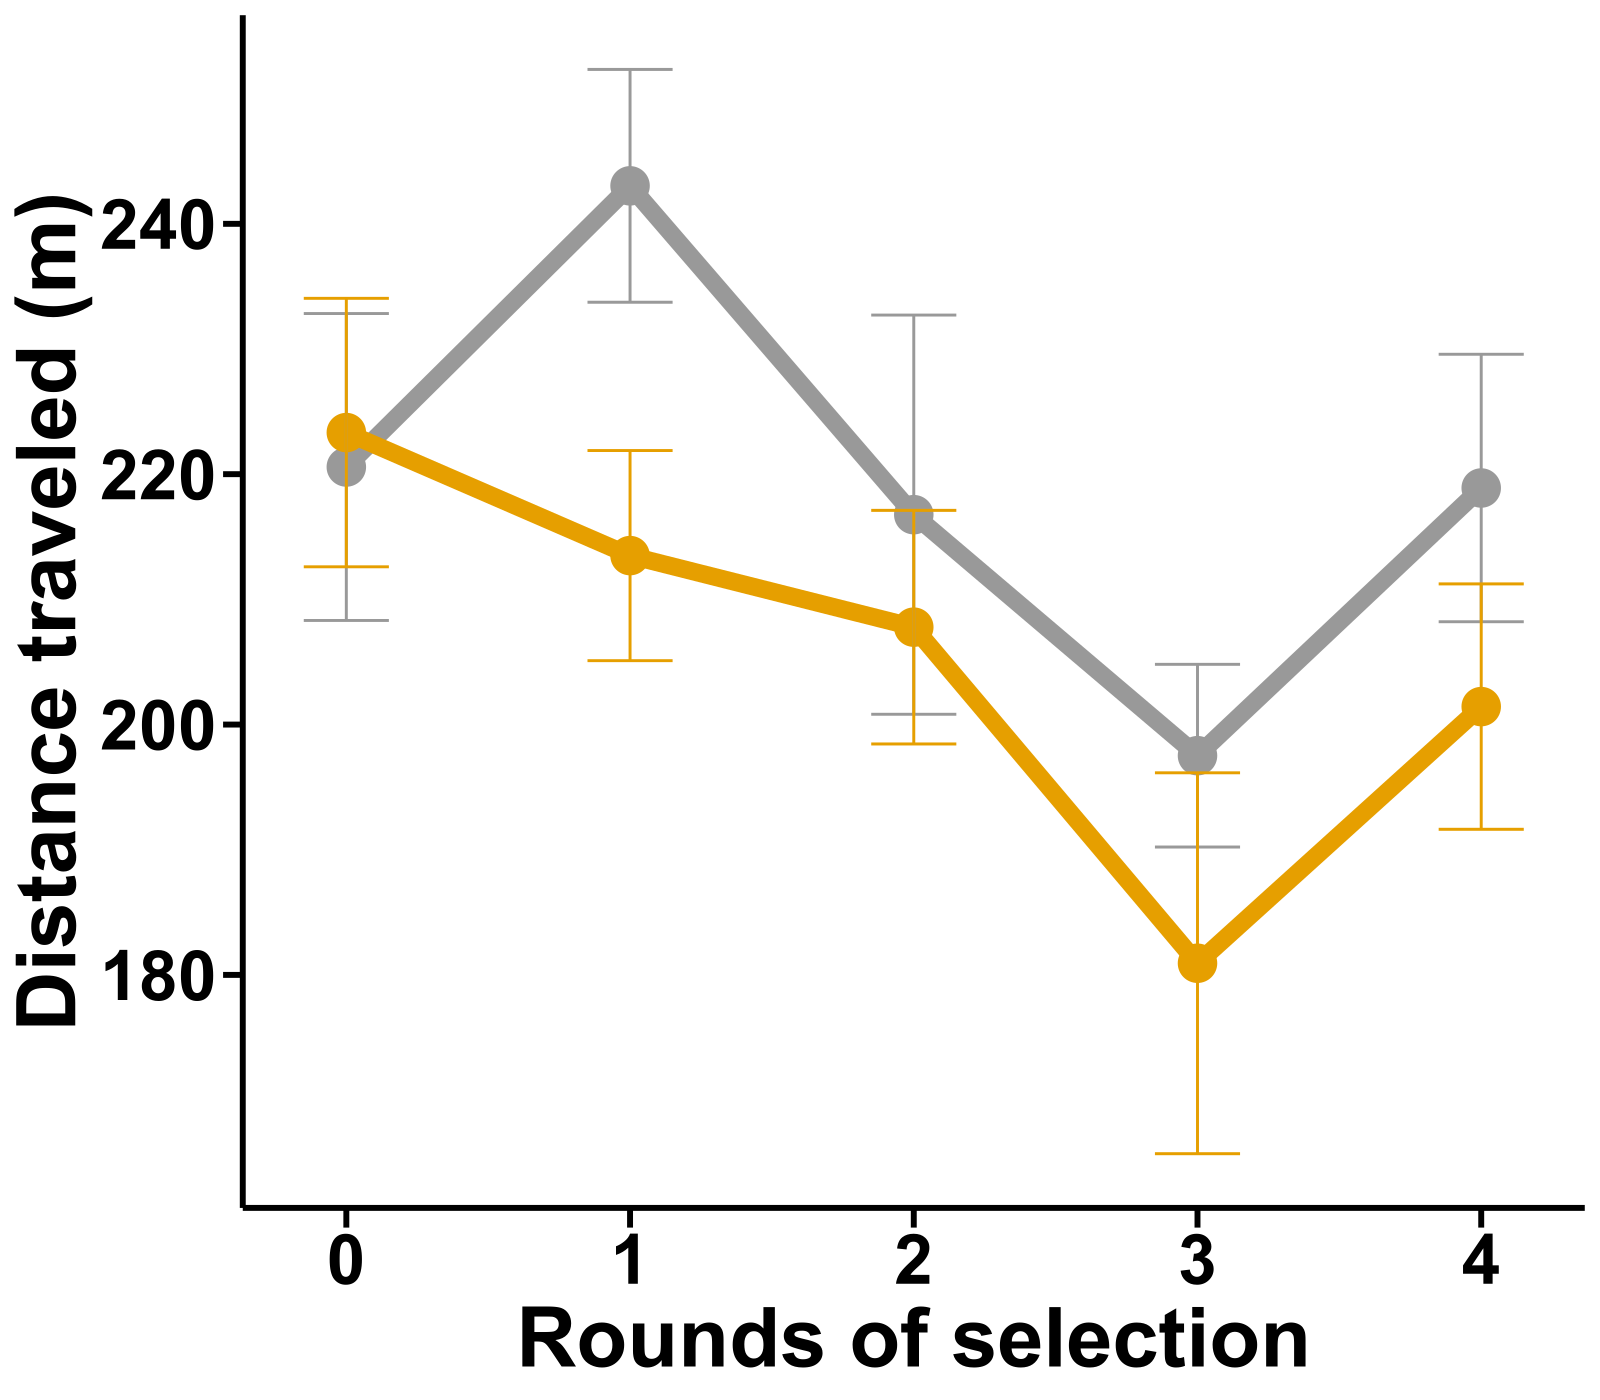

In [9]:
#Subset
Master_data2 <- Master_data1 %>% select(Treatment2, PedMeters_ALL)

#Calculate basic stats for plotting
Master_data2_summary = Master_data2 %>%
  group_by(Treatment2) %>%
  summarise_all(., funs(mean = mean(., na.rm = TRUE), median(., na.rm = TRUE), max(., na.rm = TRUE), min(., na.rm = TRUE), sd = sd(., na.rm = TRUE), se = sd(.)/sqrt(length(.)), var(., na.rm = TRUE) )) %>%
  slice(match(c("C_N1", "C_N2", "C_N3", "C_N4", "C_N5", "T_N1", "T_N2","T_N3", "T_N4", "T_N5" ), Treatment2))

#Add generation and treatment for plotting
Master_data2_summary$Generation = c(0,1,2,3,4,0,1,2,3,4)
Master_data2_summary$Treatment = c("Control","Control","Control","Control","Control","Selection","Selection","Selection","Selection","Selection")

#View(Master_data2_summary)

p.dims(8, 7)
#plot
ggplot(Master_data2_summary, aes(x = Generation, y = median, group = Treatment, color = Treatment)) +
  geom_line(size = 3) +
  geom_point(size = 6) +
  geom_errorbar(aes(ymin=median-se, ymax=median+se), width = .3) +
  scale_color_manual(values = c('#999999','#E69F00')) +
  xlab("Rounds of selection") +
  ylab("Distance traveled (m)") +
  theme_classic() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), 
        axis.line = element_line(size = 1, colour = "black"), 
        axis.text = element_text(face="bold", size = 25, colour="black"), 
        axis.title = element_text(face="bold", size = 30, colour="black"),
        axis.ticks = element_line(color = "black", size=1),
        axis.ticks.length = unit(.25, "cm"),
        legend.position = "none"        
        ) 


## Fig. 2B stats

In [10]:
#Function to save residuals that was used in the model comparison 
Save_residuals = function(input_file, category1, category2){
#Extract rows by categories (e.g. C_N1, C_N5)   
filtered_data = input_file %>% filter(Treatment2 == category1 | Treatment2 == category2)

#Log transform, scale, and center 
filtered_data$PedMeters_ALL_log = scale(log(filtered_data$PedMeters_ALL),center = TRUE, scale = TRUE) 
filtered_data$BW_3_4w_log = scale(log(filtered_data$BW_3_4w), center = TRUE, scale = TRUE)

#Model comparisons
PedMeters_partial_model <- lmer(PedMeters_ALL_log ~ BW_3_4w_log + (1|Batch), data = filtered_data)

#Store residuals
filtered_data$PedMeters_partial_model_resid = resid(PedMeters_partial_model)

#Subset the data
filtered_data2 <- filtered_data %>% select(Treatment2, PedMeters_partial_model_resid)

#write
name <- paste(category1, category2, "df", sep = "_")
assign(name, filtered_data2, envir = .GlobalEnv)
}

#Save residuals 
Save_residuals(Master_data1, "T_N1", "T_N2")
Save_residuals(Master_data1, "T_N1", "T_N3")
Save_residuals(Master_data1, "T_N1", "T_N4")
Save_residuals(Master_data1, "T_N1", "T_N5")
Save_residuals(Master_data1, "C_N1", "C_N2")
Save_residuals(Master_data1, "C_N1", "C_N3")
Save_residuals(Master_data1, "C_N1", "C_N4")
Save_residuals(Master_data1, "C_N1", "C_N5")

#Combine all df into one (note that C_N1 and T_N1 are calculated from all 4 replicates)
residuals_df = data.frame(rbind(C_N1_C_N2_df, C_N1_C_N3_df, C_N1_C_N4_df, C_N1_C_N5_df, T_N1_T_N2_df, T_N1_T_N3_df, T_N1_T_N4_df, T_N1_T_N5_df))

#Summarize the data for plotting
residual_summary = residuals_df %>%
  group_by(Treatment2) %>%
  summarise_all(., funs(mean = mean(., na.rm = TRUE), median(., na.rm = TRUE), max(., na.rm = TRUE), min(., na.rm = TRUE), sd = sd(., na.rm = TRUE), se = sd(.)/sqrt(length(.)))) %>%
  slice(match(c("C_N1", "C_N2", "C_N3", "C_N4", "C_N5", "T_N1", "T_N2","T_N3", "T_N4", "T_N5" ), Treatment2))
#View(residual_summary)

#Add generation and treatment for plotting
residual_summary$Generation = c(0,1,2,3,4,0,1,2,3,4)
residual_summary$Treatment = c("Control","Control","Control","Control","Control","Selection","Selection","Selection","Selection","Selection")

boundary (singular) fit: see help('isSingular')

Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
ℹ Please use a list of either functions or lambdas:

# Simple named list: list(mean = mean, median = median)

# Auto named with `tibble::lst()`: tibble::lst(mean, median)

# Using lambdas list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))”


## Fig. 2B (residuals)

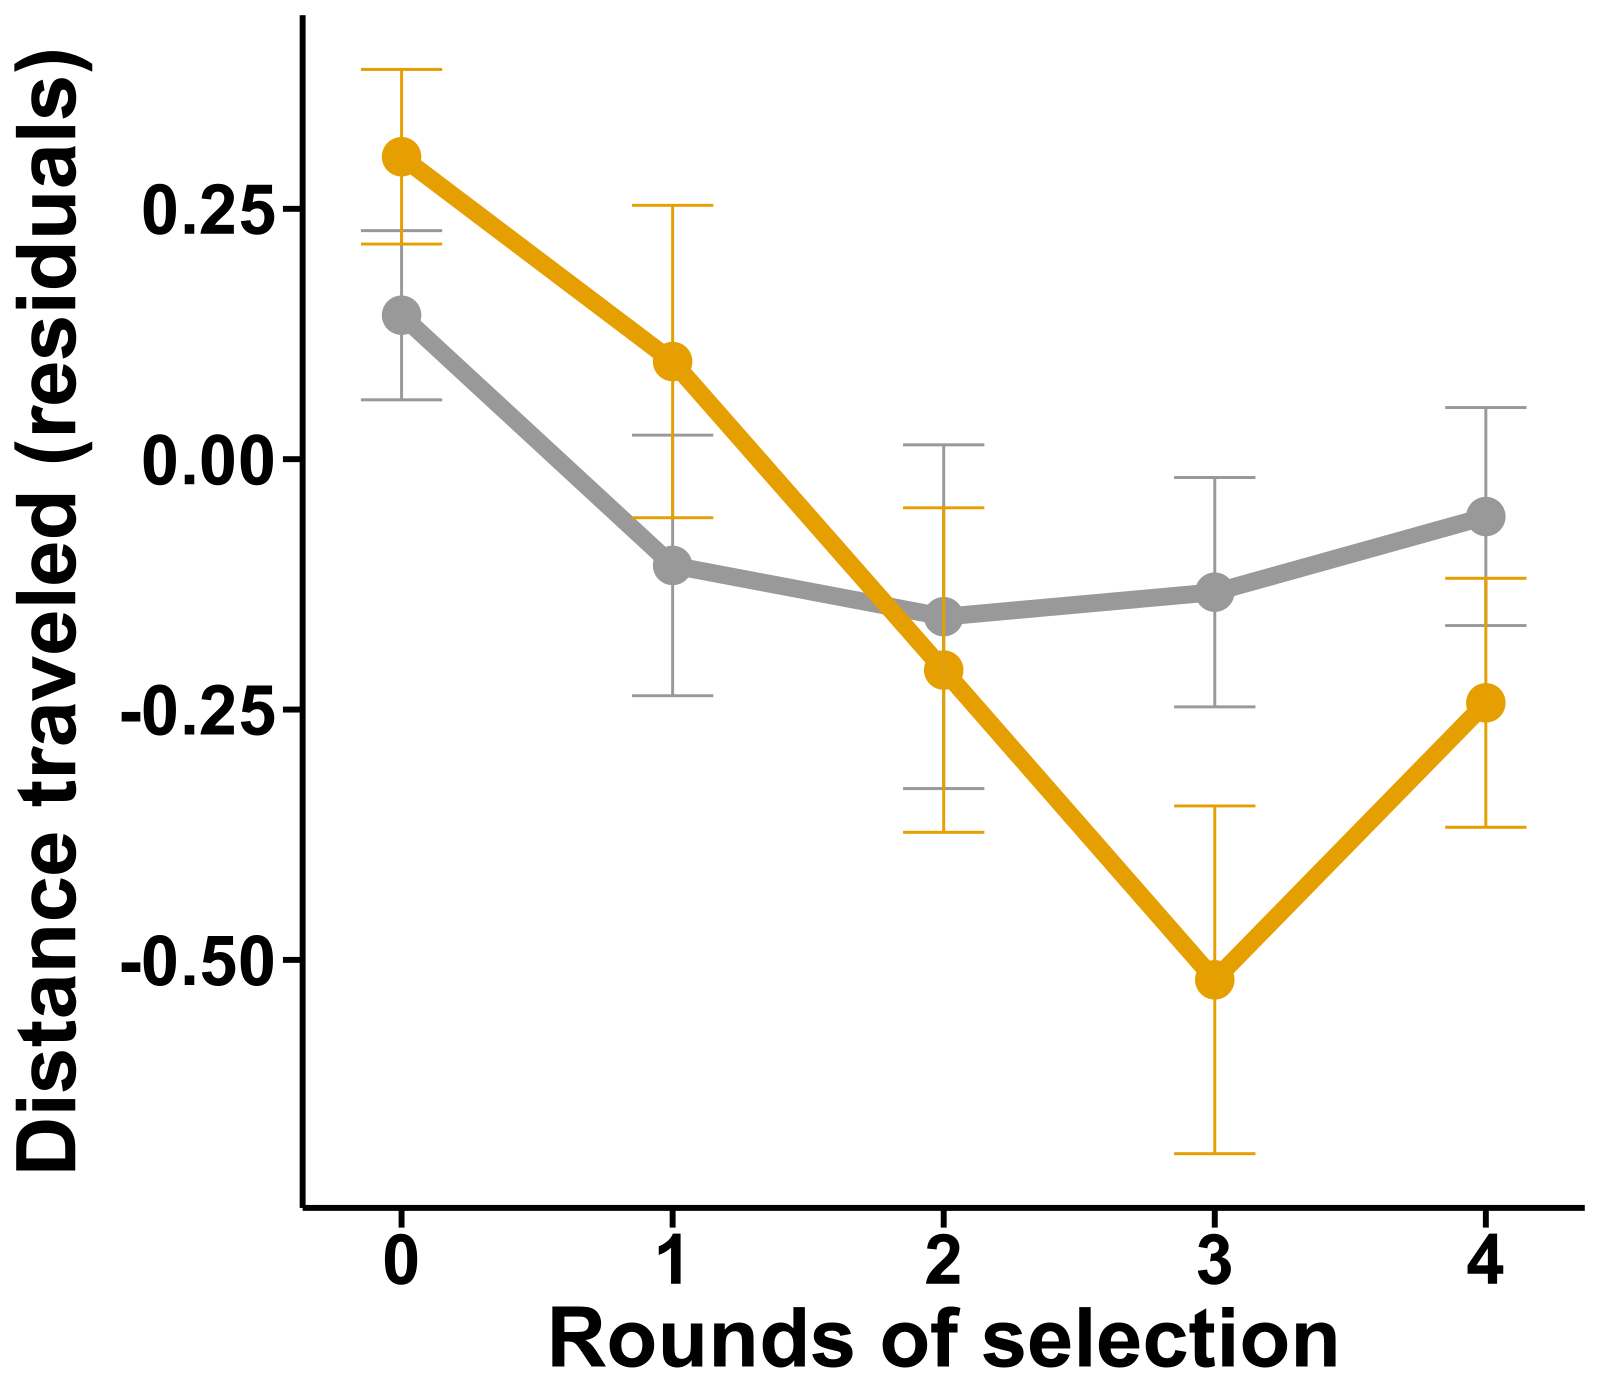

In [11]:
p.dims(8, 7)
#plot
ggplot(residual_summary, aes(x = Generation, y = median, group = Treatment, color = Treatment)) +
  geom_line(size = 3, show.legend = FALSE) +
  geom_point(size = 6, show.legend = FALSE) +
  geom_errorbar(aes(ymin=median-se, ymax=median+se), width = .3, show.legend = FALSE) +
  scale_color_manual(values = c('#999999','#E69F00')) +
  xlab("Rounds of selection") +
  ylab("Distance traveled (residuals)") +
  theme_classic() +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), 
        axis.line = element_line(size = 1, colour = "black"), 
        axis.text = element_text(face="bold", size = 25, colour="black"), 
        axis.title = element_text(face="bold", size = 30, colour="black"),
        axis.ticks = element_line(color = "black", size=1),
        axis.ticks.length = unit(.25, "cm"),
        legend.position = "none"
        ) 

## Fig. 2C (stats)

In [12]:
#data input
#output_dir = "/ebio/abt3_projects/Bifido_Coevolution/Metabolic_cage_tmp/lmtest_out/Selection_exp/out_log_BW3_Batch_Pedm3/"
output_dir = "../out/Selection_exp/"

if (!dir.exists(output_dir)) {
  dir.create(output_dir, recursive = TRUE)
}

#Control vs Selection by generation
model_compare_lmtest_BW_3w_Batch_selection_exp1(Master_data1, "C_N1", "T_N1", output_dir)
model_compare_lmtest_BW_3w_Batch_selection_exp1(Master_data1, "C_N2", "T_N2", output_dir)
model_compare_lmtest_BW_3w_Batch_selection_exp1(Master_data1, "C_N3", "T_N3", output_dir)
model_compare_lmtest_BW_3w_Batch_selection_exp1(Master_data1, "C_N4", "T_N4", output_dir)
model_compare_lmtest_BW_3w_Batch_selection_exp1(Master_data1, "C_N5", "T_N5", output_dir)

#N1 vs NX
#control line
model_compare_lmtest_BW_3w_Batch_selection_exp1(Master_data1, "C_N1", "C_N2", output_dir)
model_compare_lmtest_BW_3w_Batch_selection_exp1(Master_data1, "C_N1", "C_N3", output_dir)
model_compare_lmtest_BW_3w_Batch_selection_exp1(Master_data1, "C_N1", "C_N4", output_dir)
model_compare_lmtest_BW_3w_Batch_selection_exp1(Master_data1, "C_N1", "C_N5", output_dir)
#selection line
model_compare_lmtest_BW_3w_Batch_selection_exp1(Master_data1, "T_N1", "T_N2", output_dir)
model_compare_lmtest_BW_3w_Batch_selection_exp1(Master_data1, "T_N1", "T_N3", output_dir)
model_compare_lmtest_BW_3w_Batch_selection_exp1(Master_data1, "T_N1", "T_N4", output_dir) 
model_compare_lmtest_BW_3w_Batch_selection_exp1 (Master_data1, "T_N1", "T_N5", output_dir) 

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')



## Fig. 2C (control)

Warning message:
“A numeric `legend.position` argument in `theme()` was deprecated in ggplot2
3.5.0.
ℹ Please use the `legend.position.inside` argument of `theme()` instead.”


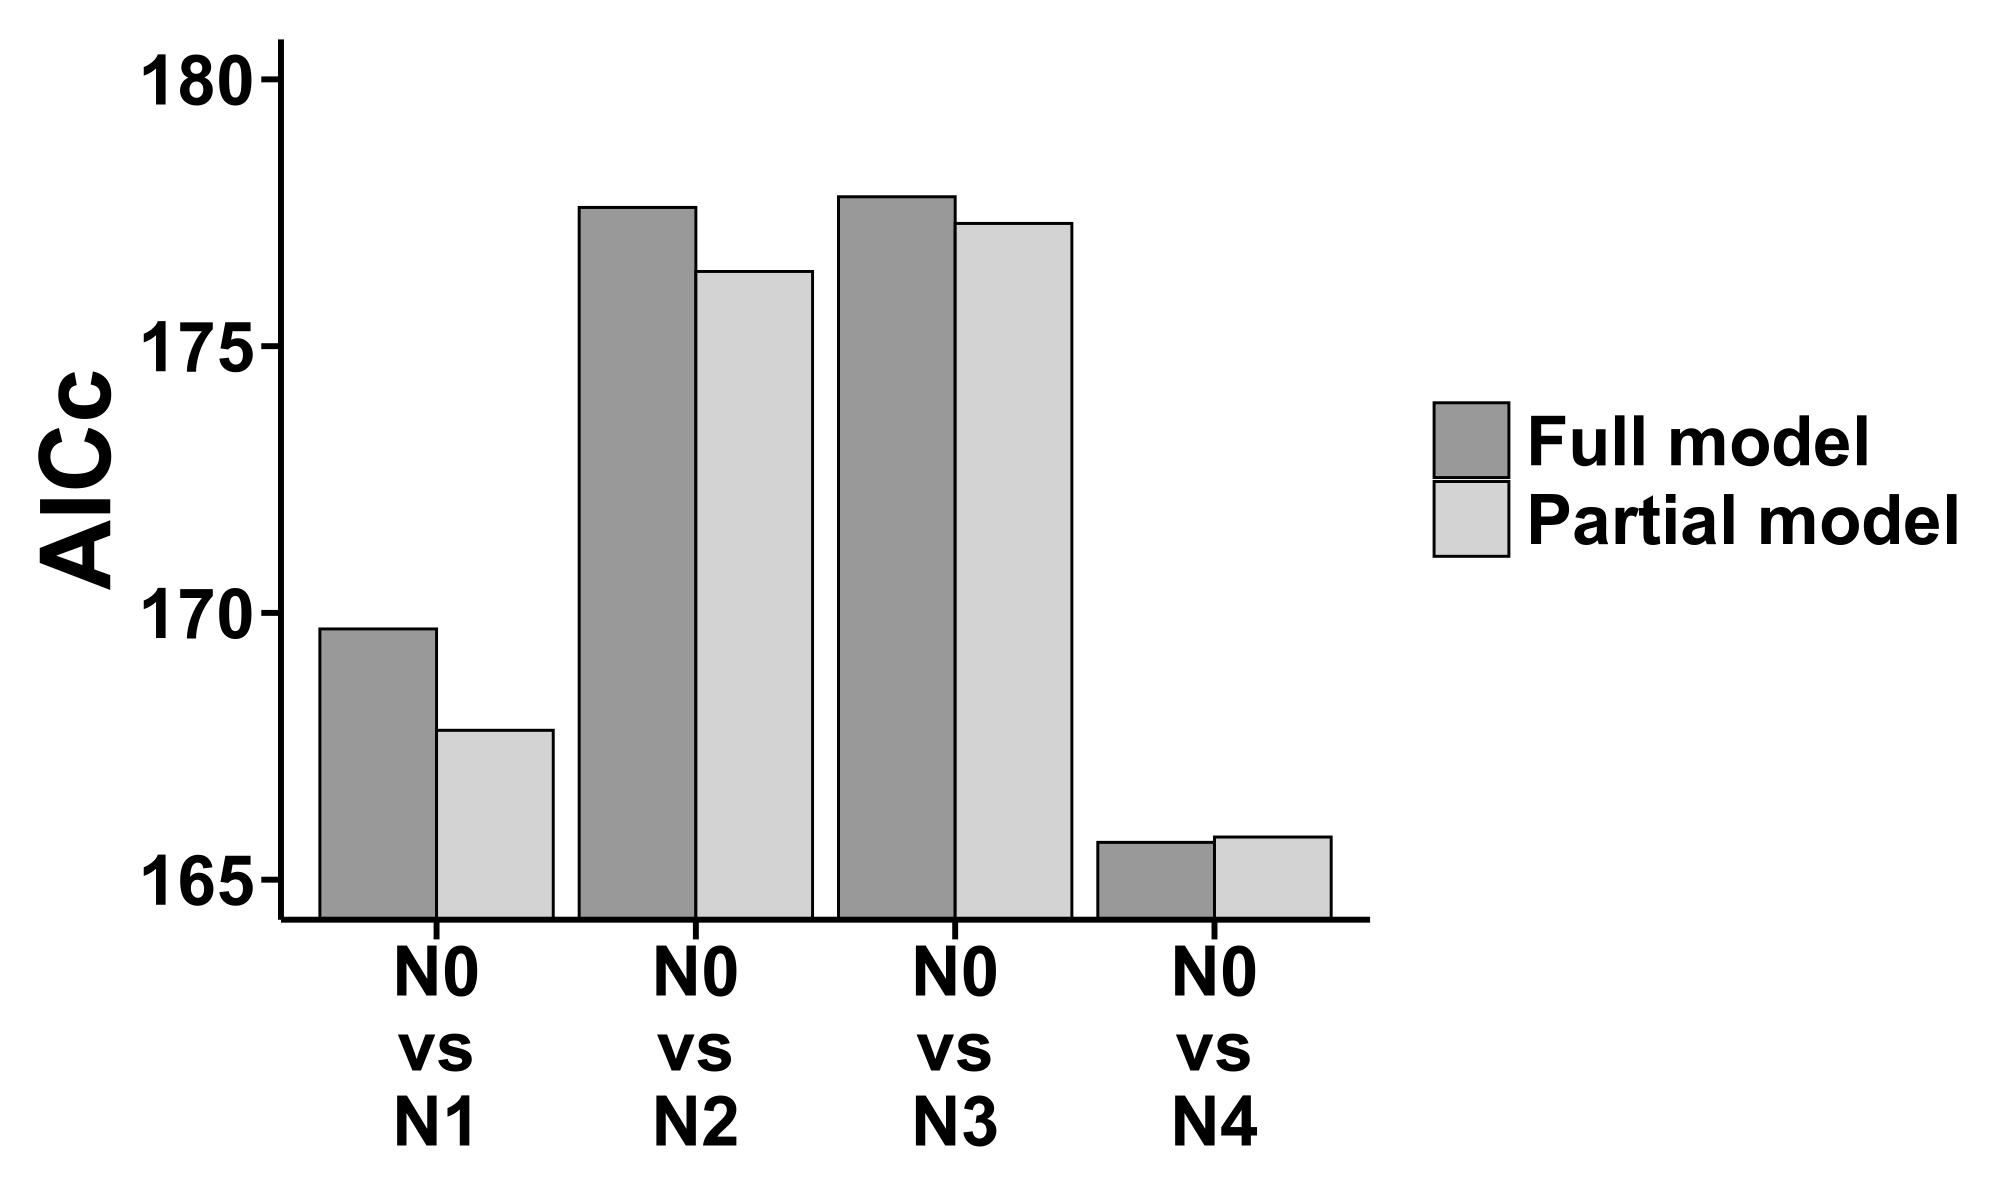

In [13]:
AICc$Comparison = c("N0 vs N1","N0 vs N2","N0 vs N3","N0 vs N4","N0 vs N1","N0 vs N2","N0 vs N3","N0 vs N4")

p.dims(10, 6)
ggplot(data = AICc, aes(x = Comparison, y = AICc_control, fill = Control)) +
  geom_bar(stat = "identity", color = "black", position = 'dodge')  +
  scale_fill_manual(labels = c("Full model", "Partial model"), values=c('#999999','#D3D3D3', '#999999','#D3D3D3', '#999999','#D3D3D3', '#999999','#D3D3D3')) +
  scale_x_discrete(labels = function(x) str_wrap(x, width = 3)) +
  coord_cartesian(ylim=c(165,180)) +
  labs(y = "AICc") +
  #guides(fill = guide_legend(nrow = 1))+
  theme_classic() +
  theme(axis.text = element_text(face="bold", size = 25, colour="black"), 
        #axis.text.x = element_text(angle = 60, margin = margin(t = 40, r = 0, b = 0, l = 0)),
        axis.title.y = element_text(face="bold", size = 35, colour = "black"),
        axis.title.x =element_blank(),
        axis.line = element_line(colour = "black", size = 1), 
        axis.ticks = element_line(color = "black", size=1),
        axis.ticks.length = unit(.25, "cm"), 
        legend.title = element_blank(),
        legend.key.size = unit(1, 'cm'),
        legend.text = element_text(face="bold", size=25, colour = "black"),
        legend.position=c(1.3,0.5),
        plot.margin=unit(c(0.5,8,0.5,0.5),"cm") #top, right, bottom, left
        ) 

## Fig. 2C (selection)

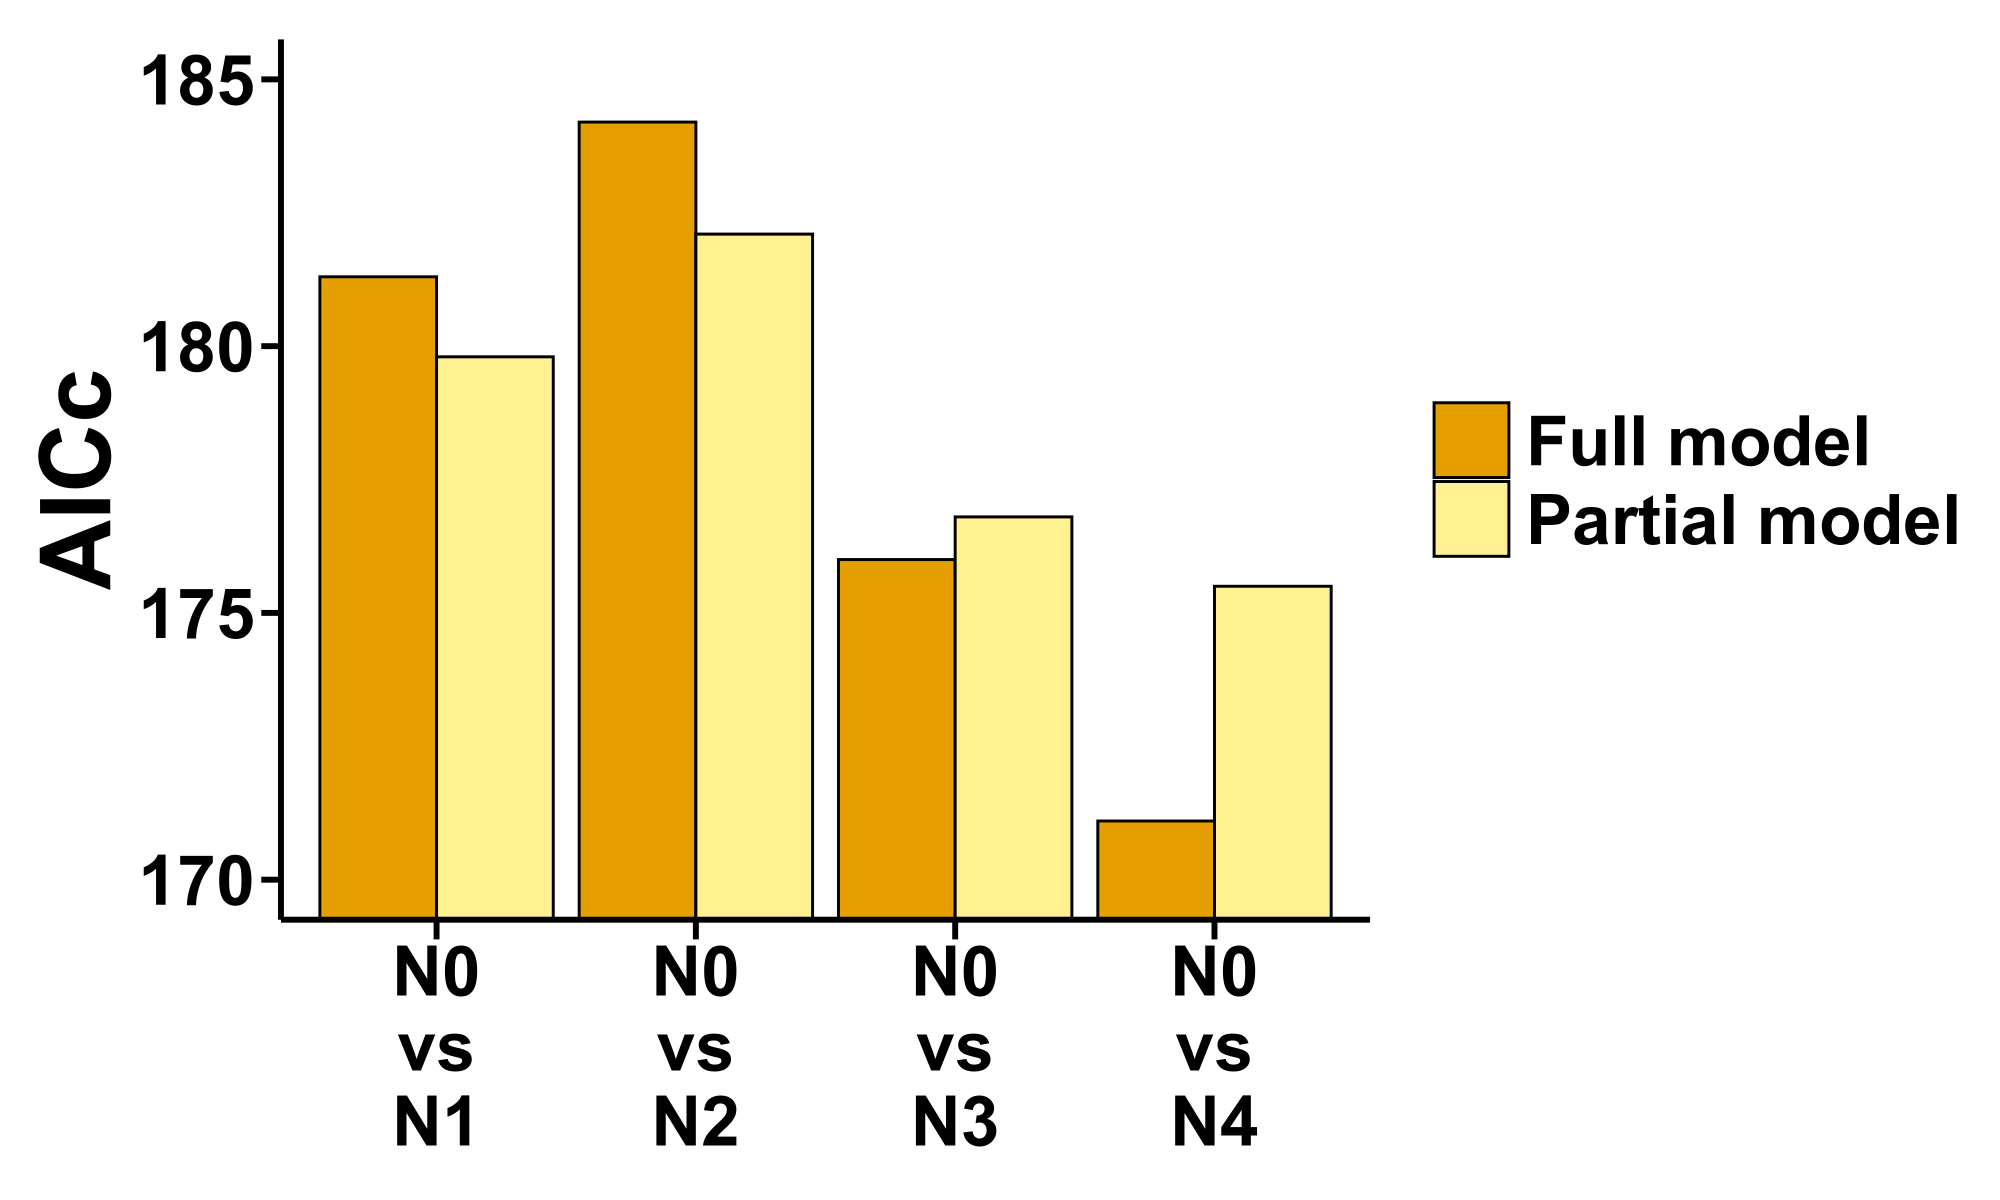

In [14]:
p.dims(10, 6)
ggplot(data = AICc, aes(x = Comparison, y = AICc_selection, fill = Selection)) +
  geom_bar(stat = "identity", color = "black", position = 'dodge')  +
  scale_fill_manual(labels = c("Full model", "Partial model"), values=c('#E69F00','#FFF192', '#E69F00','#FFF192', '#E69F00','#FFF192', '#E69F00','#FFF192')) +
  scale_x_discrete(labels = function(x) str_wrap(x, width = 3)) +
  coord_cartesian(ylim=c(170,185)) +
  labs(y = "AICc") +
  #guides(fill = guide_legend(nrow = 1))+ #make the legend horizontal
  theme_classic() +
  theme(axis.text = element_text(face="bold", size = 25, colour="black"), 
        #axis.text.x = element_text(angle = 60, margin = margin(t = 40, r = 0, b = 0, l = 0)),
        axis.title.y = element_text(face="bold", size = 35, colour = "black"),
        axis.title.x =element_blank(),
        axis.line = element_line(colour = "black", size = 1), 
        axis.ticks = element_line(color = "black", size=1),
        axis.ticks.length = unit(.25, "cm"), 
        legend.title = element_blank(),
        legend.key.size = unit(1, 'cm'),
        legend.text = element_text(face="bold", size=25, colour = "black"),
        legend.position=c(1.3,0.5),
        plot.margin=unit(c(0.5,8,0.5,0.5),"cm") #top, right, bottom, left
        ) 
       
        #legend.position=c(0.5,-0.42),
        #plot.margin=unit(c(0.5,1,4,0.5),"cm") #top, right, bottom, left

# Supplemental figures and stats

## Fig. S1A

Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
ℹ Please use a list of either functions or lambdas:

# Simple named list: list(mean = mean, median = median)

# Auto named with `tibble::lst()`: tibble::lst(mean, median)

# Using lambdas list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))”
Warning message:
“There were 8 warnings in `summarise()`.
The first warning was:
ℹ In argument: `BW_5w_max = max(BW_5w, na.rm = TRUE)`.
ℹ In group 1: `ALL = "BR_donor"`.
Caused by warning in `max()`:
! no non-missing arguments to max; returning -Inf
ℹ Run `dplyr::last_dplyr_warnings()` to see the 7 remaining warnings.”


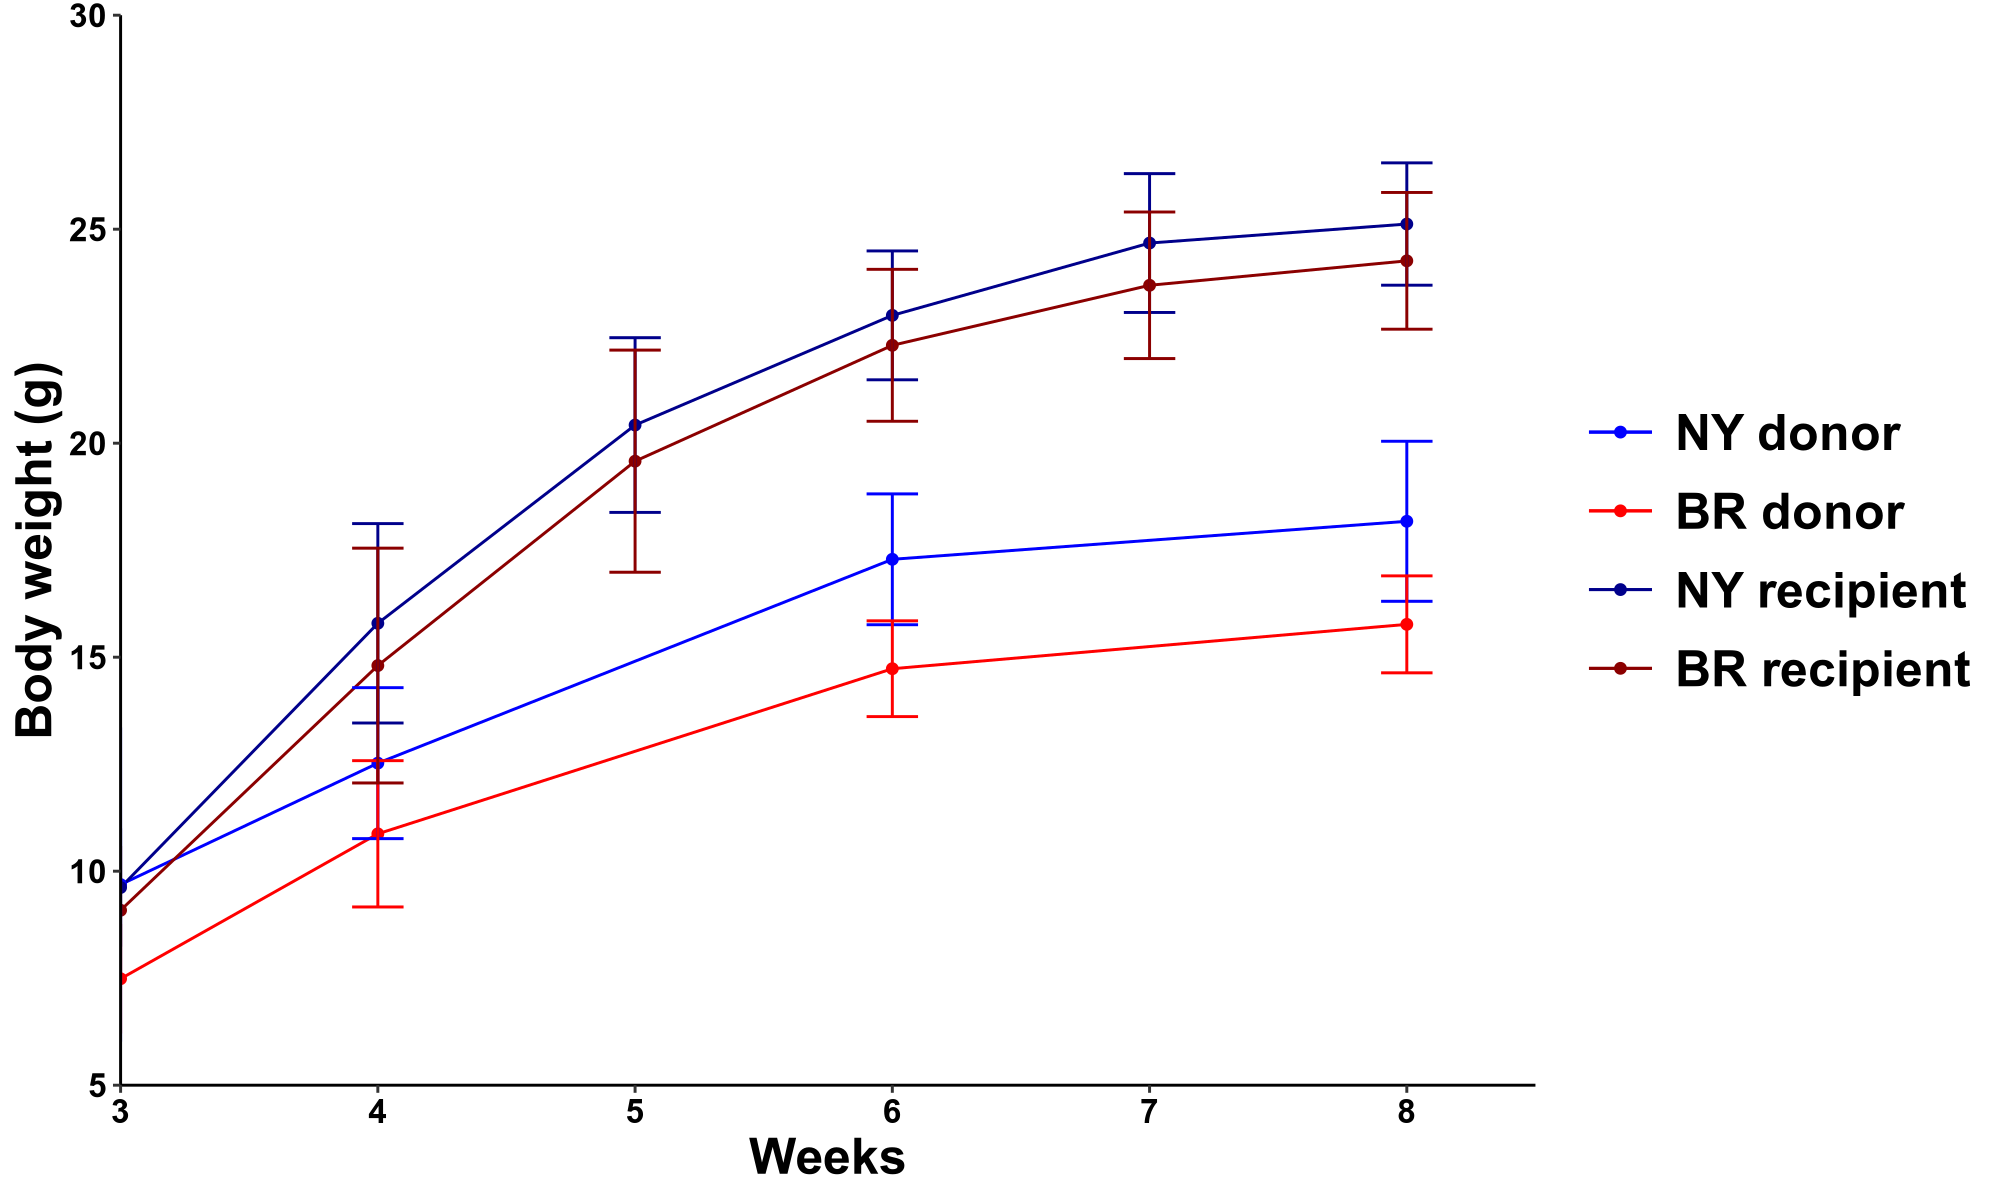

In [15]:

Master_data_filtered <- Master_data_pilot2_v3 %>% select(ALL, BW_3w, BW_4w, BW_5w, BW_6w, BW_7w, BW_8w) 

#head(Master_data_pilot3)

Master_data_filtered2 = Master_data_filtered %>%
  group_by(ALL) %>%
  summarise_all(., funs(mean = mean(., na.rm = TRUE), median(., na.rm = TRUE), max(., na.rm = TRUE), min(., na.rm = TRUE), sd = sd(., na.rm = TRUE))) %>%
  slice(match(c("NY_donor", "BR_donor", "GFNY", "GFBR"), ALL))

#Transpose
Master_data_filtered3 = t(Master_data_filtered2)

#change 1st row to header
colnames(Master_data_filtered3) = Master_data_filtered3[1,]

#Delete first two rows
Master_data_filtered3 = Master_data_filtered3[-1,]
Master_data_filtered3 = as.data.frame(Master_data_filtered3)

#split column name to columns
Master_data_filtered4 = cbind(Master_data_filtered3, read.table(text=row.names(Master_data_filtered3), sep="_", 
          header=FALSE, col.names = (c("trait", "weeks", "stats")), stringsAsFactors=FALSE))

#find and replace
Master_data_filtered4$weeks <- gsub('w', '', Master_data_filtered4$weeks)

#Drop columns
Master_data_filtered4 <- Master_data_filtered4[-c(5)]

#Change selected column as numeric
Master_data_filtered4[1:5] = lapply(Master_data_filtered4[1:5], FUN = function(y){as.numeric(y)})
#str(Master_data_filtered4)

#Rearrange table
Master_data_filtered5 = reshape2::melt(Master_data_filtered4, id.vars = c("weeks", "stats"))
Master_data_filtered6 = spread(Master_data_filtered5, stats, value)

#View(Master_data_filtered6)

p.dims(10, 6)
#ggplot
ggplot(na.omit(Master_data_filtered6),
       aes(x = weeks, y = mean, col = variable)) + 
  geom_line() +
  geom_point() + 
  geom_errorbar(aes(ymin=mean-sd, ymax=mean+sd), width=.2) +
  scale_color_manual(name = "Treatment", labels = c("NY donor", "BR donor", "NY recipient", "BR recipient"), values=c('blue', 'red', "blue4", "red4")) + 
  xlab("Weeks") + 
  ylab("Body weight (g)") +
  scale_x_continuous(limits=c(3, 8.5), breaks = seq(3, 8.5, 1), expand = c(0, 0)) + 
  scale_y_continuous(limits=c(5,30), breaks=seq(5, 30, 5), expand = c(0, 0)) +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), 
        axis.line = element_line(colour = "black"), 
        axis.text = element_text(face="bold", size = 12, colour="black"), 
        axis.title = element_text(face="bold", size = 18),
        legend.key.size = unit(1, 'cm'),
        legend.key = element_blank(), 
        legend.title=element_blank(),
        legend.text = element_text(face="bold", size = 18)) 

## Fig. S1B

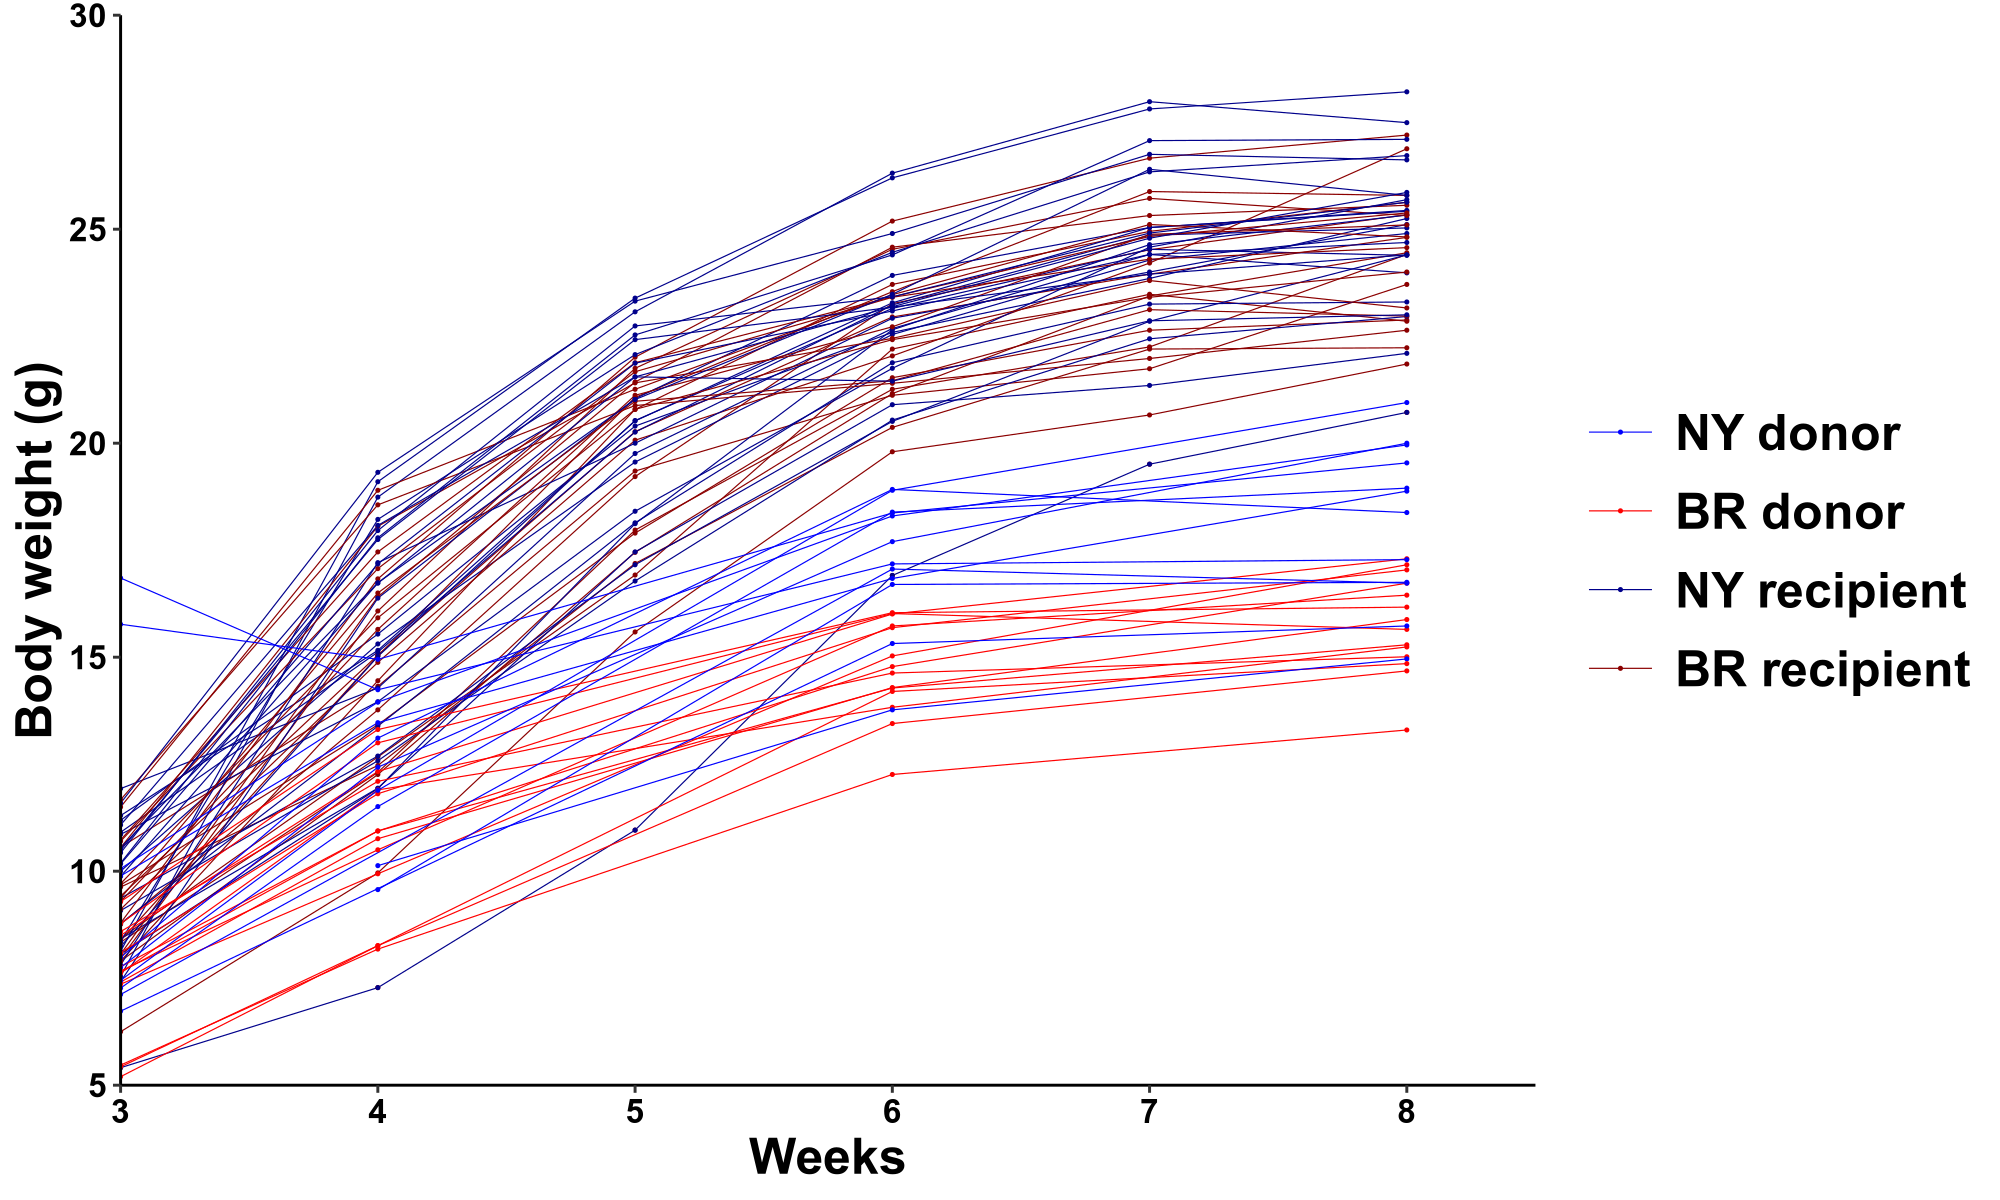

In [16]:


#Subset table and rename
BW_data = Master_data_pilot[, c("UniqueID2","BW_3w","BW_4w","BW_5w","BW_6w","BW_7w","BW_8w")]
#View(BW_data)

#Transpose
BW_data2 = t(BW_data)
#View(BW_data2)

#change 1st row to header
colnames(BW_data2) = BW_data2[1,]

#Delete first two rows
BW_data2 = BW_data2[-1,]
BW_data2 = as.data.frame(BW_data2)

#Change all column as numeric
BW_data2[1:76] = lapply(BW_data2[1:76], FUN = function(y){as.numeric(y)})

#Add vector for "weeks"
BW_data2$Weeks <- c(3,4,5,6,7,8)  
#str(BW_data2)

#Table with long format
BW_data2_long = reshape2::melt(BW_data2, id.vars = "Weeks")
#View(BW_data2_long)
colnames(BW_data2_long)[2] = "ID"

#Add group as a new column
ID_group = Master_data_pilot[, c("UniqueID2","ALL")]
colnames(ID_group)[1] = "ID"
colnames(ID_group)[2] = "Group"
BW_data2_long2 = merge(BW_data2_long, ID_group, by = "ID")
BW_data2_long2$Group = factor(BW_data2_long2$Group, levels=c("GFNY", "GFBR", "NY_donor", "BR_donor"))


#Plot individual data points
#ggplot
ggplot(na.omit(BW_data2_long2),
       aes(x = Weeks, y = value, group = factor(ID), colour = factor(Group))) + 
  geom_line(size = 0.2) +
  geom_point(size = 0.2) + 
  scale_color_manual(name = "Treatment",
                     breaks = c("NY_donor", "BR_donor", "GFNY", "GFBR"), 
                     labels = c("NY donor", "BR donor", "NY recipient", "BR recipient"), 
                     values=c('blue', 'red', "blue4", "red4")) +
  xlab("Weeks") + ylab("Body weight (g)") +
  scale_x_continuous(limits=c(3, 8.5), breaks = seq(3, 8.5, 1), expand = c(0, 0)) + 
  scale_y_continuous(limits=c(5,30), breaks=seq(5, 30, 5), expand = c(0, 0)) +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), 
        axis.line = element_line(colour = "black"), 
        axis.text = element_text(face="bold", size = 12, colour="black"), 
        axis.title = element_text(face="bold", size = 18),
        legend.key.size = unit(1, 'cm'),
        legend.key = element_blank(), 
        legend.title=element_blank(),
        legend.text = element_text(face="bold", size = 18)) 

## Fig. S2A

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 8 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 8 rows containing missing values or values outside the scale range
(`geom_point()`).”


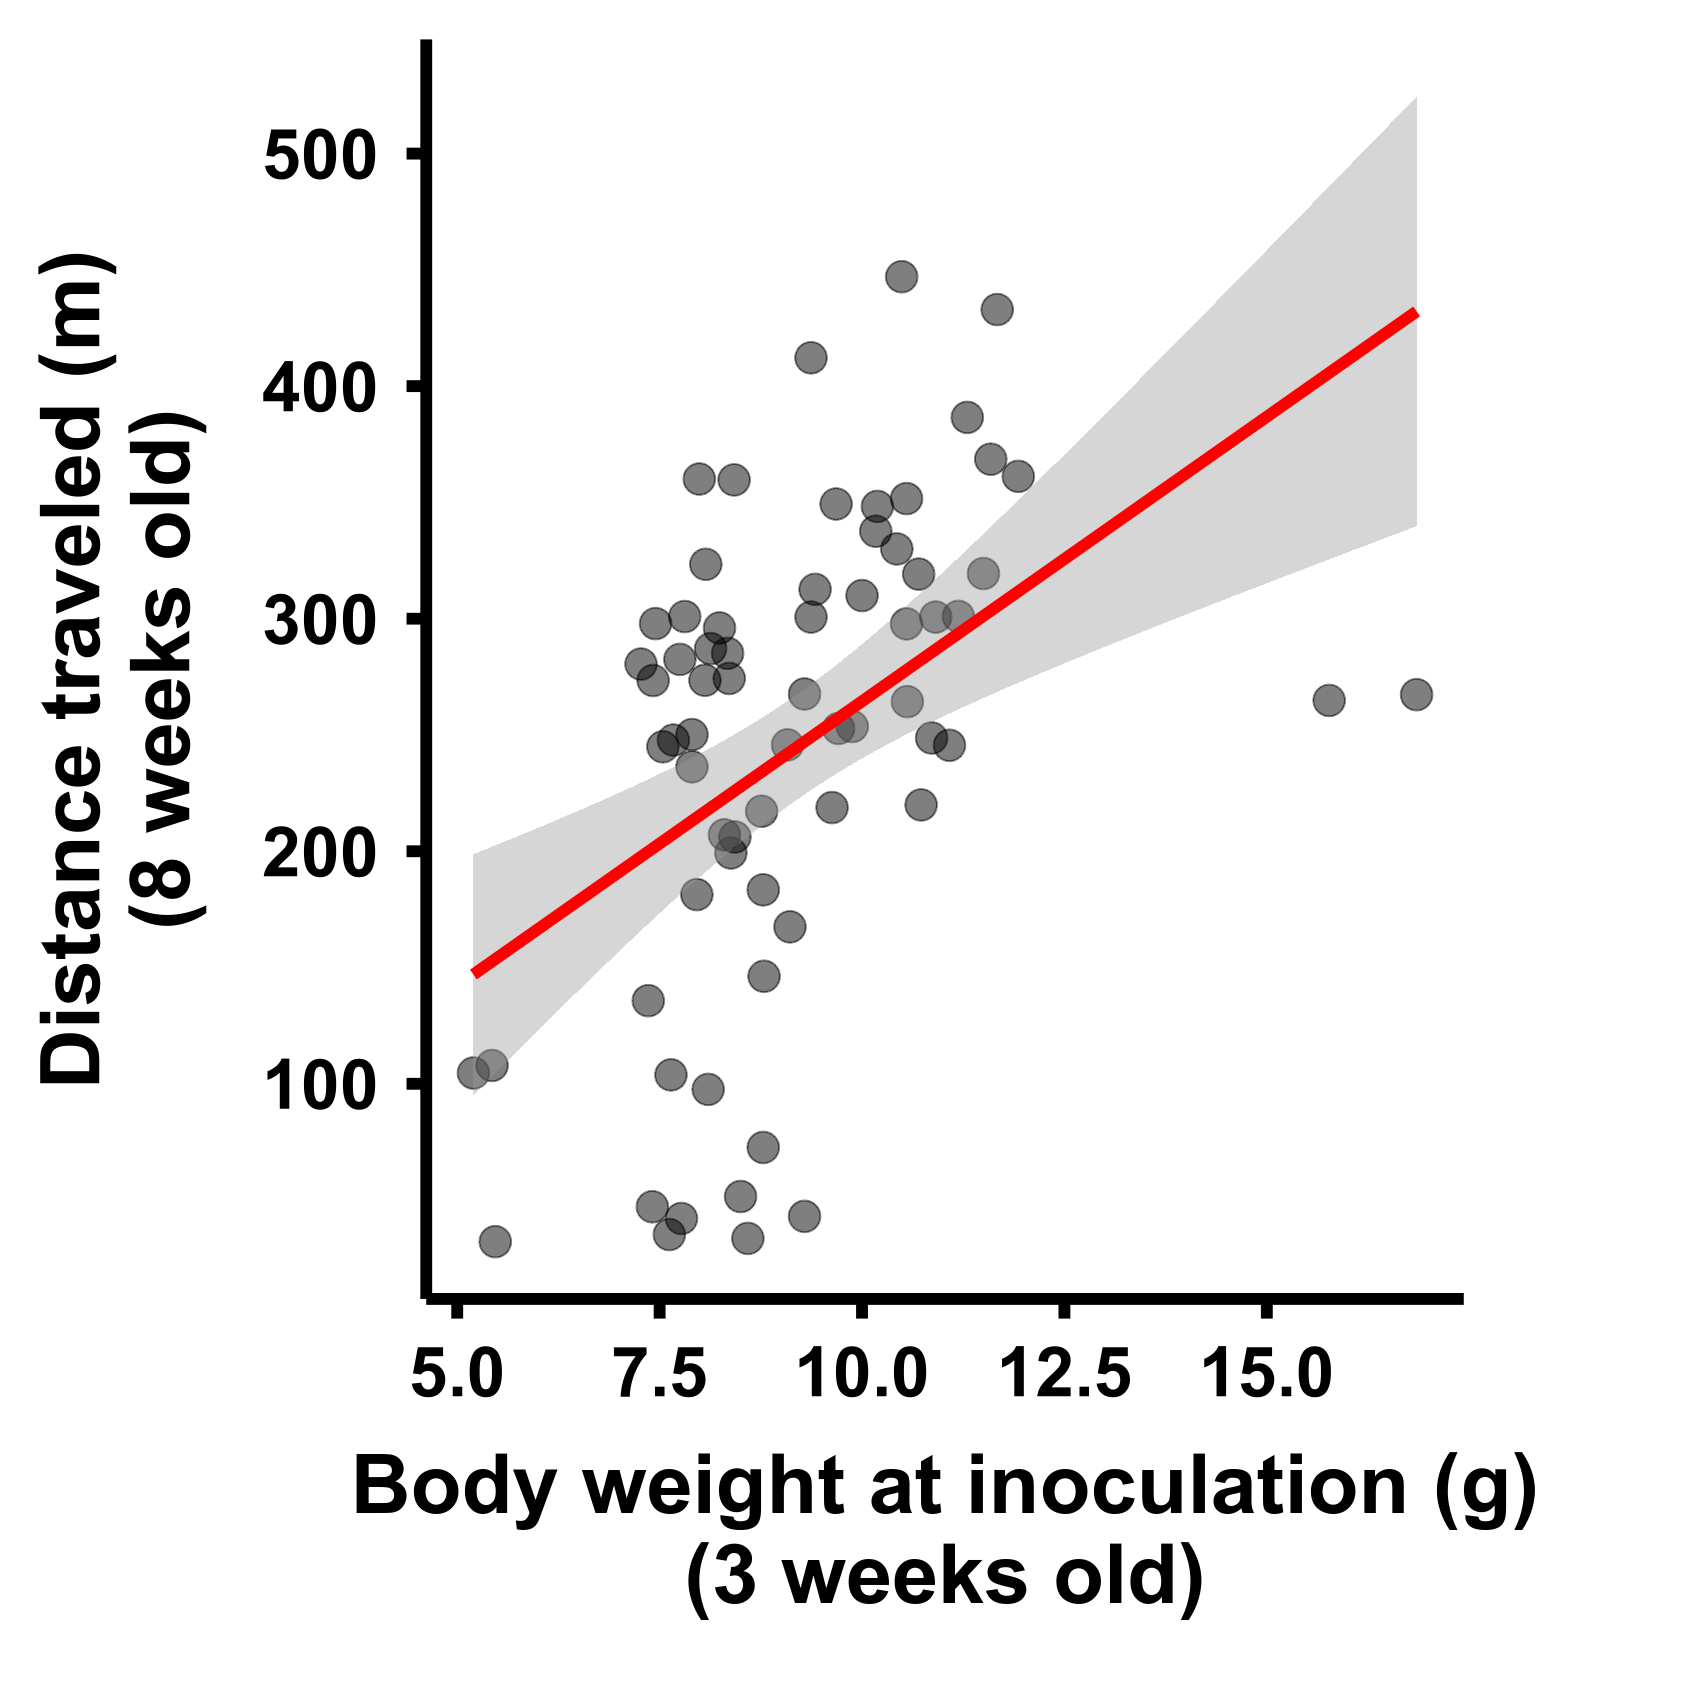

In [17]:

Master_data_pilot3 <- Master_data_pilot2 %>% select(ALL, RQ_48hours, RQ_24hours_1, RQ_5h_Day1, kcal_hr_48hours, kcal_hr_24hours_1, kcal_hr_5h_Day1, food_48hours, food_24hours_1, food_5h_Day1, water_48hours, water_24hours_1, water_5h_Day1,xbreak_48hours, xbreak_24hours_1, xbreak_5h_Day1, ybreak_48hours, ybreak_24hours_1, ybreak_5h_Day1, zbreak_48hours, zbreak_24hours_1, zbreak_5h_Day1, ped_m_48hours, ped_m_24hours_1, ped_m_5h_Day1, all_m_48hours, all_m_24hours_1, all_m_5h_Day1, BW_3w, BW_4w, BW_5w, BW_6w, BW_7w, BW_8w, BW_8w_final, fat_4w, fat_6w, fat_8w, lean_4w, lean_6w, lean_8w, F.water_4w, F.water_6w, F.water_8w, T.water_4w, T.water_6w, T.water_8w, TBL, TL, EL, HFL, BL, Small_Int_mm, Small_Int_g, Cecum_mm, Cecum_g, Large_int_mm, Large_int_g, Fat_pad) 

#cor.test(Master_data_pilot3$ped_m_24hours_1, Master_data_pilot3$BW_3w, method = "spearman") #rho = 0.4991077, p = 1.475e-05

p.dims(8.5, 8.5)
ggplot(data = Master_data_pilot3, aes(BW_3w, ped_m_24hours_1)) +
  geom_point(alpha = 0.5, color = "black", size = 5) +
  labs(x = "Body weight at inoculation (g)\n(3 weeks old)", y = "Distance traveled (m)\n(8 weeks old)") +
  geom_smooth(method = lm, color = "red", size = 2) + 
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), 
        axis.line = element_line(colour = "black", size = 2), 
        axis.ticks = element_line(color = "black", size=2),
        axis.ticks.length = unit(.25, "cm"), 
        axis.title = element_text(face="bold", size = 30),
        axis.text = element_text(face="bold", size = 25, colour="black"),
        
        
        axis.text.x = element_text(margin = margin(t = 10, r = 0, b = 0, l = 0)),
        axis.text.y = element_text(margin = margin(t = 0, r = 10, b = 0, l = 0)),
        axis.title.x = element_text(margin = margin(t = 15, r = 0, b = 0, l = 0)),
        axis.title.y = element_text(margin = margin(t = 0, r = 20, b = 0, l = 0)),
  
        legend.key.size = unit(1, 'cm'),
        legend.key = element_blank(), 
        legend.title=element_blank(),
        legend.text = element_text(face="bold", size = 40),
        plot.margin = unit(c(0.5,3,1,0.5),"cm")
        ) 

## Fig. S2B

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 6 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 6 rows containing missing values or values outside the scale range
(`geom_point()`).”


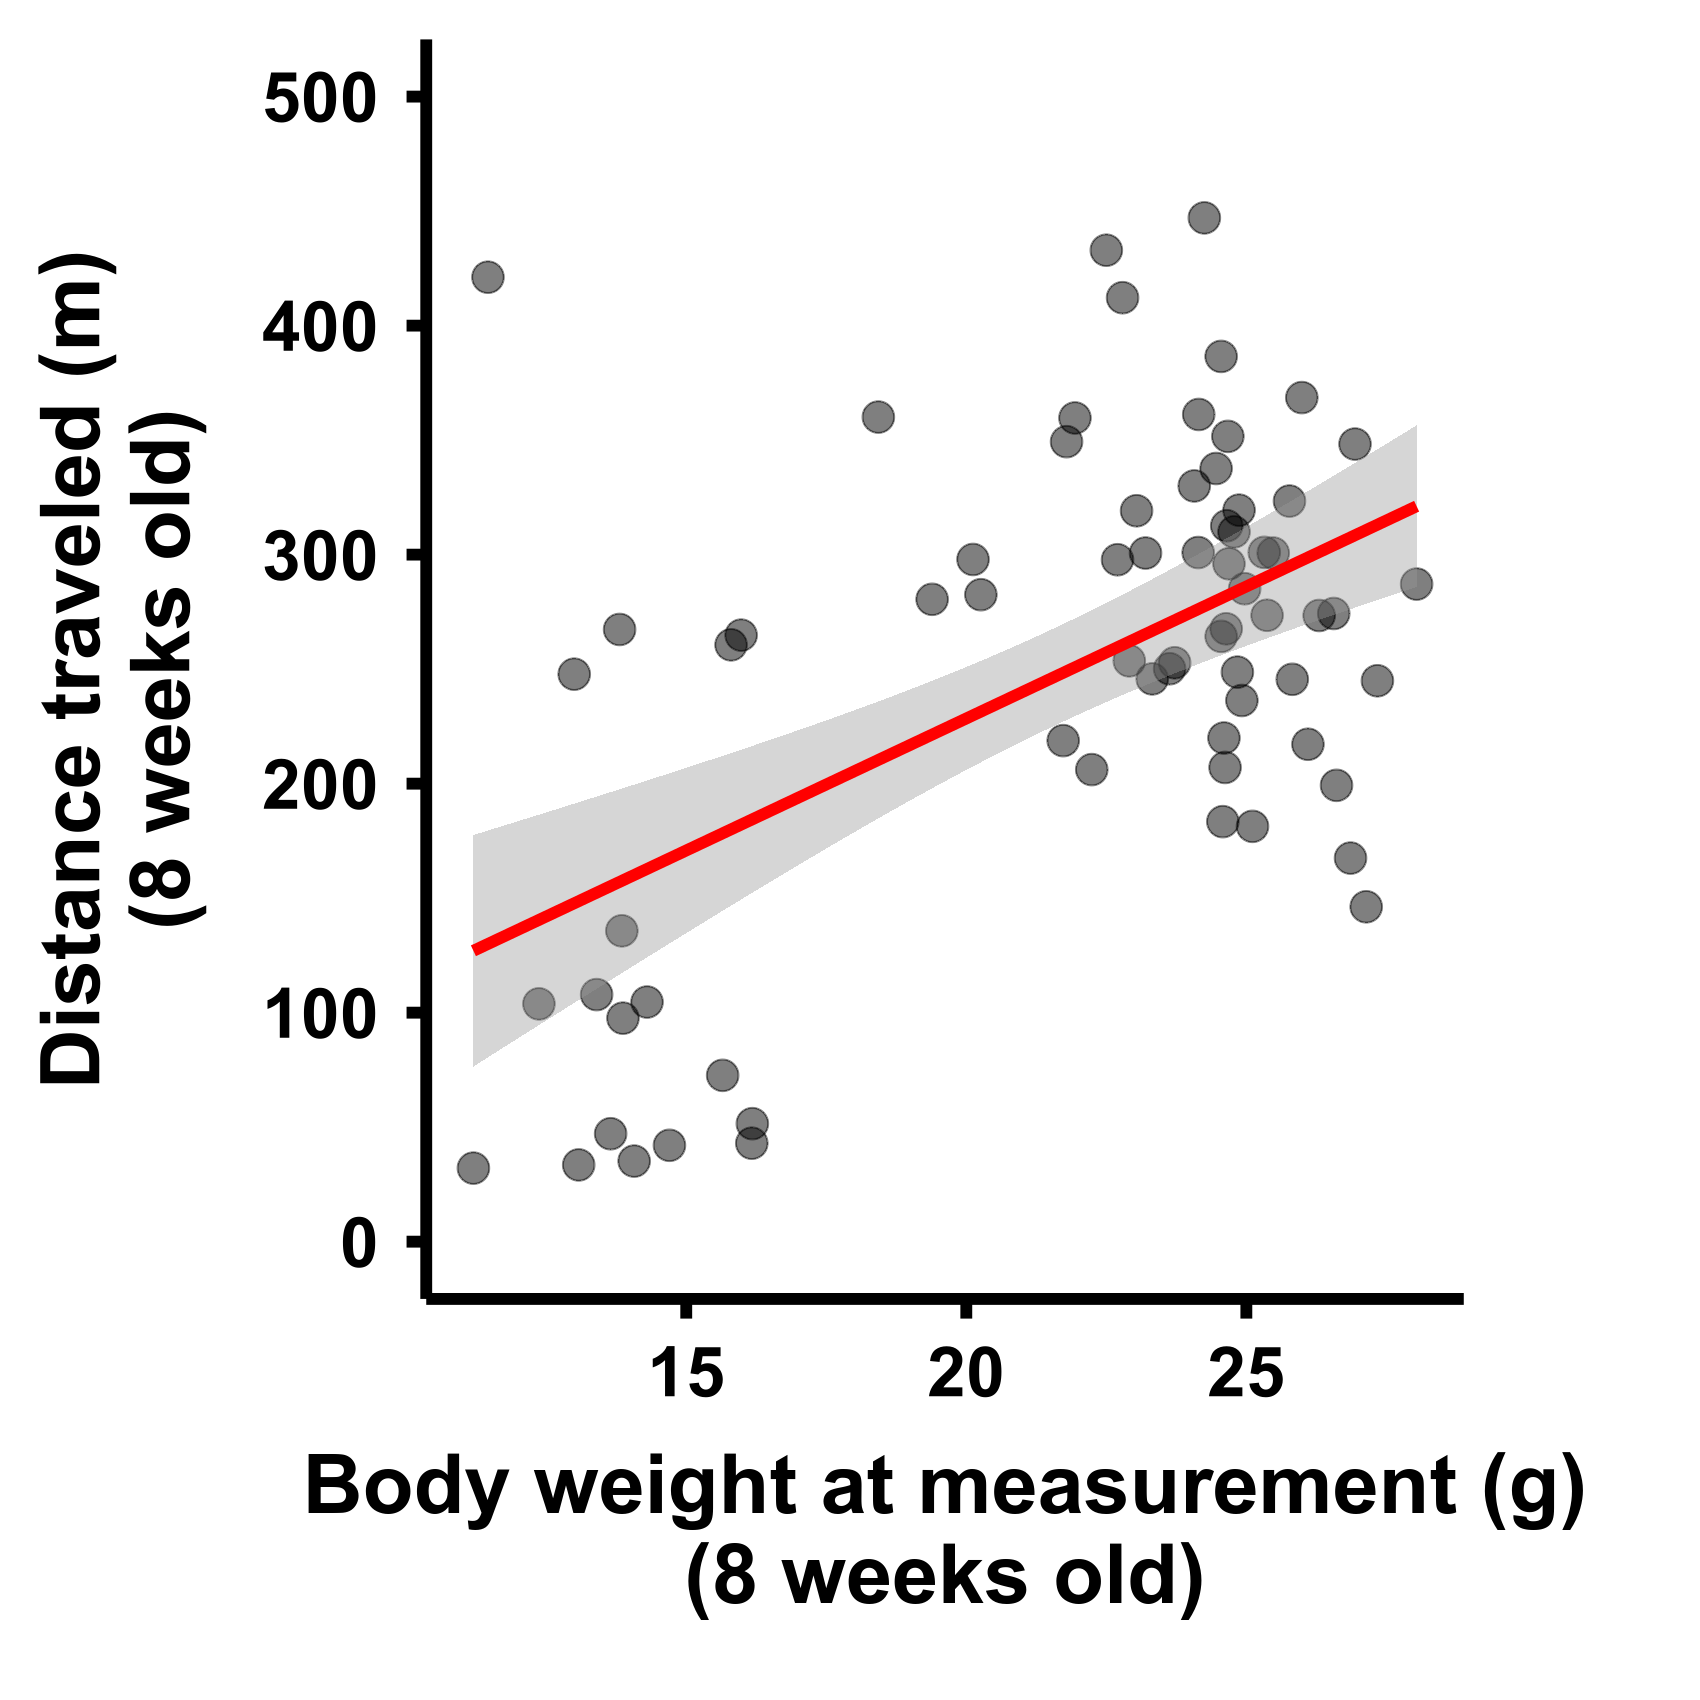

In [18]:

Master_data_pilot3 <- Master_data_pilot2 %>% select(ALL, RQ_48hours, RQ_24hours_1, RQ_5h_Day1, kcal_hr_48hours, kcal_hr_24hours_1, kcal_hr_5h_Day1, food_48hours, food_24hours_1, food_5h_Day1, water_48hours, water_24hours_1, water_5h_Day1,xbreak_48hours, xbreak_24hours_1, xbreak_5h_Day1, ybreak_48hours, ybreak_24hours_1, ybreak_5h_Day1, zbreak_48hours, zbreak_24hours_1, zbreak_5h_Day1, ped_m_48hours, ped_m_24hours_1, ped_m_5h_Day1, all_m_48hours, all_m_24hours_1, all_m_5h_Day1, BW_3w, BW_4w, BW_5w, BW_6w, BW_7w, BW_8w, BW_8w_final, fat_4w, fat_6w, fat_8w, lean_4w, lean_6w, lean_8w, F.water_4w, F.water_6w, F.water_8w, T.water_4w, T.water_6w, T.water_8w, TBL, TL, EL, HFL, BL, Small_Int_mm, Small_Int_g, Cecum_mm, Cecum_g, Large_int_mm, Large_int_g, Fat_pad) 


#cor.test(Master_data_pilot3$ped_m_24hours_1, Master_data_pilot3$BW_8w_final, method = "spearman") #rho =  0.2876239, p = 0.01576

p.dims(8.5, 8.5)
ggplot(data = Master_data_pilot3, aes(BW_8w_final, ped_m_24hours_1)) +
  geom_point(alpha = 0.5, color = "black", size = 5) +
  labs(x = "Body weight at measurement (g)\n(8 weeks old)", y = "Distance traveled (m)\n(8 weeks old)") +
  geom_smooth(method = lm, color = "red", size = 2) + 
  ylim(0, 500) +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), 
        axis.line = element_line(colour = "black", size = 2), 
        axis.ticks = element_line(color = "black", size=2),
        axis.ticks.length = unit(.25, "cm"), 
        axis.title = element_text(face="bold", size = 30),
        axis.text = element_text(face="bold", size = 25, colour="black"),
        
        
        axis.text.x = element_text(margin = margin(t = 10, r = 0, b = 0, l = 0)),
        axis.text.y = element_text(margin = margin(t = 0, r = 10, b = 0, l = 0)),
        axis.title.x = element_text(margin = margin(t = 15, r = 0, b = 0, l = 0)),
        axis.title.y = element_text(margin = margin(t = 0, r = 20, b = 0, l = 0)),
  
        legend.key.size = unit(1, 'cm'),
        legend.key = element_blank(), 
        legend.title=element_blank(),
        legend.text = element_text(face="bold", size = 40),
        plot.margin = unit(c(0.5,3,1,0.5),"cm")
        ) 

## Fig. S2C

`geom_smooth()` using formula = 'y ~ x'


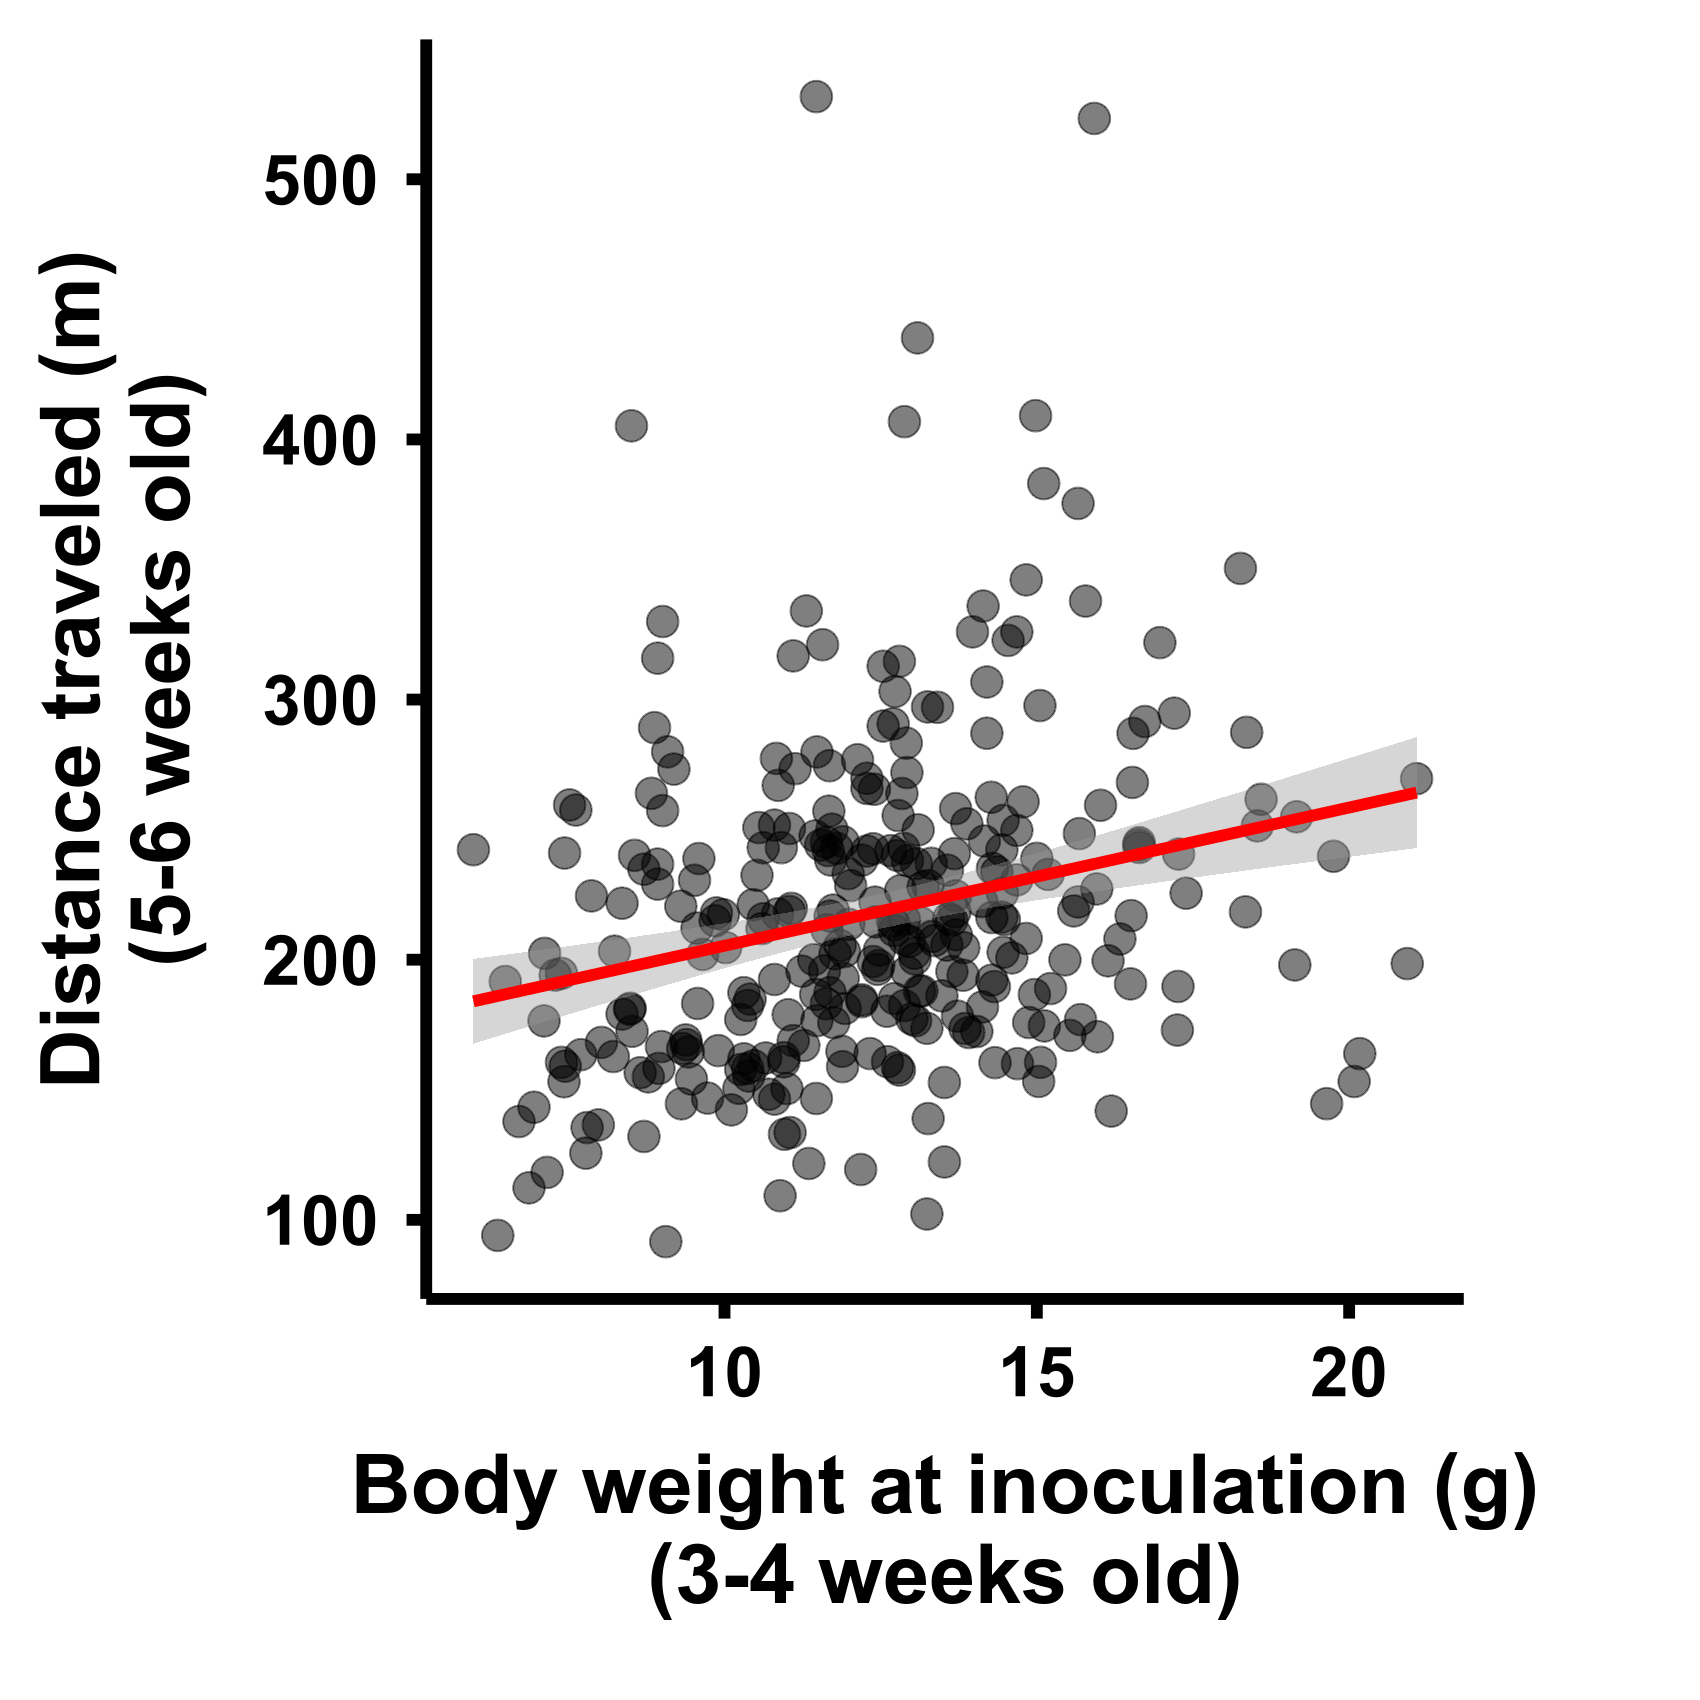

In [19]:
#View(Master_data1)
#cor.test(Master_data1$BW_3_4w, Master_data1$PedMeters_ALL, method = "spearman") #rho = 0.2790973, p = 5.922e-07

p.dims(8.5, 8.5)
ggplot(data = Master_data1, aes(BW_3_4w, PedMeters_ALL)) +
  geom_point(alpha = 0.5, color = "black", size = 5) +
  labs(x = "Body weight at inoculation (g)\n(3-4 weeks old)", y = "Distance traveled (m)\n(5-6 weeks old)") +
  geom_smooth(method = lm, color = "red", size = 2) + 
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), 
        axis.line = element_line(colour = "black", size = 2), 
        axis.ticks = element_line(color = "black", size=2),
        axis.ticks.length = unit(.25, "cm"), 
        axis.title = element_text(face="bold", size = 30),
        axis.text = element_text(face="bold", size = 25, colour="black"),
        
        
        axis.text.x = element_text(margin = margin(t = 10, r = 0, b = 0, l = 0)),
        axis.text.y = element_text(margin = margin(t = 0, r = 10, b = 0, l = 0)),
        axis.title.x = element_text(margin = margin(t = 15, r = 0, b = 0, l = 0)),
        axis.title.y = element_text(margin = margin(t = 0, r = 20, b = 0, l = 0)),
  
        legend.key.size = unit(1, 'cm'),
        legend.key = element_blank(), 
        legend.title=element_blank(),
        legend.text = element_text(face="bold", size = 40),
        plot.margin = unit(c(0.5,3,1,0.5),"cm")
        ) 

## Fig. S2D

`geom_smooth()` using formula = 'y ~ x'


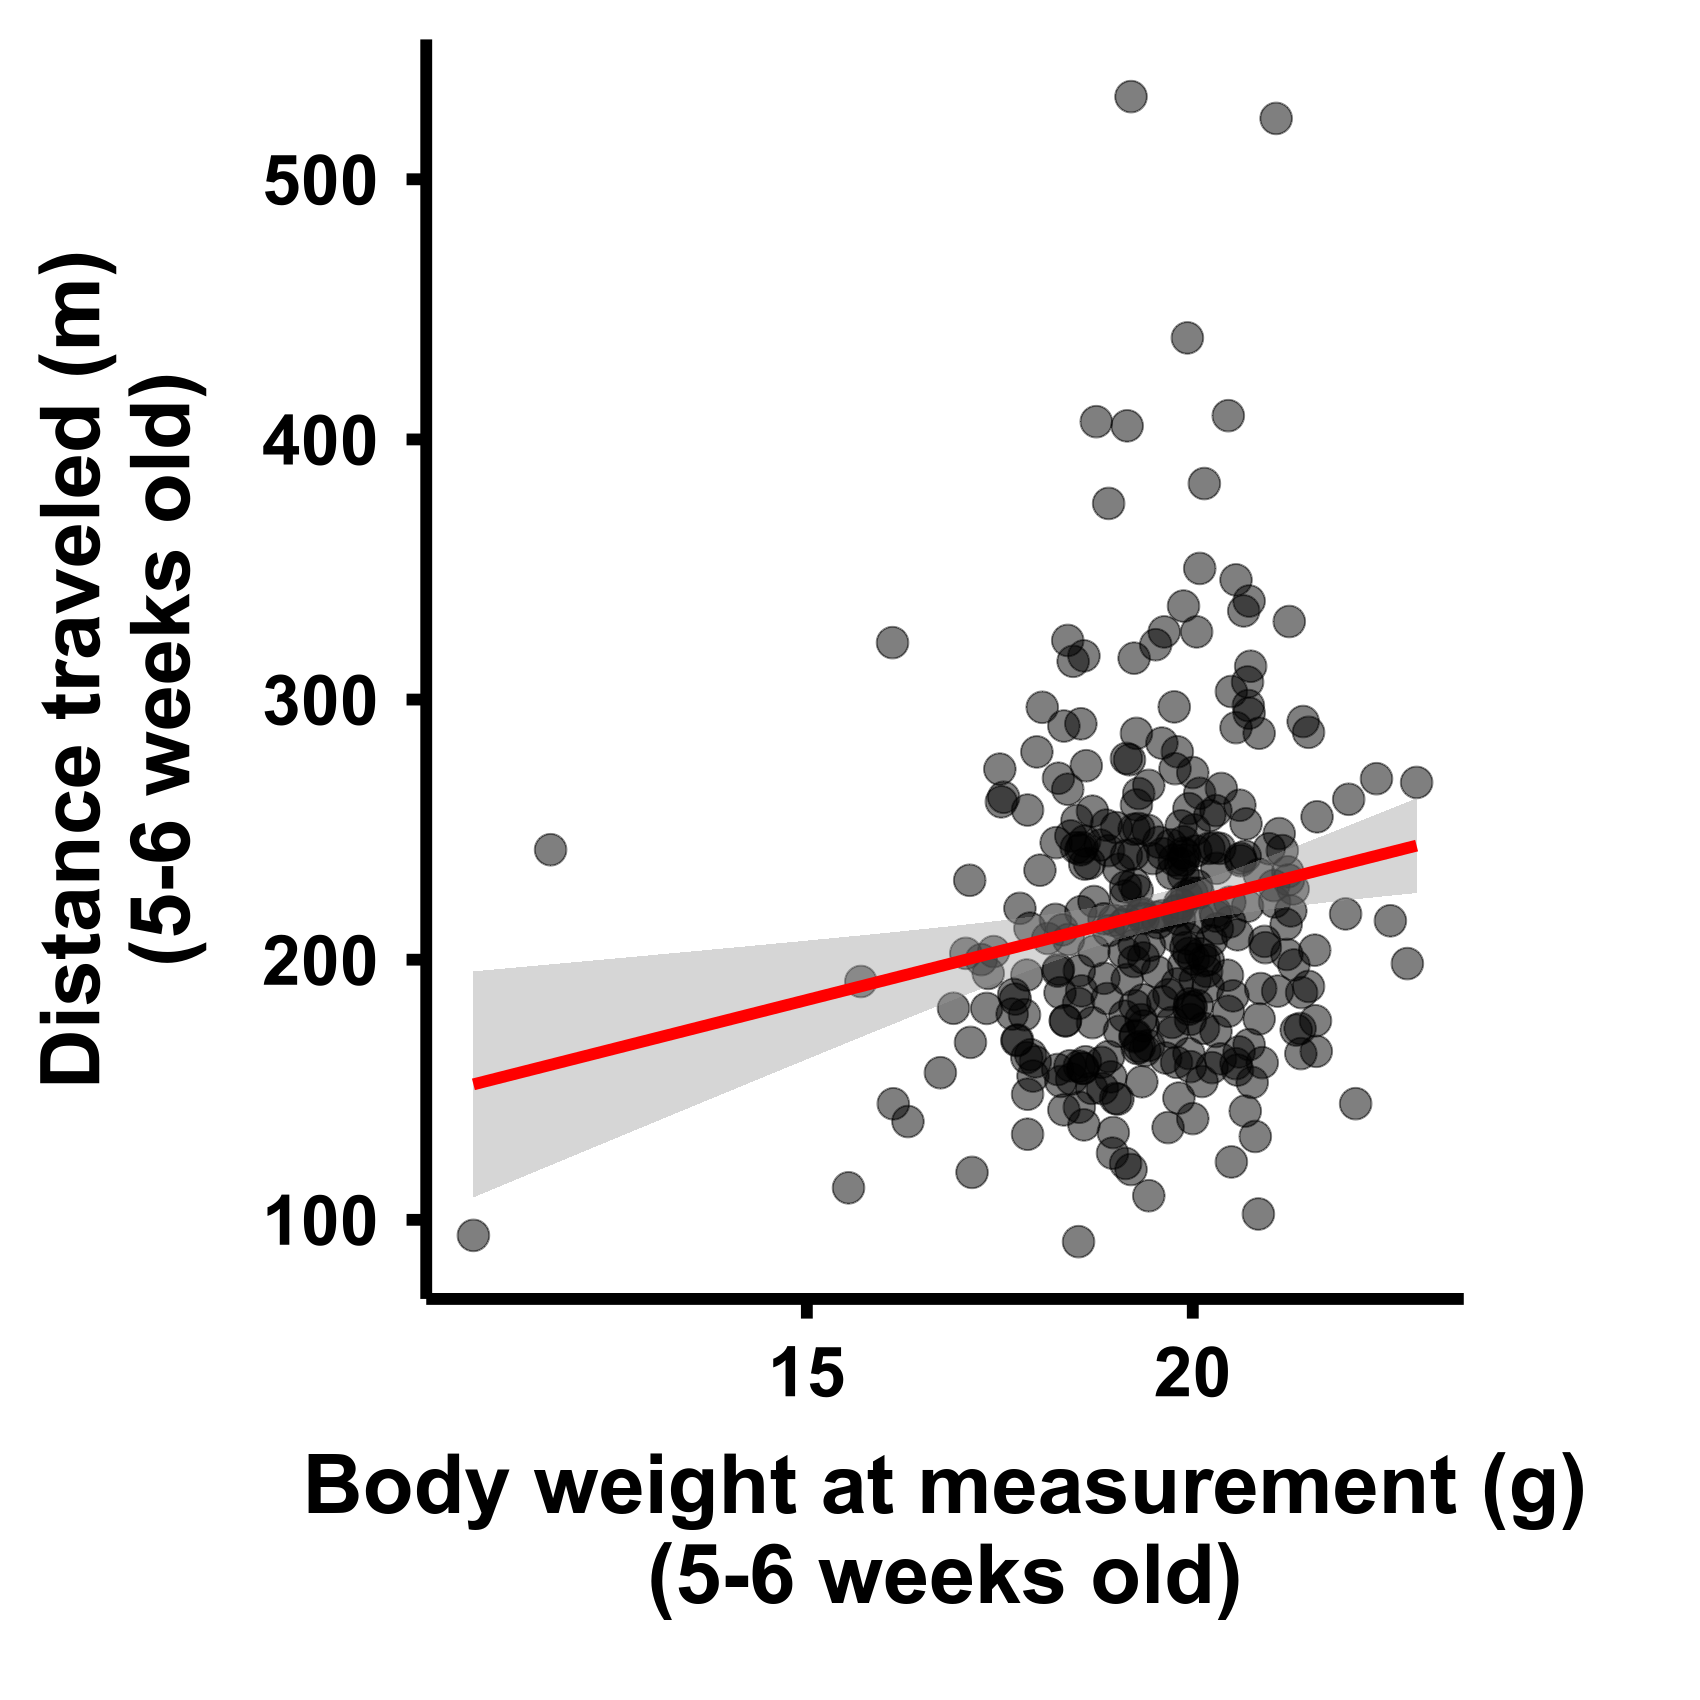

In [20]:
#View(Master_data1)
#cor.test(Master_data1$BW_5_6w, Master_data1$PedMeters_ALL, method = "spearman") #rho = 0.1631147, p = 0.003981

p.dims(8.5, 8.5)
ggplot(data = Master_data1, aes(BW_5_6w, PedMeters_ALL)) +
  geom_point(alpha = 0.5, color = "black", size = 5) +
  labs(x = "Body weight at measurement (g)\n(5-6 weeks old)", y = "Distance traveled (m)\n(5-6 weeks old)") +
  geom_smooth(method = lm, color = "red", size = 2) + 
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), 
        axis.line = element_line(colour = "black", size = 2), 
        axis.ticks = element_line(color = "black", size=2),
        axis.ticks.length = unit(.25, "cm"), 
        axis.title = element_text(face="bold", size = 30),
        axis.text = element_text(face="bold", size = 25, colour="black"),
        
        
        axis.text.x = element_text(margin = margin(t = 10, r = 0, b = 0, l = 0)),
        axis.text.y = element_text(margin = margin(t = 0, r = 10, b = 0, l = 0)),
        axis.title.x = element_text(margin = margin(t = 15, r = 0, b = 0, l = 0)),
        axis.title.y = element_text(margin = margin(t = 0, r = 20, b = 0, l = 0)),
  
        legend.key.size = unit(1, 'cm'),
        legend.key = element_blank(), 
        legend.title=element_blank(),
        legend.text = element_text(face="bold", size = 40),
        plot.margin = unit(c(0.5,3,1,0.5),"cm")
        ) 

## Add residuals of distance traveled and filter table

In [21]:
#Add residuals of distance traveled
Master_data1_noN1 = Master_data1[!Master_data1$generation == "N1",]

#Log transformed, centered, and scaled
#recipients
Master_data1_noN1$PedMeters_ALL_log = scale(log(Master_data1_noN1$PedMeters_ALL),center = TRUE, scale = TRUE) 
Master_data1_noN1$BW_3_4w_log = scale(log(Master_data1_noN1$BW_3_4w), center = TRUE, scale = TRUE)
#donors
Master_data1_noN1$PedMeters_ALL_donor_log = scale(log(Master_data1_noN1$PedMeters_ALL_donor),center = TRUE, scale = TRUE) 
Master_data1_noN1$BW_3_4w_donor_log = scale(log(Master_data1_noN1$BW_3_4w_donor), center = TRUE, scale = TRUE)

#Save residuals of distance traveled accounting for body weight at weaning and batch
PedMeter_recipient_BW_Batch = lmer(PedMeters_ALL_log ~ BW_3_4w_log + (1|Batch), data= Master_data1_noN1)
PedMeter_donor_BW_Batch = lmer(PedMeters_ALL_donor_log ~ BW_3_4w_donor_log + (1|Batch), data= Master_data1_noN1)

Master_data1_noN1$PedMeters_recipient_residuals =resid(PedMeter_recipient_BW_Batch)
Master_data1_noN1$PedMeters_donor_residuals =resid(PedMeter_donor_BW_Batch)

#Add residuals to original table
Residuals_to_add = Master_data1_noN1 %>% select(AnimalID, PedMeters_recipient_residuals, PedMeters_donor_residuals)
Master_data1 <- merge(Master_data1, Residuals_to_add, by = "AnimalID", all = TRUE)


#Filter dataframe
Master_data1_N2 = Master_data1 %>% filter(Master_data1$generation == "N2")
Master_data1_N3 = Master_data1 %>% filter(Master_data1$generation == "N3")
Master_data1_N4 = Master_data1 %>% filter(Master_data1$generation == "N4")
Master_data1_N5 = Master_data1 %>% filter(Master_data1$generation == "N5")

Master_data1_noN1_C = Master_data1_noN1 %>% filter(Master_data1_noN1$TreatmentID == "C") 
Master_data1_N2_C = Master_data1_N2 %>% filter(Master_data1_N2$TreatmentID == "C")
Master_data1_N3_C = Master_data1_N3 %>% filter(Master_data1_N3$TreatmentID == "C")
Master_data1_N4_C = Master_data1_N4 %>% filter(Master_data1_N4$TreatmentID == "C")
Master_data1_N5_C = Master_data1_N5 %>% filter(Master_data1_N5$TreatmentID == "C")

Master_data1_noN1_T = Master_data1_noN1 %>% filter(Master_data1_noN1$TreatmentID == "T") 
Master_data1_N2_T = Master_data1_N2 %>% filter(Master_data1_N2$TreatmentID == "T")
Master_data1_N3_T = Master_data1_N3 %>% filter(Master_data1_N3$TreatmentID == "T")
Master_data1_N4_T = Master_data1_N4 %>% filter(Master_data1_N4$TreatmentID == "T")
Master_data1_N5_T = Master_data1_N5 %>% filter(Master_data1_N5$TreatmentID == "T")

## Fig. S3A

Warning message:
“The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as
of ggplot2 3.3.4.”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


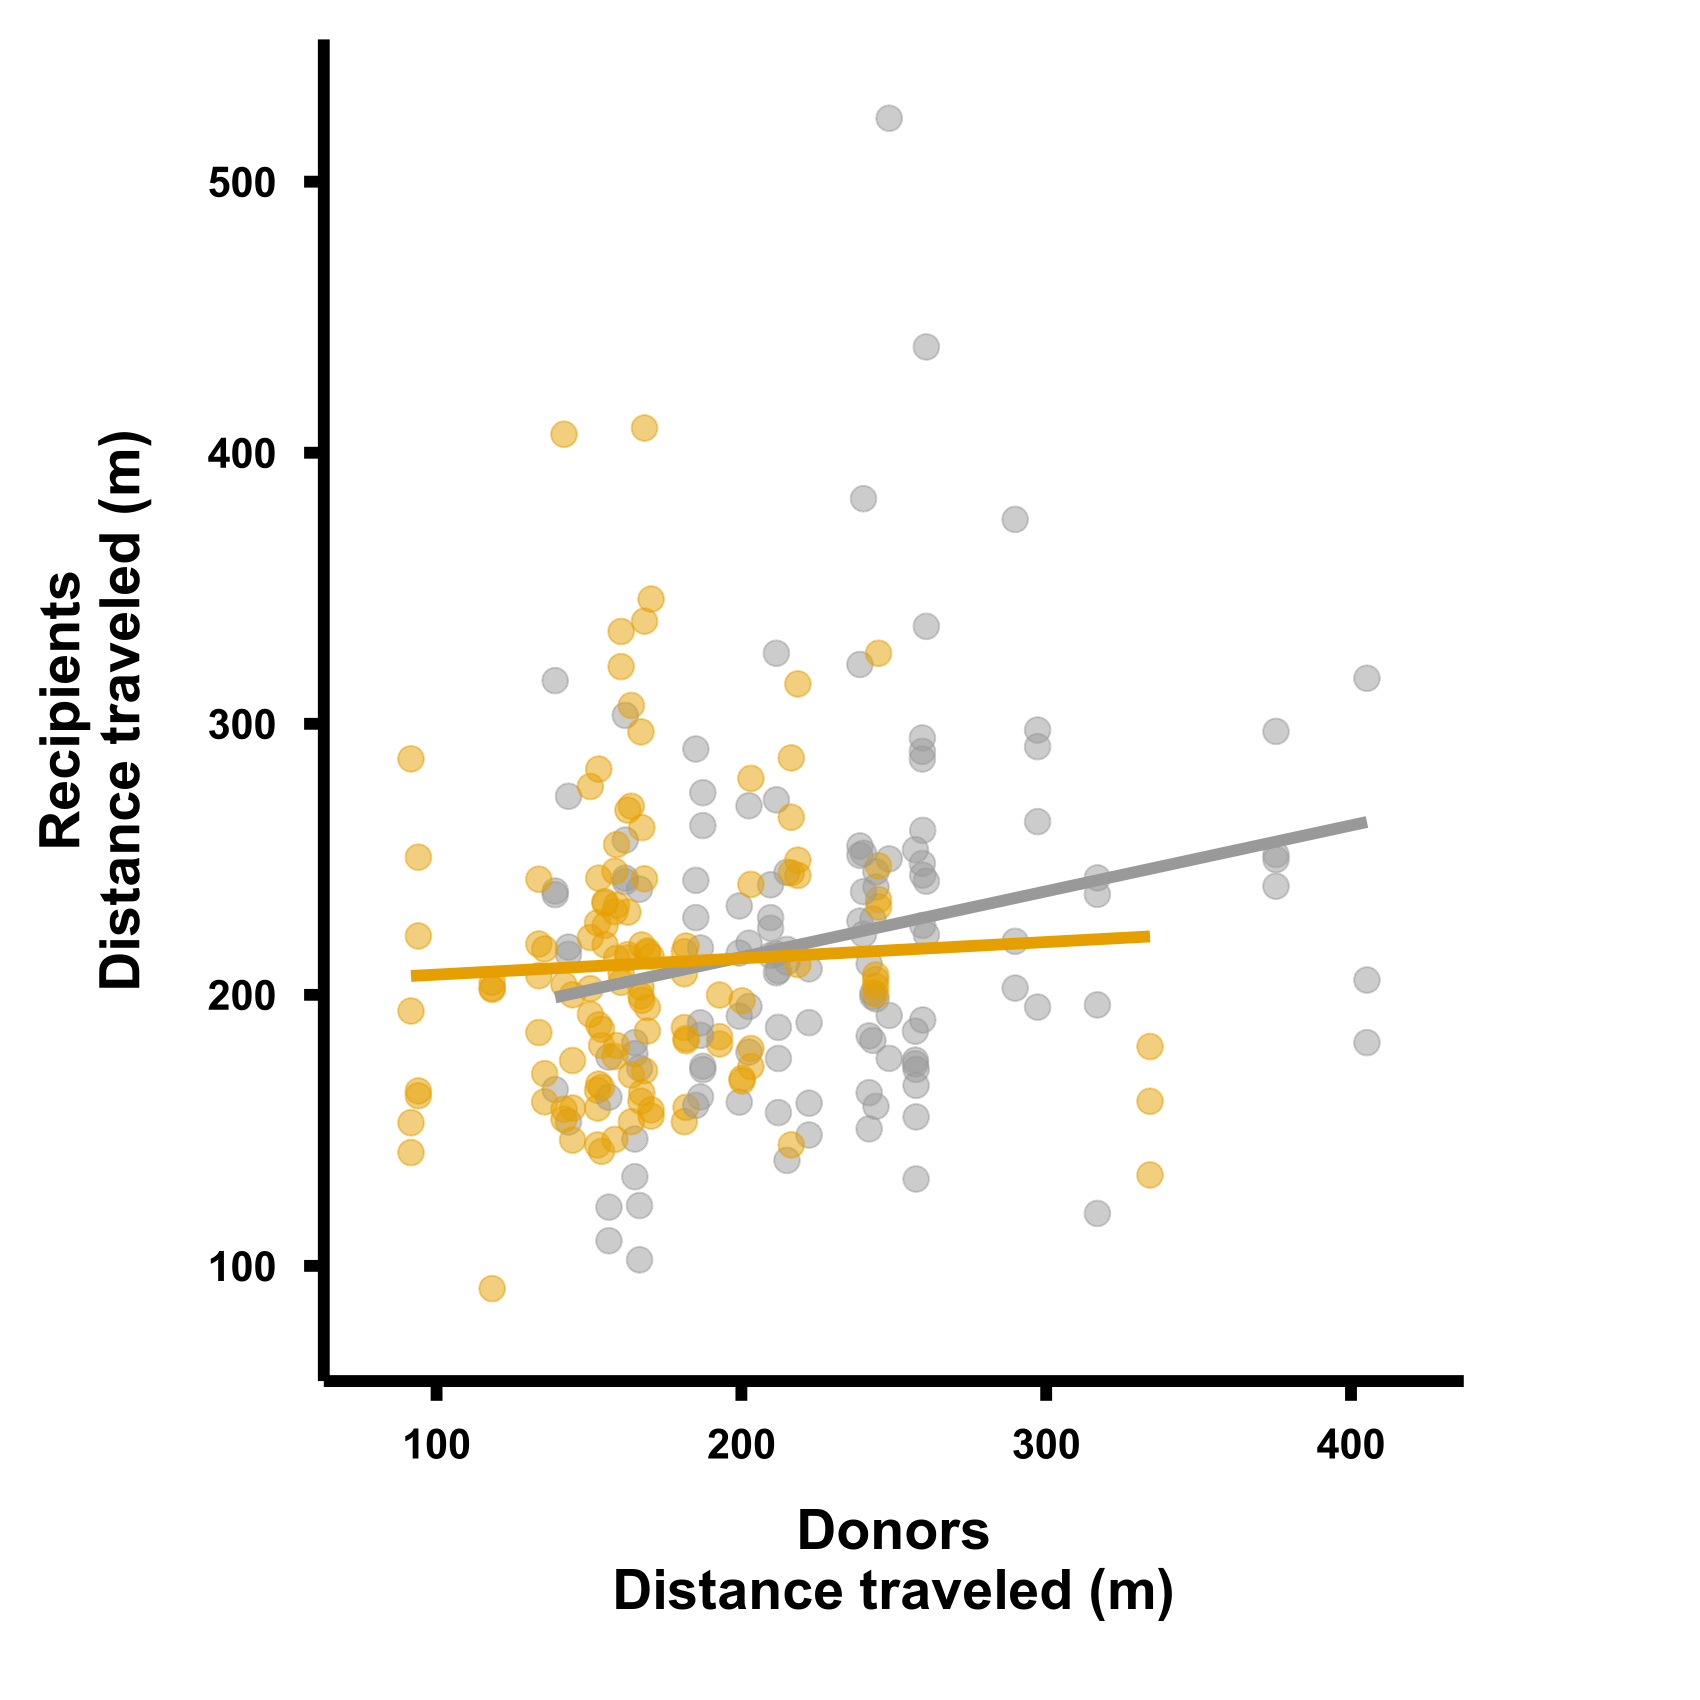

In [22]:
ggplot(data = Master_data1_noN1, aes(x= PedMeters_ALL_donor, y = PedMeters_ALL, color = TreatmentID)) +
  geom_point(alpha = 0.5, size = 4) +
  ylim(80,530) +
  xlim(80,420) +
  labs(x = "Donors\nDistance traveled (m)", y = "Recipients\nDistance traveled (m)") +
  #geom_smooth(method = lm, color = "red", size = 2) + 
  geom_smooth(method = lm, size = 2, se=FALSE, fullrange=FALSE) + 
  scale_color_manual(labels = c("Control", "Selection"), values=c('#999999','#E69F00'))+
  
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), 
        axis.line = element_line(colour = "black", size = 2), 
        axis.ticks = element_line(color = "black", size=2),
        axis.ticks.length = unit(.25, "cm"), 
        axis.title = element_text(face="bold", size = 20),
        axis.text = element_text(face="bold", size = 15, colour="black"),
        
        
        axis.text.x = element_text(margin = margin(t = 10, r = 0, b = 0, l = 0)),
        axis.text.y = element_text(margin = margin(t = 0, r = 10, b = 0, l = 0)),
        axis.title.x = element_text(margin = margin(t = 15, r = 0, b = 0, l = 0)),
        axis.title.y = element_text(margin = margin(t = 0, r = 20, b = 0, l = 0)),
  
        legend.key.size = unit(1, 'cm'),
        legend.key = element_blank(), 
        legend.title=element_blank(),
        legend.text = element_text(face="bold", size = 40),
        plot.margin = unit(c(0.5,3,1,0.5),"cm")
        ) +
        guides(color = FALSE)

#cor.test(Master_data1_noN1$PedMeters_ALL_donor, Master_data1_noN1$PedMeters_ALL, method = "spearman") #rho = 0.1934031, p = 0.002085

## Fig. S3B

`geom_smooth()` using formula = 'y ~ x'


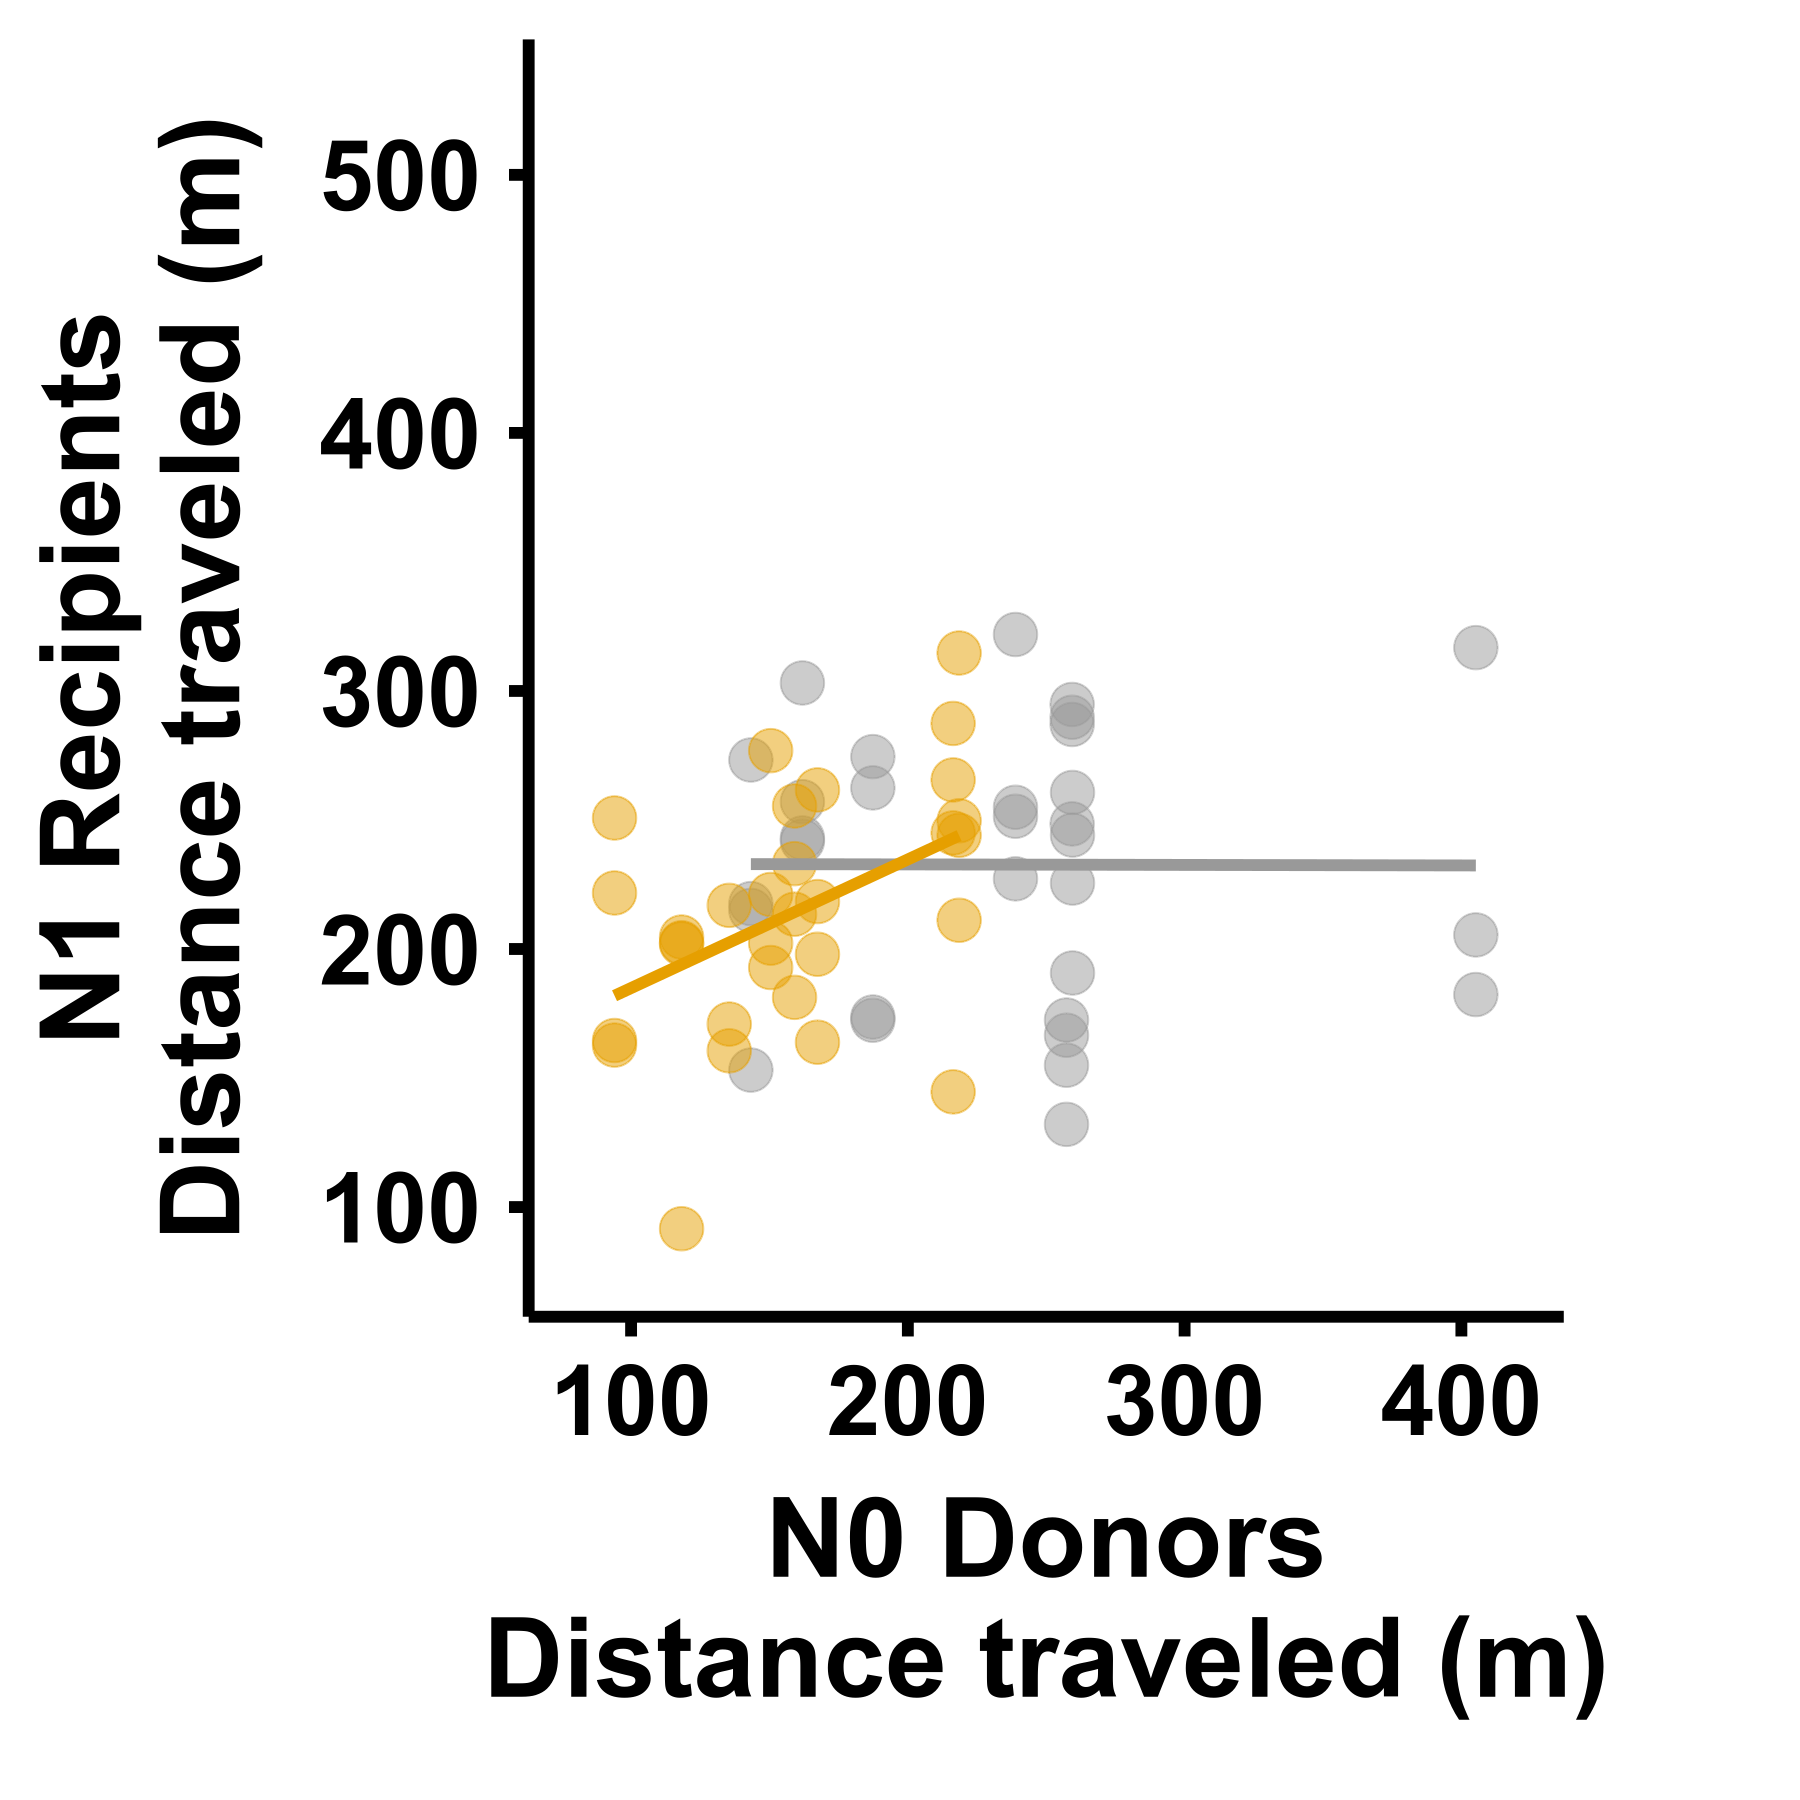

In [23]:
p.dims(9, 9)
ggplot(data = Master_data1_N2, aes(x = PedMeters_ALL_donor, y = PedMeters_ALL, color = TreatmentID)) +
  geom_point(alpha = 0.5, size = 7) +
  ylim(80,530) +
  xlim(80,420) +
  labs(x = "N0 Donors\nDistance traveled (m)", y = "N1 Recipients\nDistance traveled (m)") +
  #geom_smooth(method = lm, color = "red", size = 2) + 
  geom_smooth(method = lm, size = 2, se=FALSE, fullrange=FALSE) + 
  scale_color_manual(labels = c("Control", "Selection"), values=c('#999999','#E69F00'))+
  
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), 
        axis.line = element_line(colour = "black", size = 2), 
        axis.ticks = element_line(color = "black", size=2),
        axis.ticks.length = unit(.25, "cm"), 
        axis.title = element_text(face="bold", size = 40),
        axis.text = element_text(face="bold", size = 35, colour="black"),
        
        
        axis.text.x = element_text(margin = margin(t = 10, r = 0, b = 0, l = 0)),
        axis.text.y = element_text(margin = margin(t = 0, r = 10, b = 0, l = 0)),
        axis.title.x = element_text(margin = margin(t = 15, r = 0, b = 0, l = 0)),
        axis.title.y = element_text(margin = margin(t = 0, r = 20, b = 0, l = 0)),
  
        legend.key.size = unit(1, 'cm'),
        legend.key = element_blank(), 
        legend.title=element_blank(),
        legend.text = element_text(face="bold", size = 30),
        plot.margin = unit(c(0.5,3,1,0.5),"cm")
        )+
        guides(color = FALSE)
#cor.test(Master_data1_N2$PedMeters_ALL_donor, Master_data1_N2$PedMeters_ALL, method = "spearman") #rho = 0.282918, p = 0.02587

## Fig. S3B

`geom_smooth()` using formula = 'y ~ x'


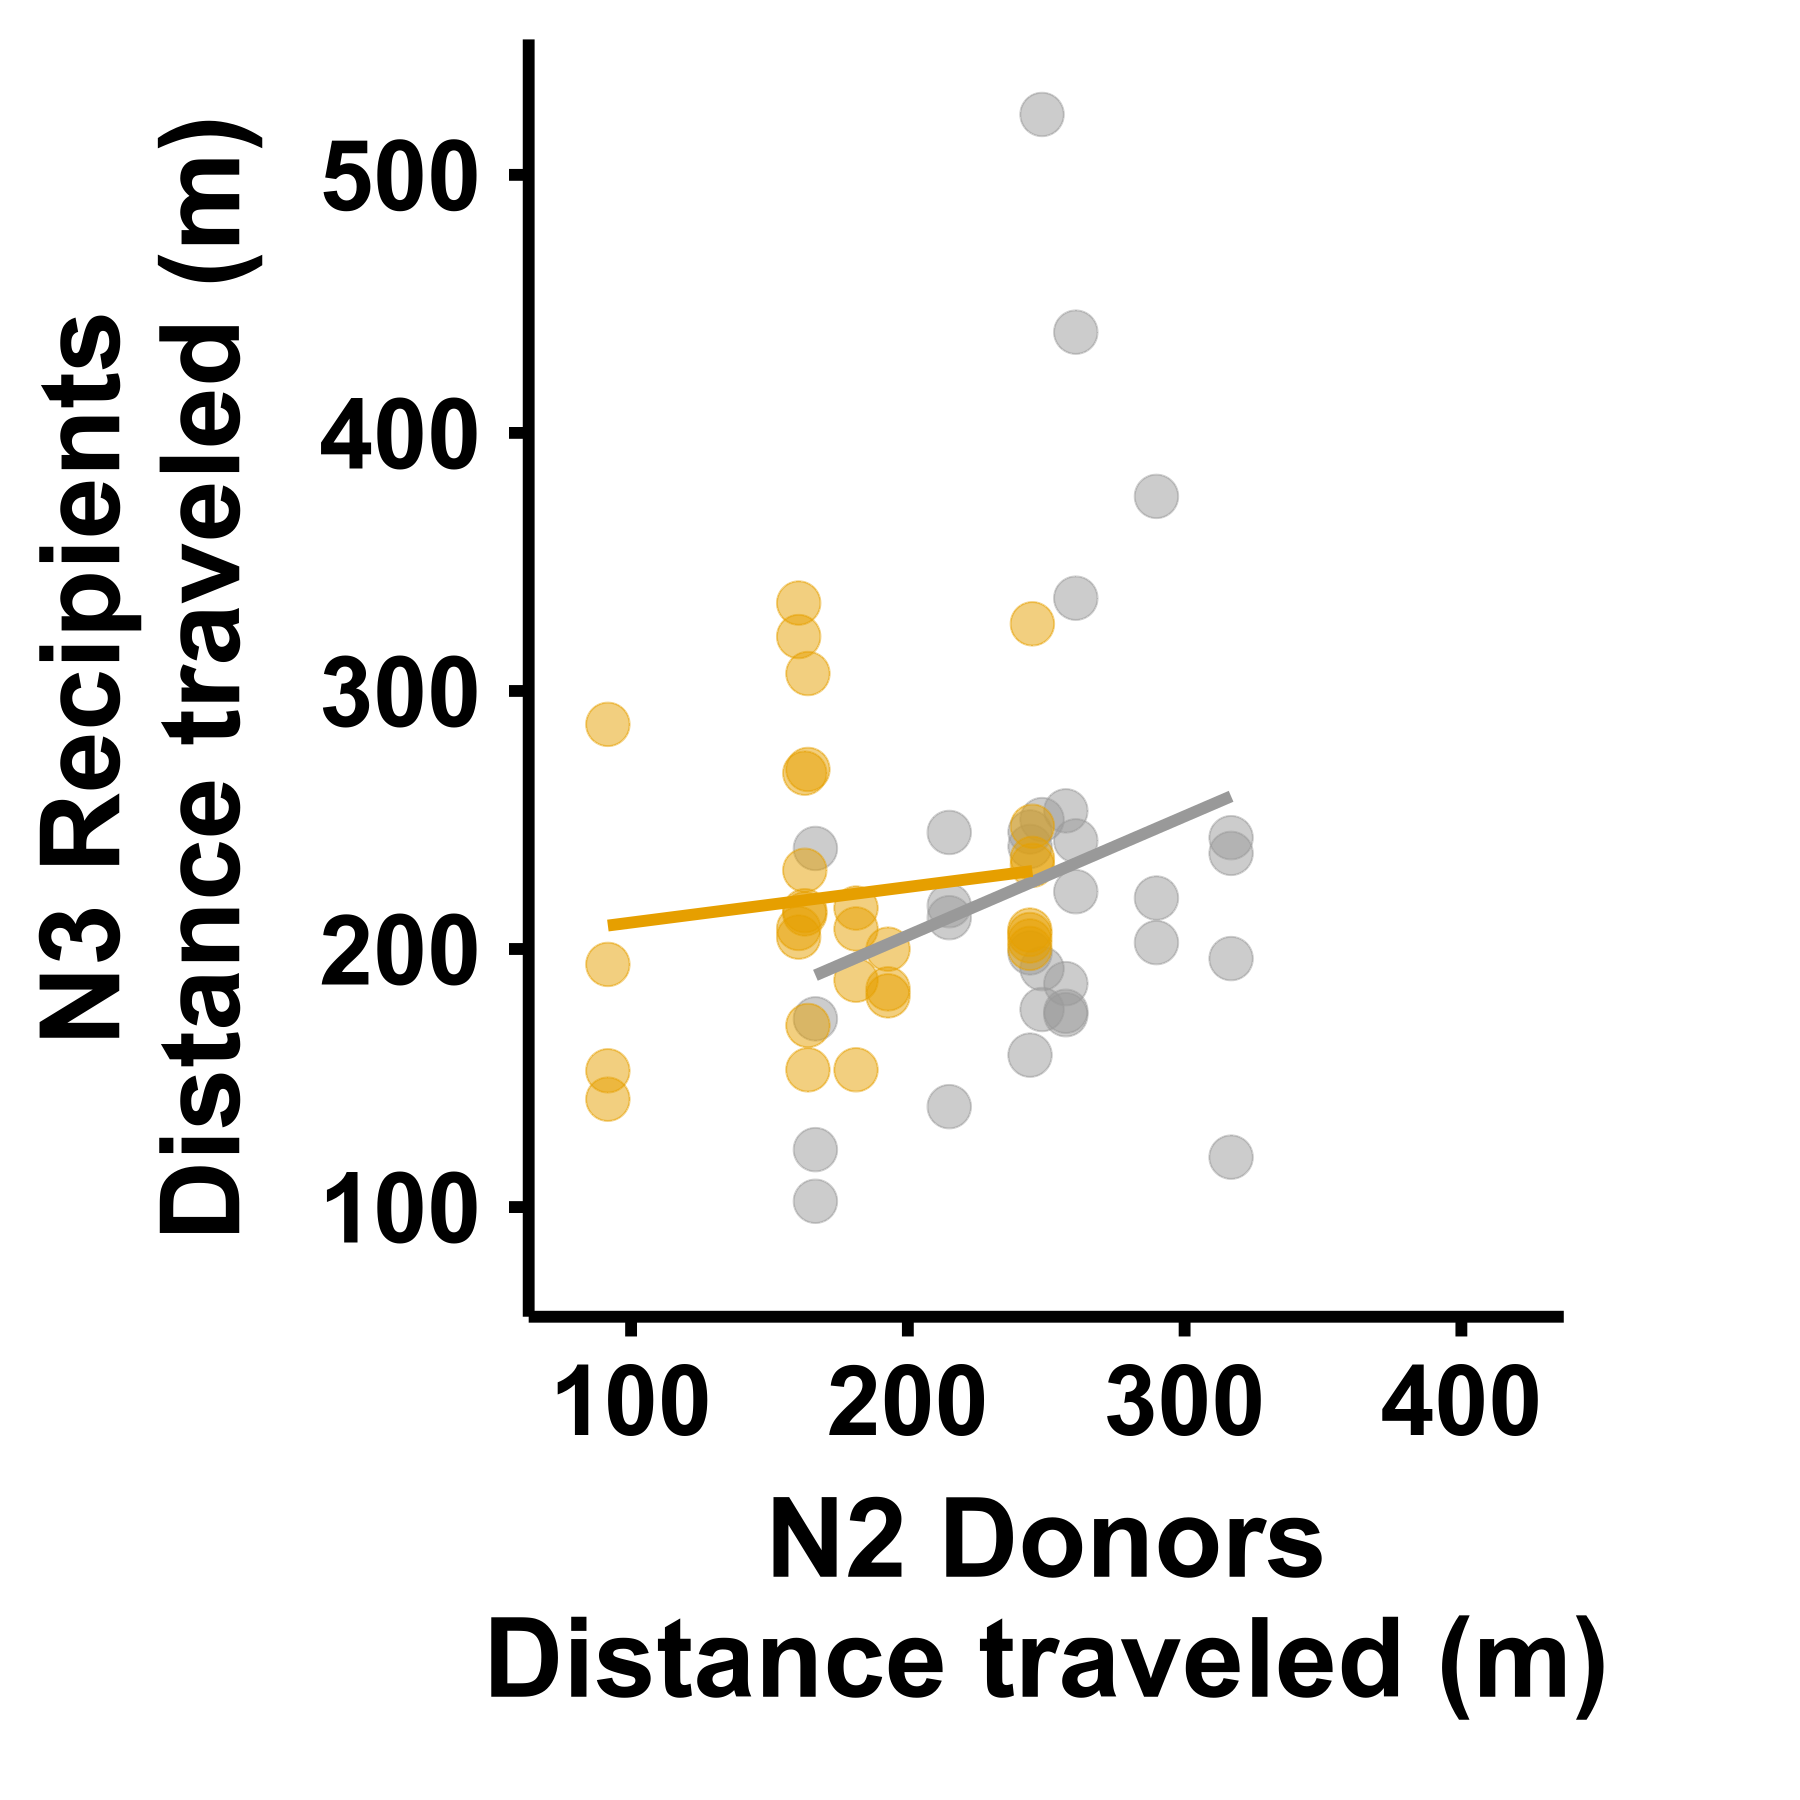

In [24]:
p.dims(9, 9)
ggplot(data = Master_data1_N3, aes(x = PedMeters_ALL_donor, y = PedMeters_ALL, color = TreatmentID)) +
  geom_point(alpha = 0.5, size = 7) +
  ylim(80,530) +
  xlim(80,420) +
  labs(x = "N2 Donors\nDistance traveled (m)", y = "N3 Recipients\nDistance traveled (m)") +
  #geom_smooth(method = lm, color = "red", size = 2) + 
  geom_smooth(method = lm, size = 2, se=FALSE, fullrange=FALSE) + 
  scale_color_manual(labels = c("Control", "Selection"), values=c('#999999','#E69F00'))+
  
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), 
        axis.line = element_line(colour = "black", size = 2), 
        axis.ticks = element_line(color = "black", size=2),
        axis.ticks.length = unit(.25, "cm"), 
        axis.title = element_text(face="bold", size = 40),
        axis.text = element_text(face="bold", size = 35, colour="black"),
        
        
        axis.text.x = element_text(margin = margin(t = 10, r = 0, b = 0, l = 0)),
        axis.text.y = element_text(margin = margin(t = 0, r = 10, b = 0, l = 0)),
        axis.title.x = element_text(margin = margin(t = 15, r = 0, b = 0, l = 0)),
        axis.title.y = element_text(margin = margin(t = 0, r = 20, b = 0, l = 0)),
  
        legend.key.size = unit(1, 'cm'),
        legend.key = element_blank(), 
        legend.title=element_blank(),
        legend.text = element_text(face="bold", size = 30),
        plot.margin = unit(c(0.5,3,1,0.5),"cm")
        ) +
        guides(color = FALSE)
#cor.test(Master_data1_N3$PedMeters_ALL_donor, Master_data1_N3$PedMeters_ALL, method = "spearman") #rho = 0.1516767, p = 0.2393

## Fig. S3B

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


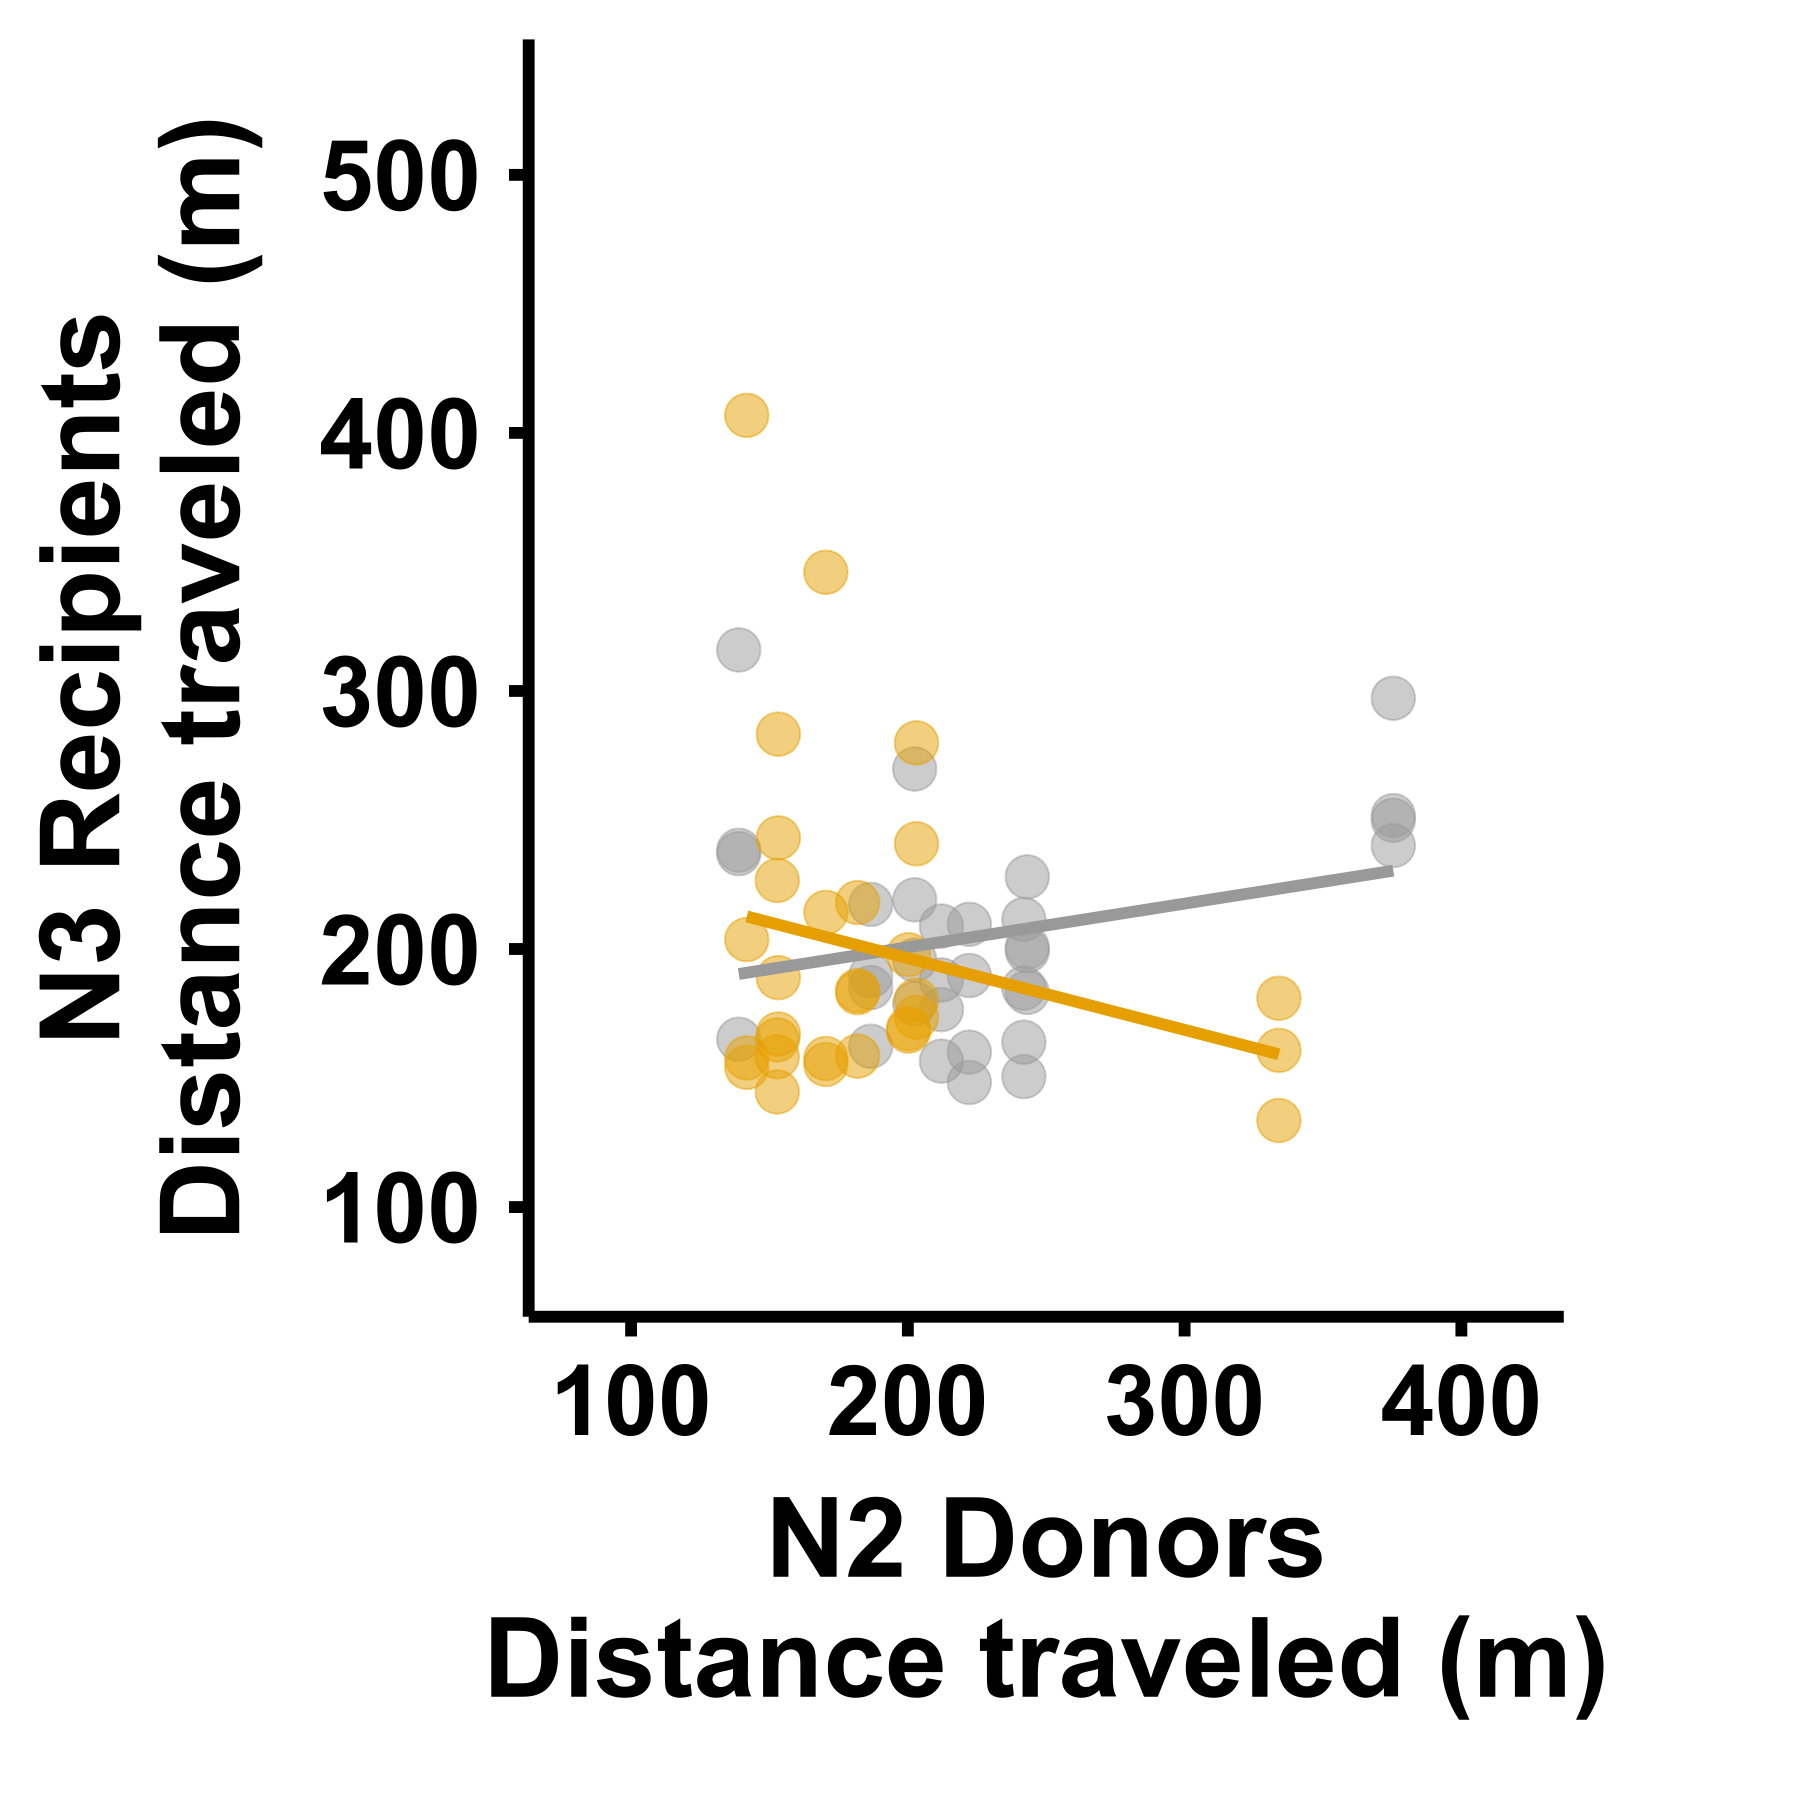

In [25]:
p.dims(9, 9)
ggplot(data = Master_data1_N4, aes(x = PedMeters_ALL_donor, y = PedMeters_ALL, color = TreatmentID)) +
  geom_point(alpha = 0.5, size = 7) +
  ylim(80,530) +
  xlim(80,420) +
  labs(x = "N2 Donors\nDistance traveled (m)", y = "N3 Recipients\nDistance traveled (m)") +
  #geom_smooth(method = lm, color = "red", size = 2) + 
  geom_smooth(method = lm, size = 2, se=FALSE, fullrange=FALSE) + 
  scale_color_manual(labels = c("Control", "Selection"), values=c('#999999','#E69F00'))+
  
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), 
        axis.line = element_line(colour = "black", size = 2), 
        axis.ticks = element_line(color = "black", size=2),
        axis.ticks.length = unit(.25, "cm"), 
        axis.title = element_text(face="bold", size = 40),
        axis.text = element_text(face="bold", size = 35, colour="black"),
        
        
        axis.text.x = element_text(margin = margin(t = 10, r = 0, b = 0, l = 0)),
        axis.text.y = element_text(margin = margin(t = 0, r = 10, b = 0, l = 0)),
        axis.title.x = element_text(margin = margin(t = 15, r = 0, b = 0, l = 0)),
        axis.title.y = element_text(margin = margin(t = 0, r = 20, b = 0, l = 0)),
  
        legend.key.size = unit(1, 'cm'),
        legend.key = element_blank(), 
        legend.title=element_blank(),
        legend.text = element_text(face="bold", size = 30),
        plot.margin = unit(c(0.5,3,1,0.5),"cm")
        ) +
        guides(color = FALSE)

## Fig. S3B

`geom_smooth()` using formula = 'y ~ x'


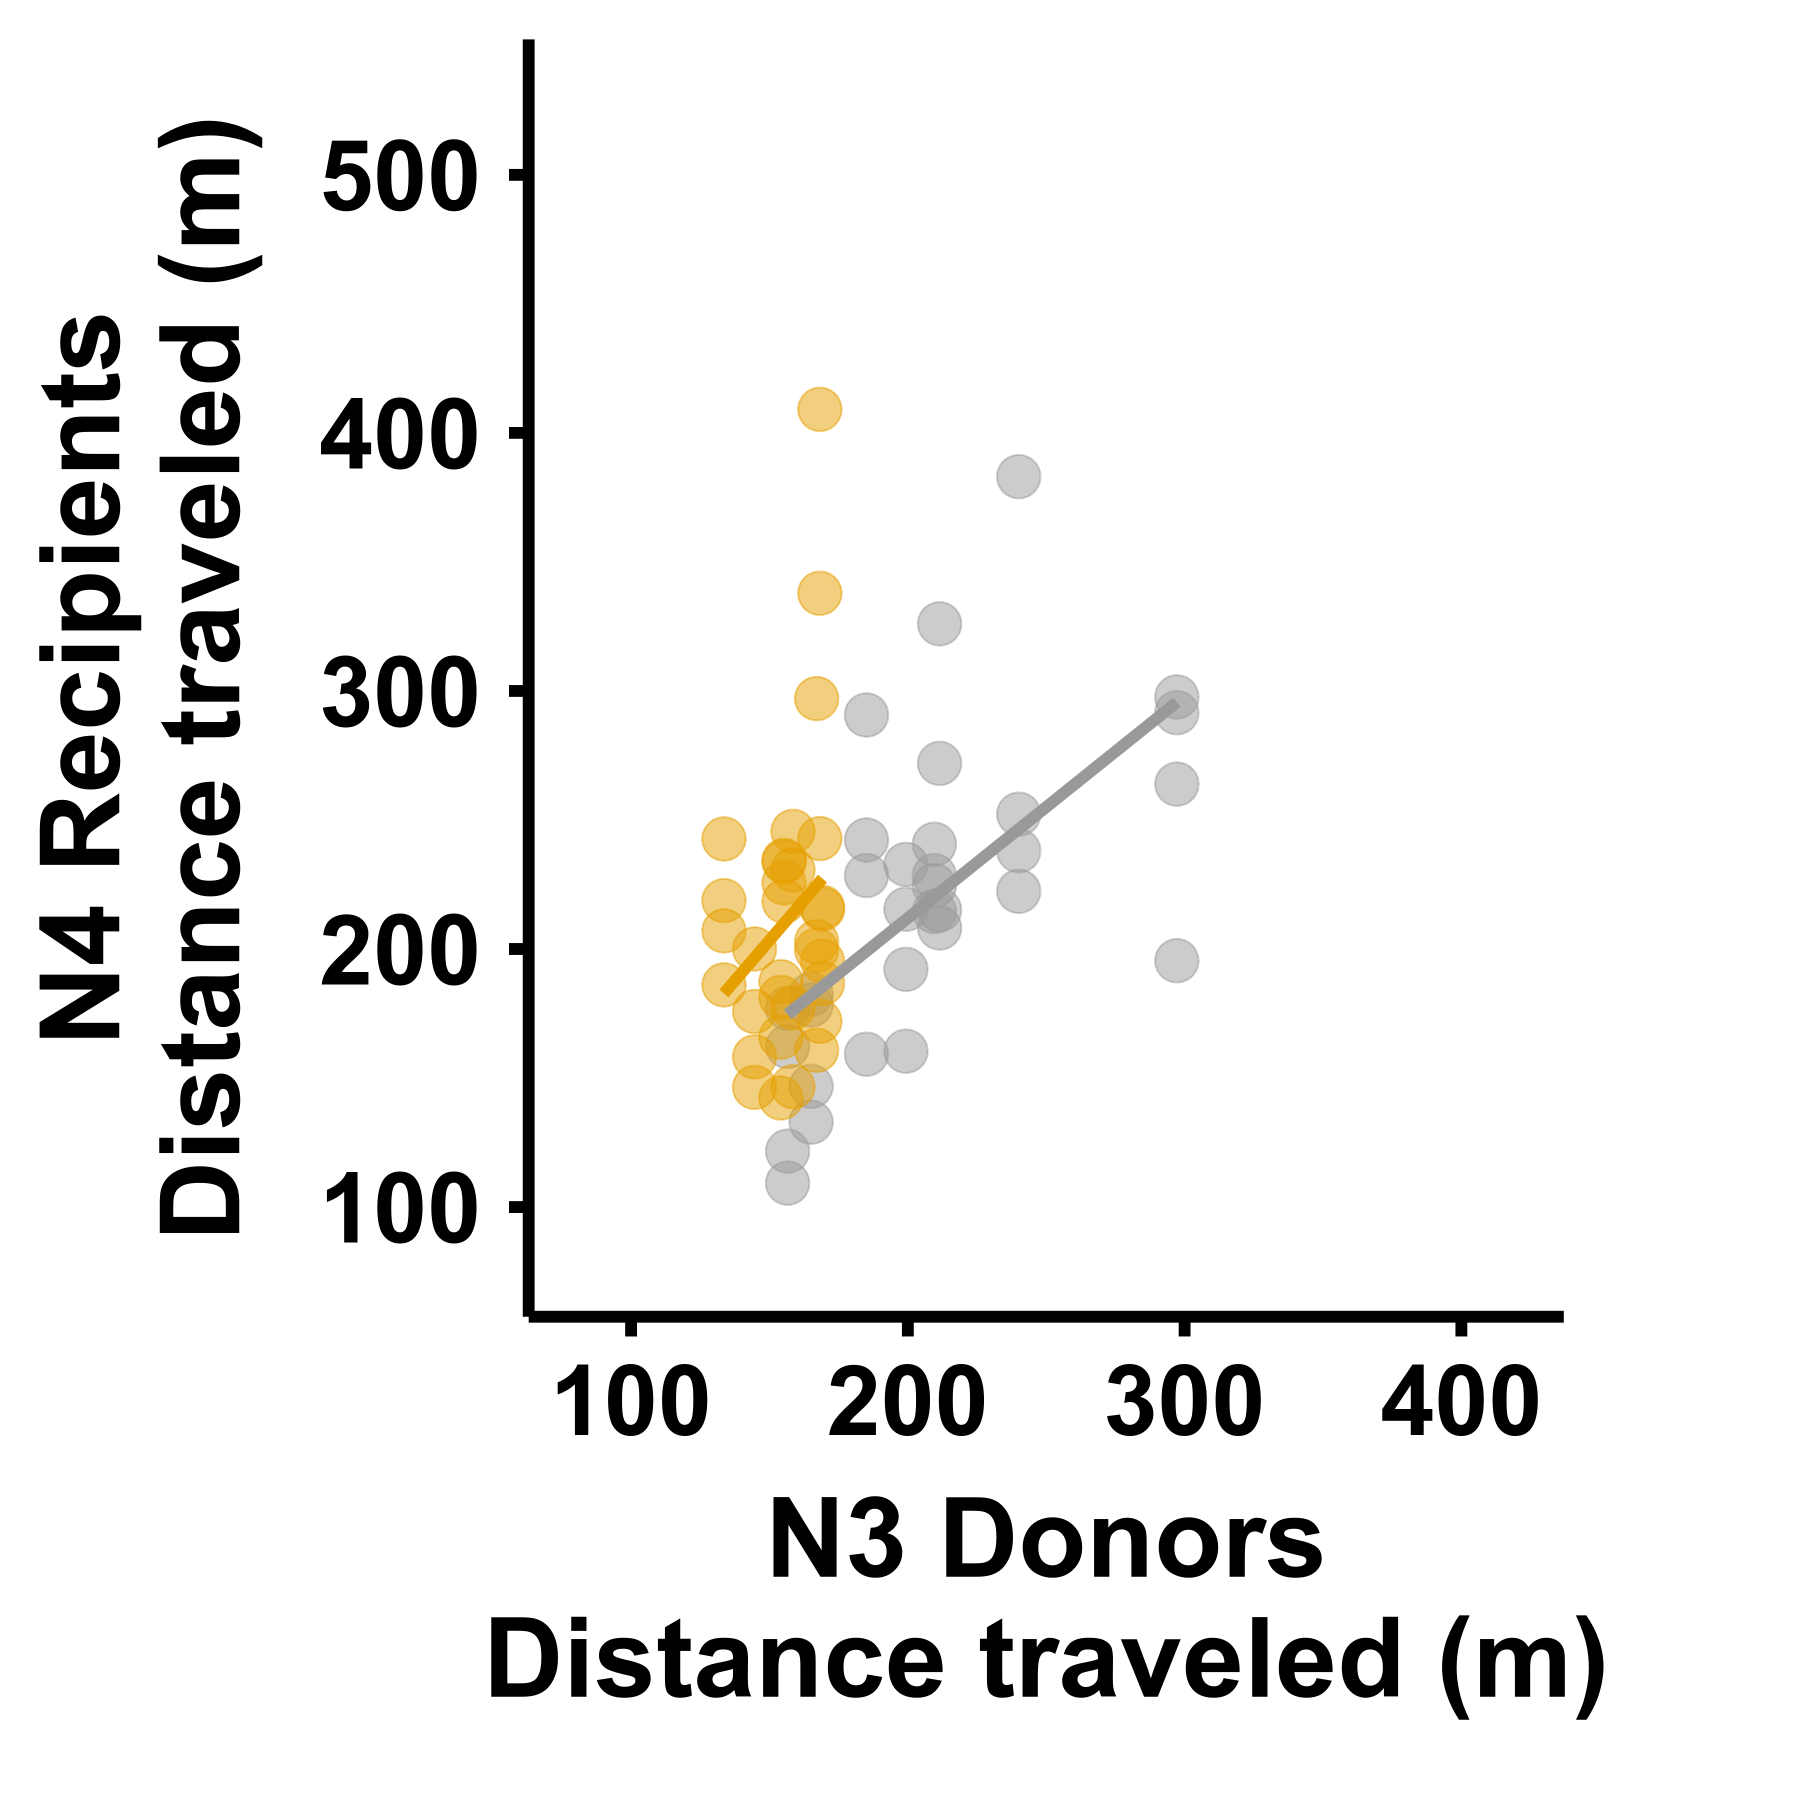

In [26]:
p.dims(9, 9)
ggplot(data = Master_data1_N5, aes(x = PedMeters_ALL_donor, y = PedMeters_ALL, color = TreatmentID)) +
  geom_point(alpha = 0.5, size = 7) +
  ylim(80,530) + #Fig.SX
  xlim(80,420) + #Fig.SX
  #ylim(80,420) + #Fig.2
  #xlim(80,320) + #Fig.2 
  labs(x = "N3 Donors\nDistance traveled (m)", y = "N4 Recipients\nDistance traveled (m)") +
  #geom_smooth(method = lm, color = "red", size = 2) + 
  geom_smooth(method = lm, size = 2, se=FALSE, fullrange=FALSE) + 
  scale_color_manual(labels = c("Control", "Selection"), values=c('#999999','#E69F00'))+
  
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), 
        axis.line = element_line(colour = "black", size = 2), 
        axis.ticks = element_line(color = "black", size=2),
        axis.ticks.length = unit(.25, "cm"), 
        #axis.title = element_text(face="bold", size = 30), #Fig.SX
        #axis.text = element_text(face="bold", size = 30, colour="black"), #Fig.SX
        axis.title = element_text(face="bold", size = 40), #Fig.2
        axis.text = element_text(face="bold", size = 35, colour="black"), #Fig.2
        
        axis.text.x = element_text(margin = margin(t = 10, r = 0, b = 0, l = 0)),
        axis.text.y = element_text(margin = margin(t = 0, r = 10, b = 0, l = 0)),
        axis.title.x = element_text(margin = margin(t = 15, r = 0, b = 0, l = 0)),
        axis.title.y = element_text(margin = margin(t = 0, r = 20, b = 0, l = 0)),
  
        legend.key.size = unit(1, 'cm'),
        legend.key = element_blank(), 
        legend.title=element_blank(),
        legend.text = element_text(face="bold", size = 30),
        plot.margin = unit(c(0.5,3,1,0.5),"cm")
        )   +
        guides(color = FALSE) 

## Distance traveled correlations between donors and recipients (raw data)

In [27]:
#Correlations rho
#All data
cor.test(Master_data1$PedMeters_ALL_donor, Master_data1$PedMeters_ALL, method = "spearman") #rho = 0.1517316, p = 0.007446 

cor.test(Master_data1_noN1$PedMeters_ALL_donor, Master_data1_noN1$PedMeters_ALL, method = "spearman") #rho = 0.1934031, p = 0.002085
cor.test(Master_data1_noN1_C$PedMeters_ALL_donor, Master_data1_noN1_C$PedMeters_ALL, method = "spearman") #rho = 0.2406271, p = 0.006645
cor.test(Master_data1_noN1_T$PedMeters_ALL_donor, Master_data1_noN1_T$PedMeters_ALL, method = "spearman") #rho = 0.1564997, p = 0.08135

cor.test(Master_data1_N2$PedMeters_ALL_donor, Master_data1_N2$PedMeters_ALL, method = "spearman") #rho = 0.282918, p = 0.02587
cor.test(Master_data1_N3$PedMeters_ALL_donor, Master_data1_N3$PedMeters_ALL, method = "spearman") #rho = 0.1516767, p = 0.2393
cor.test(Master_data1_N4$PedMeters_ALL_donor, Master_data1_N4$PedMeters_ALL, method = "spearman") #rho = 0.009882913, p = 0.9387
cor.test(Master_data1_N5$PedMeters_ALL_donor, Master_data1_N5$PedMeters_ALL, method = "spearman") #rho = 0.4700925, p = 8.879e-05

#Control
cor.test(Master_data1_N2_C$PedMeters_ALL_donor, Master_data1_N2_C$PedMeters_ALL, method = "spearman") #rho = 0.04225185, p = 0.8214
cor.test(Master_data1_N3_C$PedMeters_ALL_donor, Master_data1_N3_C$PedMeters_ALL, method = "spearman") #rho = 0.2803248, p = 0.1266 
cor.test(Master_data1_N4_C$PedMeters_ALL_donor, Master_data1_N4_C$PedMeters_ALL, method = "spearman") #rho = 0.101923, p = 0.5788
cor.test(Master_data1_N5_C$PedMeters_ALL_donor, Master_data1_N5_C$PedMeters_ALL, method = "spearman") #rho = 0.701644, p = 7.667e-06

#Selection
cor.test(Master_data1_N2_T$PedMeters_ALL_donor, Master_data1_N2_T$PedMeters_ALL, method = "spearman") #rho = 0.41419, p = 0.02053
cor.test(Master_data1_N3_T$PedMeters_ALL_donor, Master_data1_N3_T$PedMeters_ALL, method = "spearman") #rho = 0.06398718, p = 0.7324
cor.test(Master_data1_N4_T$PedMeters_ALL_donor, Master_data1_N4_T$PedMeters_ALL, method = "spearman") #rho = 0.04184559, p = 0.8231
cor.test(Master_data1_N5_T$PedMeters_ALL_donor, Master_data1_N5_T$PedMeters_ALL, method = "spearman") #rho = 0.243729, p = 0.1789

#Correlation lm coefficient
lm_h = lm(PedMeters_ALL ~ PedMeters_ALL_donor, data = Master_data1_noN1)
lm_h_C = lm(PedMeters_ALL ~ PedMeters_ALL_donor, data = Master_data1_noN1_C)
lm_h_T = lm(PedMeters_ALL ~ PedMeters_ALL_donor, data = Master_data1_noN1_T)

summary(lm_h)
summary(lm_h_C)
summary(lm_h_T)

#Control
lm_h_N2_C = lm(PedMeters_ALL ~ PedMeters_ALL_donor, data = Master_data1_N2_C)
lm_h_N3_C = lm(PedMeters_ALL ~ PedMeters_ALL_donor, data = Master_data1_N3_C)
lm_h_N4_C = lm(PedMeters_ALL ~ PedMeters_ALL_donor, data = Master_data1_N4_C)
lm_h_N5_C = lm(PedMeters_ALL ~ PedMeters_ALL_donor, data = Master_data1_N5_C)

summary(lm_h_N2_C)
summary(lm_h_N3_C)
summary(lm_h_N4_C)
summary(lm_h_N5_C)

#Selection
lm_h_N2_T = lm(PedMeters_ALL ~ PedMeters_ALL_donor, data = Master_data1_N2_T)
lm_h_N3_T = lm(PedMeters_ALL ~ PedMeters_ALL_donor, data = Master_data1_N3_T)
lm_h_N4_T = lm(PedMeters_ALL ~ PedMeters_ALL_donor, data = Master_data1_N4_T)
lm_h_N5_T = lm(PedMeters_ALL ~ PedMeters_ALL_donor, data = Master_data1_N5_T)

summary(lm_h_N2_T)
summary(lm_h_N3_T)
summary(lm_h_N4_T)
summary(lm_h_N5_T)

Warning message in cor.test.default(Master_data1$PedMeters_ALL_donor, Master_data1$PedMeters_ALL, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  Master_data1$PedMeters_ALL_donor and Master_data1$PedMeters_ALL
S = 4211750, p-value = 0.007446
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.1517316 


Warning message in cor.test.default(Master_data1_noN1$PedMeters_ALL_donor, Master_data1_noN1$PedMeters_ALL, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  Master_data1_noN1$PedMeters_ALL_donor and Master_data1_noN1$PedMeters_ALL
S = 2125786, p-value = 0.002085
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.1934031 


Warning message in cor.test.default(Master_data1_noN1_C$PedMeters_ALL_donor, Master_data1_noN1_C$PedMeters_ALL, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  Master_data1_noN1_C$PedMeters_ALL_donor and Master_data1_noN1_C$PedMeters_ALL
S = 253156, p-value = 0.006645
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.2406271 


Warning message in cor.test.default(Master_data1_noN1_T$PedMeters_ALL_donor, Master_data1_noN1_T$PedMeters_ALL, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  Master_data1_noN1_T$PedMeters_ALL_donor and Master_data1_noN1_T$PedMeters_ALL
S = 274559, p-value = 0.08135
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.1564997 


Warning message in cor.test.default(Master_data1_N2$PedMeters_ALL_donor, Master_data1_N2$PedMeters_ALL, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  Master_data1_N2$PedMeters_ALL_donor and Master_data1_N2$PedMeters_ALL
S = 28476, p-value = 0.02587
alternative hypothesis: true rho is not equal to 0
sample estimates:
     rho 
0.282918 


Warning message in cor.test.default(Master_data1_N3$PedMeters_ALL_donor, Master_data1_N3$PedMeters_ALL, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  Master_data1_N3$PedMeters_ALL_donor and Master_data1_N3$PedMeters_ALL
S = 33688, p-value = 0.2393
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.1516767 


Warning message in cor.test.default(Master_data1_N4$PedMeters_ALL_donor, Master_data1_N4$PedMeters_ALL, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  Master_data1_N4$PedMeters_ALL_donor and Master_data1_N4$PedMeters_ALL
S = 41252, p-value = 0.9387
alternative hypothesis: true rho is not equal to 0
sample estimates:
        rho 
0.009882913 


Warning message in cor.test.default(Master_data1_N5$PedMeters_ALL_donor, Master_data1_N5$PedMeters_ALL, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  Master_data1_N5$PedMeters_ALL_donor and Master_data1_N5$PedMeters_ALL
S = 23146, p-value = 8.879e-05
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.4700925 


Warning message in cor.test.default(Master_data1_N2_C$PedMeters_ALL_donor, Master_data1_N2_C$PedMeters_ALL, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  Master_data1_N2_C$PedMeters_ALL_donor and Master_data1_N2_C$PedMeters_ALL
S = 4750.4, p-value = 0.8214
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
0.04225185 


Warning message in cor.test.default(Master_data1_N3_C$PedMeters_ALL_donor, Master_data1_N3_C$PedMeters_ALL, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  Master_data1_N3_C$PedMeters_ALL_donor and Master_data1_N3_C$PedMeters_ALL
S = 3569.6, p-value = 0.1266
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.2803248 


Warning message in cor.test.default(Master_data1_N4_C$PedMeters_ALL_donor, Master_data1_N4_C$PedMeters_ALL, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  Master_data1_N4_C$PedMeters_ALL_donor and Master_data1_N4_C$PedMeters_ALL
S = 4899.9, p-value = 0.5788
alternative hypothesis: true rho is not equal to 0
sample estimates:
     rho 
0.101923 


Warning message in cor.test.default(Master_data1_N5_C$PedMeters_ALL_donor, Master_data1_N5_C$PedMeters_ALL, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  Master_data1_N5_C$PedMeters_ALL_donor and Master_data1_N5_C$PedMeters_ALL
S = 1627.8, p-value = 7.667e-06
alternative hypothesis: true rho is not equal to 0
sample estimates:
     rho 
0.701644 


Warning message in cor.test.default(Master_data1_N2_T$PedMeters_ALL_donor, Master_data1_N2_T$PedMeters_ALL, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  Master_data1_N2_T$PedMeters_ALL_donor and Master_data1_N2_T$PedMeters_ALL
S = 2905.6, p-value = 0.02053
alternative hypothesis: true rho is not equal to 0
sample estimates:
    rho 
0.41419 


Warning message in cor.test.default(Master_data1_N3_T$PedMeters_ALL_donor, Master_data1_N3_T$PedMeters_ALL, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  Master_data1_N3_T$PedMeters_ALL_donor and Master_data1_N3_T$PedMeters_ALL
S = 4642.6, p-value = 0.7324
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
0.06398718 


Warning message in cor.test.default(Master_data1_N4_T$PedMeters_ALL_donor, Master_data1_N4_T$PedMeters_ALL, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  Master_data1_N4_T$PedMeters_ALL_donor and Master_data1_N4_T$PedMeters_ALL
S = 4752.4, p-value = 0.8231
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
0.04184559 


Warning message in cor.test.default(Master_data1_N5_T$PedMeters_ALL_donor, Master_data1_N5_T$PedMeters_ALL, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  Master_data1_N5_T$PedMeters_ALL_donor and Master_data1_N5_T$PedMeters_ALL
S = 4126.2, p-value = 0.1789
alternative hypothesis: true rho is not equal to 0
sample estimates:
     rho 
0.243729 



Call:
lm(formula = PedMeters_ALL ~ PedMeters_ALL_donor, data = Master_data1_noN1)

Residuals:
     Min       1Q   Median       3Q      Max 
-118.562  -41.314   -5.966   24.714  314.083 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)         182.9747    13.5983   13.46  < 2e-16 ***
PedMeters_ALL_donor   0.1734     0.0652    2.66  0.00833 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 61.18 on 249 degrees of freedom
Multiple R-squared:  0.02762,	Adjusted R-squared:  0.02372 
F-statistic: 7.073 on 1 and 249 DF,  p-value: 0.008332



Call:
lm(formula = PedMeters_ALL ~ PedMeters_ALL_donor, data = Master_data1_noN1_C)

Residuals:
     Min       1Q   Median       3Q      Max 
-122.933  -40.925   -5.307   28.480  297.717 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         165.30123   22.30282   7.412 1.69e-11 ***
PedMeters_ALL_donor   0.24299    0.09425   2.578   0.0111 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 61.65 on 124 degrees of freedom
Multiple R-squared:  0.05088,	Adjusted R-squared:  0.04323 
F-statistic: 6.647 on 1 and 124 DF,  p-value: 0.0111



Call:
lm(formula = PedMeters_ALL ~ PedMeters_ALL_donor, data = Master_data1_noN1_T)

Residuals:
     Min       1Q   Median       3Q      Max 
-117.385  -42.026   -8.635   21.680  314.528 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)         197.0845    22.1264   8.907 5.75e-15 ***
PedMeters_ALL_donor   0.1007     0.1259   0.800    0.425    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 60.95 on 123 degrees of freedom
Multiple R-squared:  0.005178,	Adjusted R-squared:  -0.00291 
F-statistic: 0.6402 on 1 and 123 DF,  p-value: 0.4252



Call:
lm(formula = PedMeters_ALL ~ PedMeters_ALL_donor, data = Master_data1_N2_C)

Residuals:
    Min      1Q  Median      3Q     Max 
-100.62  -45.99   10.17   34.99   89.17 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)         233.181128  32.395147   7.198 6.34e-08 ***
PedMeters_ALL_donor  -0.001968   0.132553  -0.015    0.988    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 52.66 on 29 degrees of freedom
Multiple R-squared:  7.601e-06,	Adjusted R-squared:  -0.03447 
F-statistic: 0.0002204 on 1 and 29 DF,  p-value: 0.9883



Call:
lm(formula = PedMeters_ALL ~ PedMeters_ALL_donor, data = Master_data1_N3_C)

Residuals:
    Min      1Q  Median      3Q     Max 
-139.84  -53.41  -16.88   20.83  295.75 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)
(Intercept)         112.8889    93.6796   1.205    0.238
PedMeters_ALL_donor   0.4618     0.3715   1.243    0.224

Residual standard error: 87.98 on 29 degrees of freedom
Multiple R-squared:  0.05058,	Adjusted R-squared:  0.01784 
F-statistic: 1.545 on 1 and 29 DF,  p-value: 0.2238



Call:
lm(formula = PedMeters_ALL ~ PedMeters_ALL_donor, data = Master_data1_N4_C)

Residuals:
    Min      1Q  Median      3Q     Max 
-57.209 -24.918  -7.977  19.058 125.583 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)         166.8094    26.4501   6.307 5.94e-07 ***
PedMeters_ALL_donor   0.1693     0.1118   1.515     0.14    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 40.44 on 30 degrees of freedom
Multiple R-squared:  0.07106,	Adjusted R-squared:  0.04009 
F-statistic: 2.295 on 1 and 30 DF,  p-value: 0.1403



Call:
lm(formula = PedMeters_ALL ~ PedMeters_ALL_donor, data = Master_data1_N5_C)

Residuals:
     Min       1Q   Median       3Q      Max 
-100.143  -26.017   -3.858   11.242  136.555 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)          40.0040    43.6502   0.916 0.366730    
PedMeters_ALL_donor   0.8601     0.2057   4.182 0.000231 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 48.83 on 30 degrees of freedom
Multiple R-squared:  0.3682,	Adjusted R-squared:  0.3472 
F-statistic: 17.49 on 1 and 30 DF,  p-value: 0.0002312



Call:
lm(formula = PedMeters_ALL ~ PedMeters_ALL_donor, data = Master_data1_N2_T)

Residuals:
     Min       1Q   Median       3Q      Max 
-102.361  -19.793    2.127   20.714   70.757 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)         135.0425    30.1320   4.482 0.000107 ***
PedMeters_ALL_donor   0.4984     0.1843   2.704 0.011353 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 42.47 on 29 degrees of freedom
Multiple R-squared:  0.2013,	Adjusted R-squared:  0.1738 
F-statistic: 7.309 on 1 and 29 DF,  p-value: 0.01135



Call:
lm(formula = PedMeters_ALL ~ PedMeters_ALL_donor, data = Master_data1_N3_T)

Residuals:
   Min     1Q Median     3Q    Max 
-68.25 -31.71 -13.68  14.48 115.46 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)         196.4618    37.1453   5.289 1.14e-05 ***
PedMeters_ALL_donor   0.1379     0.1998   0.690    0.496    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 52.41 on 29 degrees of freedom
Multiple R-squared:  0.01616,	Adjusted R-squared:  -0.01777 
F-statistic: 0.4763 on 1 and 29 DF,  p-value: 0.4956



Call:
lm(formula = PedMeters_ALL ~ PedMeters_ALL_donor, data = Master_data1_N4_T)

Residuals:
   Min     1Q Median     3Q    Max 
-74.03 -52.51 -28.15   6.95 323.95 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)         253.4886    56.8925   4.456 0.000115 ***
PedMeters_ALL_donor  -0.2280     0.2921  -0.781 0.441261    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 85.27 on 29 degrees of freedom
Multiple R-squared:  0.02059,	Adjusted R-squared:  -0.01318 
F-statistic: 0.6096 on 1 and 29 DF,  p-value: 0.4413



Call:
lm(formula = PedMeters_ALL ~ PedMeters_ALL_donor, data = Master_data1_N5_T)

Residuals:
   Min     1Q Median     3Q    Max 
-67.32 -37.15 -11.46  23.94 183.01 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)
(Intercept)          15.8367   129.1036   0.123    0.903
PedMeters_ALL_donor   1.2501     0.8236   1.518    0.140

Residual standard error: 54.32 on 30 degrees of freedom
Multiple R-squared:  0.07131,	Adjusted R-squared:  0.04036 
F-statistic: 2.304 on 1 and 30 DF,  p-value: 0.1395


## Distance traveled correlations between donors and recipients (residuals)

In [28]:
#Correlations 
#All data
cor.test(Master_data1$PedMeters_donor_residuals, Master_data1$PedMeters_recipient_residuals, method = "spearman")
cor.test(Master_data1_N2$PedMeters_donor_residuals, Master_data1_N2$PedMeters_recipient_residuals, method = "spearman")
cor.test(Master_data1_N3$PedMeters_donor_residuals, Master_data1_N3$PedMeters_recipient_residuals, method = "spearman")
cor.test(Master_data1_N4$PedMeters_donor_residuals, Master_data1_N4$PedMeters_recipient_residuals, method = "spearman")
cor.test(Master_data1_N5$PedMeters_donor_residuals, Master_data1_N5$PedMeters_recipient_residuals, method = "spearman")

#Control
cor.test(Master_data1_N2_C$PedMeters_donor_residuals, Master_data1_N2_C$PedMeters_recipient_residuals, method = "spearman")
cor.test(Master_data1_N3_C$PedMeters_donor_residuals, Master_data1_N3_C$PedMeters_recipient_residuals, method = "spearman")
cor.test(Master_data1_N4_C$PedMeters_donor_residuals, Master_data1_N4_C$PedMeters_recipient_residuals, method = "spearman")
cor.test(Master_data1_N5_C$PedMeters_donor_residuals, Master_data1_N5_C$PedMeters_recipient_residuals, method = "spearman")

#Selection
cor.test(Master_data1_N2_T$PedMeters_donor_residuals, Master_data1_N2_T$PedMeters_recipient_residuals, method = "spearman")
cor.test(Master_data1_N3_T$PedMeters_donor_residuals, Master_data1_N3_T$PedMeters_recipient_residuals, method = "spearman")
cor.test(Master_data1_N4_T$PedMeters_donor_residuals, Master_data1_N4_T$PedMeters_recipient_residuals, method = "spearman") 
cor.test(Master_data1_N5_T$PedMeters_donor_residuals, Master_data1_N5_T$PedMeters_recipient_residuals, method = "spearman")

Warning message in cor.test.default(Master_data1$PedMeters_donor_residuals, Master_data1$PedMeters_recipient_residuals, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  Master_data1$PedMeters_donor_residuals and Master_data1$PedMeters_recipient_residuals
S = 2439250, p-value = 0.2398
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
0.07446394 


Warning message in cor.test.default(Master_data1_N2$PedMeters_donor_residuals, Master_data1_N2$PedMeters_recipient_residuals, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  Master_data1_N2$PedMeters_donor_residuals and Master_data1_N2$PedMeters_recipient_residuals
S = 37286, p-value = 0.6374
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
0.06105417 


Warning message in cor.test.default(Master_data1_N3$PedMeters_donor_residuals, Master_data1_N3$PedMeters_recipient_residuals, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  Master_data1_N3$PedMeters_donor_residuals and Master_data1_N3$PedMeters_recipient_residuals
S = 34050, p-value = 0.2691
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.1425438 


Warning message in cor.test.default(Master_data1_N4$PedMeters_donor_residuals, Master_data1_N4$PedMeters_recipient_residuals, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  Master_data1_N4$PedMeters_donor_residuals and Master_data1_N4$PedMeters_recipient_residuals
S = 42609, p-value = 0.86
alternative hypothesis: true rho is not equal to 0
sample estimates:
        rho 
-0.02267539 


Warning message in cor.test.default(Master_data1_N5$PedMeters_donor_residuals, Master_data1_N5$PedMeters_recipient_residuals, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  Master_data1_N5$PedMeters_donor_residuals and Master_data1_N5$PedMeters_recipient_residuals
S = 35481, p-value = 0.1375
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.1877067 


Warning message in cor.test.default(Master_data1_N2_C$PedMeters_donor_residuals, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  Master_data1_N2_C$PedMeters_donor_residuals and Master_data1_N2_C$PedMeters_recipient_residuals
S = 6461.2, p-value = 0.09792
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.3026695 


Warning message in cor.test.default(Master_data1_N3_C$PedMeters_donor_residuals, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  Master_data1_N3_C$PedMeters_donor_residuals and Master_data1_N3_C$PedMeters_recipient_residuals
S = 3768.1, p-value = 0.1929
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.2403074 


Warning message in cor.test.default(Master_data1_N4_C$PedMeters_donor_residuals, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  Master_data1_N4_C$PedMeters_donor_residuals and Master_data1_N4_C$PedMeters_recipient_residuals
S = 5085.3, p-value = 0.7117
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
0.06794868 


Warning message in cor.test.default(Master_data1_N5_C$PedMeters_donor_residuals, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  Master_data1_N5_C$PedMeters_donor_residuals and Master_data1_N5_C$PedMeters_recipient_residuals
S = 4142.3, p-value = 0.1844
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.2407747 


Warning message in cor.test.default(Master_data1_N2_T$PedMeters_donor_residuals, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  Master_data1_N2_T$PedMeters_donor_residuals and Master_data1_N2_T$PedMeters_recipient_residuals
S = 4349.4, p-value = 0.5094
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.1230992 


Warning message in cor.test.default(Master_data1_N3_T$PedMeters_donor_residuals, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  Master_data1_N3_T$PedMeters_donor_residuals and Master_data1_N3_T$PedMeters_recipient_residuals
S = 3792.3, p-value = 0.2023
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.2354322 


Warning message in cor.test.default(Master_data1_N4_T$PedMeters_donor_residuals, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  Master_data1_N4_T$PedMeters_donor_residuals and Master_data1_N4_T$PedMeters_recipient_residuals
S = 5983.7, p-value = 0.2653
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.2063841 


Warning message in cor.test.default(Master_data1_N5_T$PedMeters_donor_residuals, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  Master_data1_N5_T$PedMeters_donor_residuals and Master_data1_N5_T$PedMeters_recipient_residuals
S = 4110.1, p-value = 0.1735
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.2466832 
